# ENSF 544 Data Science for Software Engineers
## Project 2 Phase 1
#### By: Kyle Friedt, Erslan Salman, Avneet Gill, and Kelvin Tran 

# Phase 1 

### Preprocessing

In [54]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import re

### Now load the pickle data into dataframes from the Output folder one directory above

In [55]:
def loadEverything():
    all_projects_bugreports = pd.read_pickle('Output/allBugReports.pickle')
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('Output/allSourceCodes.pickle')
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bugreports, all_projects_source_codes = loadEverything()

display(all_projects_source_codes.head())
display(all_projects_bugreports.head())

*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


,filename,unprocessed_code,project
0,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
1,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
2,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
3,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS
4,\gitrepo\src\java\org\apache\commons\collectio...,/*\n * Licensed to the Apache Software Founda...,COLLECTIONS


,fix,text,fixdate,summary,description,project,average_precision
id,,,,,,,
217,[org.apache.commons.collections.map.flat3map.j...,NaN,2006-07-18 22:02:11,Flat3Map.Entry.setValue() overwrites other Ent...,Flat3Map&amp;apos;s Entry objects will overwri...,COLLECTIONS,0.0
214,[org.apache.commons.collections.testextendedpr...,NaN,2006-07-18 22:44:33,ExtendedProperties - field include should be n...,"The field ""include"" in ExtendedProperties is c...",COLLECTIONS,0.0
222,[org.apache.commons.collections.testlistutils....,NaN,2006-08-18 19:01:22,CollectionUtils removeAll is actually retainAll,"The removeAll(Collection collection, Collectio...",COLLECTIONS,0.0
261,[org.apache.commons.collections.map.flat3map.j...,NaN,2007-08-20 14:11:54,Flat3Map.remove() does not return the correct ...,final Flat3Map m = new Flat3Map();\n ...,COLLECTIONS,0.0
264,[org.apache.commons.collections.fasttreemap.java],NaN,2007-08-31 09:39:59,FastTreeMap forgets the comparator,In line 359 and 582 of the current 3.2 release...,COLLECTIONS,0.0


# Preprocessing
#### This section contains all the file for cleaning up the source files and bug reports

The main steps we took are:
- removing and cleaning up new lines or extra lines in the unprocessed code
- changing source file paths and bug fix file paths to be of the same format for comparison later 
- cleaning composite words that have a `camelCase` syntax 
- removing english stop words, java key words and java operators
- stemming & tokenizing 
- combing description and summary for bug report to create the query

#### Removing new lines

In [56]:


#remove next line characters:
def remove_new_lines(text):
    text = str(text)
    COMBINE_WHITE_SPACE = re.compile(r"(?a:\s+)")
    text = COMBINE_WHITE_SPACE.sub(' ', text)
    return text.replace('*', '').replace('/', '').replace('\\','')
    
# clean up the various white space and remove some *
def clean_new_lines_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(remove_new_lines)
    return df

# clean up the description and summary, they will both be used for the query
def clean_new_lines_bug_report(df):
    df.summary = df.summary.apply(remove_new_lines)
    df['description'] = df['description'].astype('|S')
    df.description = df.description.apply(remove_new_lines)
    return df

#### Cleaning file paths

In [57]:
# changes file path to be just the filename + extension for source code files
def clean_sc_file(x):
    file = x.split("\\")
    return ''.join(file[-1:])

# changes file path to be just the filename + extension for bug report fixes 
def clean_bug_file(x):
    fixes = []
    for file in x:
        file = file.split(".")
        file = '.'.join(file[-2:])
        fixes.append(file)
    return fixes


def clean_sc_filepath(df):
    df.filename = df.filename.apply(clean_sc_file)
    return df


def clean_bug_filepath(df):
    df.fix = df.fix.apply(clean_bug_file)
    return df

#### Cleaning composite words

In [58]:
#splitting composite words
#splits using camlecase syntax
def findCompositeWords(s):
    return ' '.join(re.findall('[A-Z][^A-Z]*', s))   


def clean_composite_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(findCompositeWords)
    return df

def clean_composite_bug_report(df):
    df.summary = df.summary.apply(findCompositeWords)
    df.description = df.description.apply(findCompositeWords)
    return df


#### Removing fixes that can't be found

In [59]:
# look through the src data frame to find where the fix is. 
def get_fix_indexes(bug, src):
    fix_list = list()
    for fixes in bug["fix"]:
        fix_sub=list()
        for fix in fixes:
            df = src[src["filename"].str.match(fix)]
            if(df.shape[0] != 0):
                fix_sub.append(df.index[0])
            else:
                fix_sub.append(-1)
        fix_list.append(fix_sub)
    # this is a list of the indexes of the file where the fix was located
    return fix_list

In [60]:
def removeFixesNotFound(bug, src):
    bug["fix_indexes"] = get_fix_indexes(bug, src)
    fixes = bug.fix.tolist()
    fix_indexes = bug.fix_indexes.tolist()
    fixes_return = []
    fixes_indexes_return = []
    for i in range(len(fixes)):
        fixes_temp = []
        indexes_temp = []
        for l in range(len(fix_indexes[i])):
            if fix_indexes[i][l] != -1:           
                fixes_temp.append(fixes[i][l])
                indexes_temp.append(fix_indexes[i][l])
        if len(fixes_temp) == 0:
            fixes_return.append(np.nan)
            fixes_indexes_return.append(np.nan)
        else:
            fixes_return.append(fixes_temp)
            fixes_indexes_return.append(indexes_temp)
        print(fixes_return)
        print(fixes_indexes_return)
    bug['fix'] = fixes_return
    bug['fix_indexes'] = fixes_indexes_return 
    
    return bug

#### Combining stop words, keywords and operators

In [61]:


# add the Java key words to the stop words
java_keywords = ["abstract", "assert**","assert", "boolean", "break", "byte", "case", "catch", "char", "const", "continue", "default", "do", "double", "else", "enum", "enum****" "extends", "final", "finally", "for", "goto","goto*", "if", "implements", "import", "instanceof", "int","interface", "long", "native", "new", "package", "private", "protected", "public", "return", "short", "static", "strictfp**","strictfp", "super", "switch", "synchornized", "this", "throw", "throws", "transient", "try", "void", "volatile", "while"]
java_operators = ["+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "++", "--", "==", "!=", "<", ">", "<=", ">=", ".", "[", "]", "(",")", "!", "~","instanceof", "<<", ">>", ">>>", "&", "^", "|", "&&", "||", "?", ":", "^=", "%=", "<<=", ">>=", ">>>=", "&="]
stop = java_keywords + java_operators
#contains english stop words, java keywords and java operators
STOP_WORDS = ENGLISH_STOP_WORDS.union(stop)



#### Stemming & calling cleaning functions

In [62]:
# remove the stem and stop words
# takes in an array of strings returns an array of strings
def stem_stop(text):
    stemmer = PorterStemmer()   #"english"
    text = text.split()
    text = [w for w in text if not w in STOP_WORDS]
    text = list(map(lambda x: stemmer.stem(x), text))
    text = ' '.join(text)
    text = text.strip()
    return text

# clean up the unprocessed code column
def clean_source_df(df):
    # clean up the new lines
    df = clean_new_lines_source_code(df)
    # clean up composite words
    df = clean_composite_source_code(df)
    # clean filepaths
    df = clean_sc_filepath(df)
    return df

# add the summary and description together and clean the data
def clean_combine_bug_df(df):
    # clean up new lines
    df = clean_new_lines_bug_report(df)
    # clean composite words
    df = clean_composite_bug_report(df)
    # clean file path
    df = clean_bug_filepath(df)
    # combine summary and descriptions to create query
    df["query"] = df["summary"] + df["description"]
    return df


In [63]:
#  get clean versions of the dataframes
sc_df = clean_source_df(all_projects_source_codes)
br_df = clean_combine_bug_df(all_projects_bugreports)

# remove fixes that aren't found
br_df = removeFixesNotFound(br_df, sc_df)
br_df = br_df.dropna(subset=['fix','fix_indexes'])



# get a list of the projects 
projects = sc_df.project.unique()

# group the data frames
sc_grouped_df = sc_df.groupby(sc_df.project)
bg_grouped_df = br_df.groupby(br_df.project)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
sc_grouped_df

# TF-IDF
### This section contains all the code for applying two different cosine similarity functions

In this sections we apply two different similarity functions, equation (1) and equations(7) from the report. 
The TF-IDF is fitted to each of the 12 projects and used to calculate the similarity.


For equation (1):
- we used a classic VSM, and found the relevancy score between a file f and a query q as being the cosine similarity between their corresponding vector representations 

For equation (7):
- we used a rVSM, where the relevancy score is calculated between each source code file and the bug report (direct relevancy)
- this is favourable to the classic VSM model as it takes into account the length of files, and does not favour shorter files like equation 1
- we used the file lengths as the number for terms in equations 5


In [22]:


# generate number of terms based off of length of file 
def generate_number_terms(arr):
#     f = lambda x: 1 / (1 + np.exp(-1 * x))
#     result = f(arr)


    result = []
    for item in arr:
        result.append( 1 / (1 + np.exp(-1 * item)))
    return result

# min max scaler 
def custom_min_max(arr):
#     min_val = np.amin(arr)
#     max_val = np.amax(arr)
#     f = lambda x: (x - min_val) / (max_val - min_val)
#     result = f(arr)


    min_val = min(arr)
    max_val = max(arr)
    result = []
    for item in arr:
        result.append((item - min_val)/(max_val - min_val))
        
    return result

# calculate the similarity when using revised Vector Space Model
def calculate_rVSM_similarity(vect, src_vect, query_data, num_terms):
    query = vect.transform(query_data)
    cosSim = cosine_similarity(query, src_vect).flatten()
    
#     result = numpy.multiply(cosSim, num_terms)
#     return result

    for i in range(len(cosSim)):
        cosSim[i] = cosSim[i] * num_terms[i]
    return cosSim

# calculate the similarity when using basic cosine similarity   
def calculate_similarity(src_vect, query):    
    cosSim = cosine_similarity(query, src_vect).flatten()
    return cosSim

# # get VSM and rVSM similarity
# def get_both_similarity(vect, src_files, src_vect, query_data, num_terms):
#     query = vect.transform(query_data)
#     similarity = calculate_similarity(src_vect,query)  
#     similarity_eq7 = calculate_similarity_eq7(src_files, src_vect, query, num_terms)
#     return similarity, similarity_eq7

    
# # this only calculates the score for the rVSM
# def generate_scores_list(source, query):
#     scores_list = [] 

#     # get a list of strings from the data frames to be vectorized
#     source['unprocessed_code'] = source['unprocessed_code'].map(stem_stop)
#     query["query"] = query["query"].map(stem_stop)

    
#     # fit a vectorizer to the data
#     vect = TfidfVectorizer(min_df=1).fit(source['unprocessed_code'])
#     src_vect = vect.transform(source['unprocessed_code'])
    
#     # used to define the number of terms for each source code file
#     source_lengths = []
#     for src in source['unprocessed_code']:
#         source_lengths.append(len(src.split()))
    
#     # normalized length used to calculated normalized num of terms
#     normalized_source_length = custom_min_max(source_lengths)

#     # normalized num of terms
#     num_terms = generate_number_terms(normalized_source_length)

    
#     #get the similarity scores for the bug reports    
#     for q in query["query"]:
#         similarity = calculate_rVSM_similarity(vect, source['unprocessed_code'], src_vect, [q], num_terms)
#         scores_list.append(similarity)


#     return scores_list



# generates direct and indirect scores
def generate_scores_list(source, query):
    direct_scores = []
    indirect_scores = []
     # get a list of strings from the data frames to be vectorized
    source['unprocessed_code'] = source['unprocessed_code'].map(stem_stop)
    query["query"] = query["query"].map(stem_stop)
    
       
    # fit a vectorizer to the data
    vect = TfidfVectorizer(min_df=1).fit(source['unprocessed_code'])
    src_vect = vect.transform(source['unprocessed_code'])
    
    # used to define the number of terms for each source code file
    source_lengths = []
    for src in source['unprocessed_code']:
        source_lengths.append(len(src.split()))
        
     # normalized length used to calculated normalized num of terms
    normalized_source_length = custom_min_max(source_lengths)

    # normalized num of terms
    num_terms = generate_number_terms(normalized_source_length)
    
    # get the DIRECT and INDIRECT similarity scores for the bug reports
    src_code_len = len(source['unprocessed_code'])
    for q in query["query"]:
        # calculate direct similarity and append it to the list
        similarity = calculate_rVSM_similarity(vect, src_vect, [q], num_terms)
        direct_scores.append(similarity)   
        
        # calculate indirect similarity and append it to the list
        indirect_similarity = calculate_indirect_scores(vect, src_code_len, [q], 
                                                        query, source)
        indirect_scores.append(indirect_similarity)

    
    return direct_scores, indirect_scores



# caclulate the similarity between new bugs and old bugs.
def calculate_indirect_scores(vect, src_len, query_data, prev_bugs, src):
    query = vect.transform(query_data)
    # np array of zeros, update the values as needed.
    sim_scores = np.zeros(src_len)
    bug_vect = vect.transform(prev_bugs["query"])
    # CAN'T COMPARE A BUG TO IT'S SELF
    # get similarity between the query and the prev bug query
    bugs_sim = calculate_similarity(bug_vect, query) # one of the entries shoudl be 1
#     print("Similarity between bug and all other bugs: ", bugs_sim)
    for indx in range(len(bugs_sim)):
       # get the number of fixes
        num_fixes = len(prev_bugs["fix"].iloc[indx])
        
        # for each fix find it's index in the source['filename'] column
        for fix in prev_bugs["fix"].iloc[indx]:
            
            df = src[src["filename"].str.match(fix)]
            if(df.shape[0] != 0):
                # matching bug get the index of the match
                sim_indx = df.index[0]
                # update the sim_scores at that index
                if(bugs_sim[indx] == 1):
                    # don't add the similarity values if they are for the same bug
                    pass
#                     print("This is the same bug, similarity = ", bugs_sim[indx], " Index: ", indx)
                else:
                    sim_scores[sim_indx] = sim_scores[sim_indx] + (bugs_sim[indx]/num_fixes)
#             else:
#                 print("No match for: " , fix)
    # now we have a list of indirect similarity scores for a single bug and all src code files
    display(sim_scores)
    return sim_scores



# Phase 2
### Implementing Equation 8
- Layer 1: A single bug report
- Layer 2: All the previous bug reports and their similarity to bug in layer 1 just cosSim (no rVSM)
- Layer 3: The source code files where the bug fixes from bugs in layer 2 are located

### SimiScore
- Similarity between a bug and the files that similar bugs are connected to
- n = the number of fixes for the sovled bug report
- Similarity = cosSim between bug query and solved bug
- SimiScore = sum of all Solved bug reports (Similarity/n) that connect to that file

### Final Score (eq9)
- (1-alpha) x N(rVSMScore) + (alpha) x N(Simi Score)

In [9]:
# get rid of the bug reports without fixes
def remove_no_fix(bug_df):
    
    only_fixes_df = ...# data frame that has all the bugs with out any fixes
    clean_bug_df = remove_invalid_paths(only_fixes_df)
    return clean_bug_df

# remove the fix paths in the bug_reports fix column that are not in the source code files
def remove_invalid_paths(only_fixes_df):
    
    return clean_bug_df

    
    

## Ranking similarities and getting fix indexes to compare 

In this section we rank the files and determine whether the fix was found or not and if it was, which index it was. 

In [10]:
# rank all the similarity scores
def rank_sim_scores(scores):
    sim_scores = list()
    
    for score in scores:
        indicies = range(len(score))

        scores_tuple = tuple(zip(score,indicies))
        sorted_tuple = sorted(scores_tuple, reverse = True)

        sim_scores.append(sorted_tuple)
    
    return sim_scores

# MAP, MRR and Other Scores

### This section contains all the code for calculated MAP and MRR, as well scores such as top 1%, 5% and 10%

Calculating MAP:
- To calculate the mean average precision we calculcated equation (11) from the paper and found the mean

Calculating MRR:
- To calculate the mean reciprocal rank we calculated equation (10) form the paper

In [11]:
def average_precision(bug,isCosineSim=True):
#Checks the average precision for each bug
    ap_list = list()
    ranked_sim = 'ranked_sim'
    if not isCosineSim:
        ranked_sim = 'ranked_eq7_sim'
    for index, row in bug.iterrows():
        hit_list = list()
        countTrue=0
        for i in range(len(row[ranked_sim])):
            # check if source file is actually where bug is located
            if(row[ranked_sim][i][1] in row['fix_indexes']):
                countTrue+=1
                hit_list.append(countTrue/(i+1))
        if(countTrue != 0):
            ap_list.append(sum(hit_list)/countTrue)
        else:
            ap_list.append(0)
    return ap_list


#reciprocal rank is 1/n, where n is the first position of a source file where the bug is located in the ranked_sim column
def reciprocal_rank(bug,isCosineSim=True):
    rr_list = list()
    ranked_sim = 'ranked_sim'
    if not isCosineSim:
        ranked_sim = 'ranked_eq7_sim'
    for index, row in bug.iterrows():
        rr = 0
        for i in range(len(row[ranked_sim])):
            # check if source file is actually where bug is located
            if(row[ranked_sim][i][1] in row['fix_indexes']):
                rr = 1/(i+1)
                break
        rr_list.append(rr)
    return rr_list

# Gets a list containing the rank of all fixes that were found in the ranked similarity list
def get_fix_rank(bug, isCosineSim=True):
    fix_list = list()
    ranked_sim = 'ranked_sim'
    if not isCosineSim:
        ranked_sim = 'ranked_eq7_sim'
    for index, row in bug.iterrows():
        i_list = list()
        for i in range(len(row[ranked_sim])):
            if(row[ranked_sim][i][1] in row['fix_indexes']):
                i_list.append(i+1)
        fix_list.append(i_list)
    return fix_list

### Get metrics into the data frames

In [12]:
# take in the source code df for a project and a single query return scores
import warnings
warnings.filterwarnings("ignore")

def generate_all_scores():
    
    all_bugs = []
    all_src = []
    # iterate through the list of 12 projects
    i = 0
    for proj in projects:
        print("Getting scores for project ",proj,"...")
        # create dataframes for each project
        src_df = sc_grouped_df.get_group(proj)
        bug_df = bg_grouped_df.get_group(proj).copy()
        
        # generate the direct and indirect scores
        direct_scores, indirect_scores = generate_scores_list(src_df, bug_df)
        
        #append direct scores list to the bug dataframe
        bug_df["direct_sim"] = direct_scores # the only way that the matrix is related to the src code 
                                        # is through the index.
            
        #append indirect scores list to bug dataframe
        bug_df["indirect_sim"] = indirect_scores
        
# #*********************************************************************************************************        
#         # NEED TO CALCULATE THE FINAL SCORE(ADD DIRECT AND INDRECT)
        
#         # NEED TO RANK THE DIRECT SCORES AND THE FINAL SCORES
        
#         # Rank the source code files and know what file(s) the bug was in
#         bug_df["ranked_sim"] = rank_sim_scores(scores)
# #*********************************************************************************************************
          
#         # get list of where the fixes rank
#         bug_df["fix_indexes"] = get_fix_indexes(bug_df, src_df)
        
        
#         # Calculate the AP and RR for Cosine Similarity here
#         bug_df["average_precision"] = average_precision(bug_df,True)

#         bug_df["reciprocal_rank"] = reciprocal_rank(bug_df,True)

#         bug_df["fix_ranks"] = get_fix_rank(bug_df,True)
        
      
        # maintain a list of all the dataframes
        all_bugs.append(bug_df)
        all_src.append(src_df)
    # concatenate all the data frames in order    
    all_bug_df = pd.concat(all_bugs, ignore_index=True)
    all_src_df = pd.concat(all_src, ignore_index=True)
    return all_bug_df, all_src_df

In [13]:
#  get clean versions of the dataframes
sc_df = clean_source_df(all_projects_source_codes)
br_df = clean_combine_bug_df(all_projects_bugreports)


# get a list of the projects 
projects = sc_df.project.unique()

# group the data frames
sc_grouped_df = sc_df.groupby(sc_df.project)
bg_grouped_df = br_df.groupby(br_df.project)


In [23]:
bugs, sources = generate_all_scores()

Getting scores for project  COLLECTIONS ...


array([0.00000000e+00, 0.00000000e+00, 4.58754294e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.31594990e-04, 0.00000000e+00, 3.20882827e-03, 2.60725640e-01,
       1.77137229e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.21921936e-02, 0.00000000e+00,
       1.10662502e-02, 0.00000000e+00, 0.00000000e+00, 1.51337918e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.42350543e-03,
       0.00000000e+00, 1.11446720e-01, 8.80156878e-02, 0.00000000e+00,
       5.51254700e-01, 0.00000000e+00, 5.40163557e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.83300636e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.58754294e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00073971,
       0.04420749, 0.00095935, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.08956551, 0.        , 0.00035459,
       0.        , 0.        , 0.01320824, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00133167, 0.00188479,
       0.        , 0.19721858, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00038513,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00512639, 0.        , 0.01918985,
       0.        , 0.00158216, 0.        , 0.        , 0.        ,
       0.00158216, 0.        , 0.00158216, 0.        , 0.00158216,
       0.        , 0.        , 0.        , 0.        , 0.     

array([0.00000000e+00, 0.00000000e+00, 1.19273251e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.15806147e-02, 0.00000000e+00, 1.11984551e-02, 3.54589655e+00,
       1.08058036e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.43327090e-02, 0.00000000e+00,
       1.06505137e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.18979165e-02,
       0.00000000e+00, 3.10979841e-01, 1.86751395e-02, 0.00000000e+00,
       3.08479786e-01, 0.00000000e+00, 3.16619134e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.17021252e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.19273251e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 3.36614273e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.36614273e-04, 0.00000000e+00, 1.12234003e-03, 2.77174743e-01,
       1.64778186e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.69248670e-02, 0.00000000e+00,
       2.89702793e-03, 0.00000000e+00, 0.00000000e+00, 1.54435444e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.62609570e-01, 1.09689785e-01, 0.00000000e+00,
       7.67951456e-01, 0.00000000e+00, 2.28700022e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.92707576e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.36614273e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.15782458e-04, 6.08673754e-02,
       1.51550983e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.56351302e-02, 0.00000000e+00,
       5.15782458e-04, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.84698008e-01, 2.30393073e-01, 0.00000000e+00,
       1.31875513e+00, 0.00000000e+00, 4.04069790e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.57161525e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.53093037e-02, 0.00000000e+00, 1.14982944e-02, 3.73222610e+00,
       2.09478139e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.60425289e-02, 0.00000000e+00,
       9.42560518e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.25557686e-02,
       0.00000000e+00, 4.39617160e-01, 1.94794842e-02, 0.00000000e+00,
       4.24605509e-01, 0.00000000e+00, 2.05180230e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.04059367e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.57161525e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.66592444e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.60949503e-02, 0.00000000e+00, 1.11826793e-02, 4.05464356e+00,
       1.79609529e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.60918491e-02, 0.00000000e+00,
       1.03908862e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.66120679e-02,
       0.00000000e+00, 4.56607842e-01, 3.81318110e-02, 0.00000000e+00,
       3.76774082e-01, 0.00000000e+00, 2.43754343e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.88272432e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.66592444e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.87404069e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.80639133e-02, 0.00000000e+00, 1.41693065e-02, 3.80406842e+00,
       2.40255976e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.75324481e-02, 0.00000000e+00,
       1.47146340e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.91409553e-02,
       0.00000000e+00, 5.11099181e-01, 1.96068096e-02, 0.00000000e+00,
       4.90617594e-01, 0.00000000e+00, 2.39143496e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.35247203e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.87404069e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.62873681e-05, 1.22729433e-01,
       3.18011204e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.79144646e-02, 0.00000000e+00,
       1.23158756e-02, 0.00000000e+00, 0.00000000e+00, 3.80408900e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.48417781e-02,
       0.00000000e+00, 2.68827525e-01, 2.36974584e-01, 0.00000000e+00,
       1.45231088e+00, 0.00000000e+00, 6.56208630e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.60323335e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.52908108e-02, 0.00000000e+00, 1.21636308e-02, 4.22225663e+00,
       1.72164120e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.80188666e-02, 0.00000000e+00,
       1.61043917e-02, 0.00000000e+00, 0.00000000e+00, 5.52526009e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.61496219e-02,
       0.00000000e+00, 4.31981580e-01, 5.37854591e-02, 0.00000000e+00,
       4.45586177e-01, 0.00000000e+00, 2.81307747e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.05850638e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.60323335e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 7.30885367e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.24048756e-03, 0.00000000e+00, 3.13813193e-02, 2.64979134e+00,
       1.96451792e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.81917268e-02, 0.00000000e+00,
       1.34976677e-01, 0.00000000e+00, 0.00000000e+00, 2.01315195e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.21291208e-04,
       0.00000000e+00, 3.02230103e-01, 1.70167203e-01, 0.00000000e+00,
       1.25265404e+00, 0.00000000e+00, 2.18352438e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.95434762e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.30885367e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 5.14505687e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.96777485e-03, 0.00000000e+00, 3.43755116e-02, 4.60522923e+00,
       2.31471307e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.58361365e-02, 0.00000000e+00,
       1.36719214e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.48702025e-02,
       0.00000000e+00, 2.28302554e-01, 1.50695897e-01, 0.00000000e+00,
       5.60423939e-01, 0.00000000e+00, 1.15263921e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.32861484e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.14505687e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.40362249e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.39854803e-02, 0.00000000e+00, 1.06935579e-02, 1.00647370e+00,
       3.39813699e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.67257902e-02, 0.00000000e+00,
       7.69347184e-03, 0.00000000e+00, 0.00000000e+00, 4.25410758e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.40251929e-02,
       0.00000000e+00, 3.15292308e-01, 3.26551904e-02, 0.00000000e+00,
       1.52840088e-01, 0.00000000e+00, 2.41546525e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.78882634e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.40362249e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 2.52634605e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.28627833e-05, 0.00000000e+00, 8.93650208e-03, 8.57542580e-01,
       3.04750815e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.84088582e-02, 0.00000000e+00,
       4.48081890e-02, 0.00000000e+00, 0.00000000e+00, 8.48256033e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.10311241e-02,
       0.00000000e+00, 8.21490789e-02, 3.58660927e-02, 0.00000000e+00,
       2.65229430e-01, 0.00000000e+00, 3.28454519e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.82122722e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.52634605e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.45615794e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.30252934e-04, 0.00000000e+00, 1.17775514e-02, 8.65717894e-01,
       4.32917550e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.25556331e-02, 0.00000000e+00,
       9.29243329e-02, 0.00000000e+00, 0.00000000e+00, 1.65254394e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.07391084e-02,
       0.00000000e+00, 2.19136097e-01, 2.54598264e-01, 0.00000000e+00,
       1.03153626e+00, 0.00000000e+00, 2.89479376e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.10949277e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.45615794e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 2.53033058e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.31977854e-04, 0.00000000e+00, 4.69120131e-03, 8.35307087e-01,
       2.69156605e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.01804316e-02, 0.00000000e+00,
       1.23087386e-01, 0.00000000e+00, 0.00000000e+00, 4.39004062e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.26366953e-02,
       0.00000000e+00, 3.28160621e-01, 3.32989343e-01, 0.00000000e+00,
       2.50892516e+00, 0.00000000e+00, 5.81338811e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.00898717e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.53033058e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.11801933e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.07921500e-02, 0.00000000e+00, 1.07657874e-02, 3.89629229e+00,
       1.60241344e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.62444132e-02, 0.00000000e+00,
       6.17844721e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.25486071e-02,
       0.00000000e+00, 3.21812974e-01, 1.85790999e-02, 0.00000000e+00,
       3.07814553e-01, 0.00000000e+00, 2.52295157e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.04773159e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.11801933e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.24593306e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.45400672e-04, 0.00000000e+00, 2.46339561e-02, 2.31926347e+00,
       1.26251685e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.06582241e-02, 0.00000000e+00,
       5.01298914e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.74884374e-02,
       0.00000000e+00, 1.22083355e-01, 1.29976736e-01, 0.00000000e+00,
       8.24832274e-01, 0.00000000e+00, 5.61564261e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.41355750e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.24593306e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 6.59016282e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.49668717e-03, 0.00000000e+00, 2.44289008e-02, 2.43249606e+00,
       1.45315107e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.84283384e-02, 0.00000000e+00,
       2.20520189e-01, 0.00000000e+00, 0.00000000e+00, 3.66216136e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.16100734e-02,
       0.00000000e+00, 3.89040847e-01, 3.34642297e-01, 0.00000000e+00,
       2.30811555e+00, 0.00000000e+00, 4.78576269e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.33768294e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.59016282e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 3.28341553e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.32793320e-03, 0.00000000e+00, 2.07934377e-02, 3.23648092e+00,
       9.61954741e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.54674646e-02, 0.00000000e+00,
       1.72755456e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.66590499e-02,
       0.00000000e+00, 2.13127323e-01, 1.63666726e-01, 0.00000000e+00,
       1.44200157e+00, 0.00000000e+00, 1.15252471e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.83865918e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.28341553e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 6.87652702e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.57081066e-04, 0.00000000e+00, 1.55867105e-02, 1.79131071e+00,
       8.68528576e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.29965482e-01, 0.00000000e+00,
       1.30204760e-01, 0.00000000e+00, 0.00000000e+00, 2.95800871e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.48481846e-02,
       0.00000000e+00, 2.87154690e-01, 2.74770759e-01, 0.00000000e+00,
       2.47959394e+00, 0.00000000e+00, 3.78832584e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.50453981e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.87652702e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.26212872e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.25262492e-02, 0.00000000e+00, 2.25639942e-02, 2.11277032e+00,
       1.54847494e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.14534620e-01, 0.00000000e+00,
       5.36899167e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.27083415e-02,
       0.00000000e+00, 7.66158066e-01, 3.92022561e-02, 0.00000000e+00,
       3.55084361e-01, 0.00000000e+00, 1.34083991e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.99962461e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.26212872e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.03716242e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.02600806e-02, 0.00000000e+00, 2.33433246e-02, 2.48722556e+00,
       9.51927960e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.28677946e-01, 0.00000000e+00,
       6.80396862e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.04580989e-02,
       0.00000000e+00, 4.31231090e-01, 8.28132694e-02, 0.00000000e+00,
       3.72858640e-01, 0.00000000e+00, 3.61527585e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.97017633e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.03716242e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 9.97731425e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.85359198e-03, 0.00000000e+00, 2.35610781e-02, 1.72107273e+00,
       4.67799310e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.40927981e-01, 0.00000000e+00,
       4.43836680e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.26355235e-02,
       0.00000000e+00, 3.77518089e-01, 6.77275387e-02, 0.00000000e+00,
       2.37235360e-01, 0.00000000e+00, 3.12256662e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.06183098e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.97731425e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 5.14212485e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.46557909e-04, 0.00000000e+00, 3.17416385e-02, 2.39952370e+00,
       1.31961204e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.22610510e-01, 0.00000000e+00,
       1.09631627e-01, 0.00000000e+00, 0.00000000e+00, 1.03766636e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.16619752e-02,
       0.00000000e+00, 2.59413386e-01, 1.09516491e-01, 0.00000000e+00,
       7.90025844e-01, 0.00000000e+00, 3.79294792e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.96402809e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.14212485e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 7.76471203e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.16352951e-03, 0.00000000e+00, 2.88914746e-02, 2.54420305e+00,
       1.09856030e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.68631061e-02, 0.00000000e+00,
       1.30511795e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.57272923e-02,
       0.00000000e+00, 2.19152054e-01, 9.86691189e-02, 0.00000000e+00,
       8.70296499e-01, 0.00000000e+00, 5.98259334e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.51814082e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.76471203e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 7.65446091e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.55910491e-03, 0.00000000e+00, 3.01612367e-02, 2.50144326e+00,
       1.09791076e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.37170214e-01, 0.00000000e+00,
       9.45637428e-02, 0.00000000e+00, 0.00000000e+00, 1.10293331e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.43322615e-02,
       0.00000000e+00, 3.39426342e-01, 7.48030082e-02, 0.00000000e+00,
       4.10593001e-01, 0.00000000e+00, 2.32226088e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.76327740e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.65446091e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.73427081e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.67418621e-02, 0.00000000e+00, 1.27311622e-02, 4.21507989e+00,
       2.56367016e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.98168832e-02, 0.00000000e+00,
       1.06642094e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.22548668e-02,
       0.00000000e+00, 5.14119348e-01, 1.49202175e-02, 0.00000000e+00,
       4.67446247e-01, 0.00000000e+00, 1.78264718e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.16155343e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.73427081e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.54276734e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.50142376e-02, 0.00000000e+00, 1.43417808e-02, 3.88119665e+00,
       1.91259213e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.71117916e-02, 0.00000000e+00,
       7.79600344e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.89616352e-02,
       0.00000000e+00, 4.23948720e-01, 1.48461503e-02, 0.00000000e+00,
       3.40127486e-01, 0.00000000e+00, 2.01603514e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.02133370e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.54276734e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.12716889e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.08804700e-02, 0.00000000e+00, 1.42261505e-02, 3.61035773e+00,
       1.61552714e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.90817713e-02, 0.00000000e+00,
       9.60126876e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.28149759e-02,
       0.00000000e+00, 3.64401544e-01, 6.54325420e-02, 0.00000000e+00,
       3.10333622e-01, 0.00000000e+00, 2.54359870e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.12177571e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.12716889e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 8.49822307e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.49822307e-04, 0.00000000e+00, 8.57309754e-03, 2.51712459e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.69667490e-02, 0.00000000e+00,
       2.01481394e-02, 0.00000000e+00, 0.00000000e+00, 1.58061735e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.44062625e-02,
       0.00000000e+00, 2.29829668e-01, 2.29143059e-01, 0.00000000e+00,
       7.79013519e-01, 0.00000000e+00, 5.62062713e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.13187909e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.49822307e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 6.06379963e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.06379963e-05, 0.00000000e+00, 1.23991586e-03, 4.65513532e-02,
       1.98199939e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.20774716e-02, 0.00000000e+00,
       1.23991586e-03, 0.00000000e+00, 0.00000000e+00, 2.51103480e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.30192439e-01, 1.19564727e-01, 0.00000000e+00,
       9.00665557e-01, 0.00000000e+00, 7.12268189e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.06379963e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 2.60750380e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.60750380e-02, 0.00000000e+00, 5.52009563e-03, 1.71829656e+00,
       9.39799286e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.28857455e-02, 0.00000000e+00,
       1.11153112e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.91031736e-02,
       0.00000000e+00, 8.75076525e-01, 1.30472754e-02, 0.00000000e+00,
       3.89542987e-01, 0.00000000e+00, 5.11793623e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.32603488e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.60750380e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 2.22636521e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.19410282e-02, 0.00000000e+00, 1.30651401e-02, 2.06149842e+00,
       6.00850692e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.16488958e-01, 0.00000000e+00,
       5.17515113e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.15480995e-03,
       0.00000000e+00, 5.77814085e-01, 3.04886460e-02, 0.00000000e+00,
       4.27209037e-01, 0.00000000e+00, 1.14085295e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.26109857e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.22636521e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 2.68562205e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.66404809e-02, 0.00000000e+00, 6.71013495e-03, 1.39143302e+00,
       1.40468687e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.49465074e-02, 0.00000000e+00,
       3.80963667e-02, 0.00000000e+00, 0.00000000e+00, 1.84698008e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.26683342e-02,
       0.00000000e+00, 2.17067581e-01, 2.63461940e-01, 0.00000000e+00,
       1.14251416e+00, 0.00000000e+00, 3.09400374e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.27591807e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.68562205e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.        , 0.00065806, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00065806, 0.        , 0.00153241,
       0.05086892, 0.00324871, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03621494, 0.        , 0.00153241,
       0.        , 0.        , 0.09436097, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08743298, 0.06014781,
       0.        , 0.30669626, 0.        , 0.0074424 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00065806, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.06898427, 0.0252587 , 0.00387618,
       0.        , 0.        , 0.04823108, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00065806,
       0.00065806, 0.        , 0.        , 0.        , 0.     

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01266173,
       0.87050724, 0.05571801, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.13438744, 0.        , 0.04731865,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04699796, 0.0174151 ,
       0.        , 0.6265826 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01077217,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10723267, 0.00644448, 0.0218747 ,
       0.        , 0.00121873, 0.01627999, 0.        , 0.        ,
       0.00121873, 0.        , 0.00121873, 0.        , 0.00121873,
       0.        , 0.        , 0.        , 0.        , 0.     

array([0.00000000e+00, 0.00000000e+00, 3.49426291e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.49426291e-04, 0.00000000e+00, 4.68135457e-03, 2.01903645e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.12719052e-01, 0.00000000e+00,
       1.24040729e-02, 0.00000000e+00, 0.00000000e+00, 3.73355610e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00069628e-01, 3.21207575e-02, 0.00000000e+00,
       2.81710542e-01, 0.00000000e+00, 7.14149577e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.70890328e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.49426291e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 2.81531835e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.81531835e-02, 0.00000000e+00, 1.78896038e-03, 1.24067425e+00,
       1.53774144e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.58870900e-02, 0.00000000e+00,
       2.45589287e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.86526382e-04,
       0.00000000e+00, 5.60483008e-01, 0.00000000e+00, 0.00000000e+00,
       5.47557506e-02, 0.00000000e+00, 3.77235838e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.31108419e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.81531835e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 3.43346174e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.43346174e-04, 0.00000000e+00, 1.38315129e-03, 1.54378182e-01,
       6.19211709e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.78197071e-02, 0.00000000e+00,
       3.13950922e-03, 0.00000000e+00, 0.00000000e+00, 1.10237377e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.49104526e-03,
       0.00000000e+00, 8.34991875e-02, 5.52900456e-02, 0.00000000e+00,
       4.34926796e-01, 0.00000000e+00, 4.38252535e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.43346174e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 7.16069193e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.81669783e-04, 0.00000000e+00, 1.82926033e-03, 1.20952219e-01,
       1.19206583e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.27676391e-02, 0.00000000e+00,
       4.73565827e-03, 0.00000000e+00, 0.00000000e+00, 4.86095542e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.82832058e-03,
       0.00000000e+00, 2.01919527e-01, 1.07078413e-01, 0.00000000e+00,
       8.16442572e-01, 0.00000000e+00, 2.55955778e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.92992621e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.16069193e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.21934942e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.89915934e-04, 0.00000000e+00, 1.04913468e-02, 9.07852875e-01,
       2.76771875e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.64225055e-02, 0.00000000e+00,
       6.56877815e-02, 0.00000000e+00, 0.00000000e+00, 2.30393073e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.52467311e-02,
       0.00000000e+00, 2.90806055e-01, 1.00000000e+00, 0.00000000e+00,
       1.12653724e+00, 0.00000000e+00, 2.19685615e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00213666e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.21934942e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.53188660e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.45608509e-02, 0.00000000e+00, 2.92849232e-03, 1.39992188e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.12690337e-02, 0.00000000e+00,
       1.00284184e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.58015128e-04,
       0.00000000e+00, 3.42423635e-01, 2.02833305e-02, 0.00000000e+00,
       1.16507729e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.57636632e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.53188660e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 9.37658120e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.21280780e-03, 0.00000000e+00, 8.77310663e-03, 9.34606458e-01,
       7.71819585e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.98043594e-01, 0.00000000e+00,
       8.10511101e-03, 0.00000000e+00, 0.00000000e+00, 5.80620224e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.78784029e-03,
       0.00000000e+00, 2.48360338e-01, 3.35451118e-02, 0.00000000e+00,
       4.70471103e-01, 0.00000000e+00, 4.64851667e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.06090835e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.37658120e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 2.90443391e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.55930755e-03, 0.00000000e+00, 3.31914920e-03, 8.32579291e-01,
       5.63898994e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.73237273e-03, 0.00000000e+00,
       1.43003647e-02, 0.00000000e+00, 0.00000000e+00, 3.20416742e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.67494914e-02,
       0.00000000e+00, 2.45630311e-01, 3.62366124e-02, 0.00000000e+00,
       1.27149320e+00, 0.00000000e+00, 8.28630326e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.09411216e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.90443391e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.        , 0.00032543, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00032543, 0.        , 0.0092166 ,
       0.28074824, 0.04611927, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0212133 , 0.        , 0.0019572 ,
       0.        , 0.        , 0.075033  , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04703143, 0.08525841,
       0.        , 0.27421175, 0.        , 0.00591797, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0072594 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00032543, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.06285229, 0.05888791, 0.        ,
       0.        , 0.00722971, 0.02197253, 0.        , 0.        ,
       0.00722971, 0.        , 0.00722971, 0.        , 0.00755514,
       0.00032543, 0.        , 0.        , 0.        , 0.     

array([0.00000000e+00, 0.00000000e+00, 7.67249382e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.23185941e-04, 0.00000000e+00, 1.38071378e-02, 7.52867735e-01,
       5.51288459e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.70904211e-02, 0.00000000e+00,
       3.68890442e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.46338442e-03,
       0.00000000e+00, 1.01932455e-01, 3.14615334e-02, 0.00000000e+00,
       1.84056348e-01, 0.00000000e+00, 7.60029922e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.05693218e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.67249382e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 5.81390457e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.00537534e-04, 0.00000000e+00, 2.16406300e-03, 5.63396411e-01,
       2.07353348e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.94536886e-02, 0.00000000e+00,
       2.73597309e-03, 0.00000000e+00, 0.00000000e+00, 2.56468675e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.80852923e-04,
       0.00000000e+00, 1.64526425e-01, 1.26212625e-01, 0.00000000e+00,
       9.72648855e-01, 0.00000000e+00, 6.32732833e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.65203749e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.81390457e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.93924836e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.85961112e-02, 0.00000000e+00, 1.68681920e-02, 3.36710675e+00,
       2.20719660e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.07785557e-01, 0.00000000e+00,
       2.25733563e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.52823103e-02,
       0.00000000e+00, 5.01836118e-01, 1.92809542e-02, 0.00000000e+00,
       5.40872294e-01, 0.00000000e+00, 3.88441258e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.62426153e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.93924836e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 7.31667778e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.31667778e-03, 0.00000000e+00, 4.57569477e-02, 3.71617508e+00,
       2.45850082e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.61737666e-02, 0.00000000e+00,
       1.83773391e-01, 0.00000000e+00, 0.00000000e+00, 1.23275384e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.23822966e-02,
       0.00000000e+00, 2.41188060e-01, 8.30315624e-02, 0.00000000e+00,
       6.29140515e-01, 0.00000000e+00, 3.79691718e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.45827538e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.31667778e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.44774001e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.22295119e-03, 0.00000000e+00, 1.50244608e-02, 1.12642840e+00,
       4.70315988e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.17504519e-02, 0.00000000e+00,
       4.57406649e-02, 0.00000000e+00, 0.00000000e+00, 1.92362992e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.97585133e-03,
       0.00000000e+00, 6.19688032e-02, 4.02371455e-02, 0.00000000e+00,
       1.87532489e-01, 0.00000000e+00, 3.58520168e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.38845349e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.44774001e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 4.15063912e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.15063912e-03, 0.00000000e+00, 1.91883558e-02, 1.73797781e+00,
       9.78468651e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.13304657e-02, 0.00000000e+00,
       8.20795046e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.47902349e-03,
       0.00000000e+00, 1.43245261e-01, 5.85664132e-02, 0.00000000e+00,
       2.79594021e-01, 0.00000000e+00, 4.07132085e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.86647161e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.15063912e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 6.87194801e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.60173133e-03, 0.00000000e+00, 4.24195248e-03, 2.83844256e-01,
       1.83531949e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.68283021e-02, 0.00000000e+00,
       4.56553598e-03, 0.00000000e+00, 0.00000000e+00, 3.08448957e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.03547830e-02,
       0.00000000e+00, 3.92063163e-01, 1.82677428e-01, 0.00000000e+00,
       1.28158982e+00, 0.00000000e+00, 6.92733962e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.93518514e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.87194801e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 5.26724375e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.26315789e-02, 0.00000000e+00, 9.92784431e-03, 1.90561187e+00,
       1.17739742e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.75216741e-02, 0.00000000e+00,
       7.71325772e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.88208644e-02,
       0.00000000e+00, 9.25553803e-01, 1.88084027e-02, 0.00000000e+00,
       2.38902767e-01, 0.00000000e+00, 1.02838220e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.48675149e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.26724375e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00150853,
       0.12811909, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01139622, 0.        , 0.01530617,
       0.        , 0.        , 0.14831627, 0.        , 0.        ,
       0.        , 0.04312891, 0.        , 0.08588527, 0.07062186,
       0.        , 0.66281416, 0.        , 0.0158619 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.187981  , 0.04470655, 0.        ,
       0.        , 0.        , 0.11724604, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

array([0.00000000e+00, 0.00000000e+00, 2.55689570e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.26598890e-03, 0.00000000e+00, 5.18805316e-03, 2.97422043e-01,
       1.15681292e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.08031830e-02, 0.00000000e+00,
       1.80033811e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.90906804e-04,
       0.00000000e+00, 2.89746417e-02, 1.79181870e-02, 0.00000000e+00,
       1.53974565e-01, 0.00000000e+00, 1.86780232e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.04222840e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.55689570e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 8.40436521e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.48853488e-04, 0.00000000e+00, 7.56194842e-03, 6.36334440e-01,
       7.01079104e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.32992375e-02, 0.00000000e+00,
       2.86964676e-03, 0.00000000e+00, 0.00000000e+00, 9.05617041e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.68173492e-02,
       0.00000000e+00, 1.99021494e-01, 4.42716155e-02, 0.00000000e+00,
       4.61961948e-01, 0.00000000e+00, 2.53936372e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.24323500e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.40436521e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.15881424e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.15881424e-02, 0.00000000e+00, 1.18188316e-02, 7.45897505e-01,
       6.65475834e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.50886889e-02, 0.00000000e+00,
       3.81871228e-02, 0.00000000e+00, 0.00000000e+00, 2.37621524e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.16687963e-02,
       0.00000000e+00, 3.68239728e-01, 1.26259946e-01, 0.00000000e+00,
       9.65024668e-01, 0.00000000e+00, 8.07162446e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.81366208e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.15881424e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.47117391e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.44326593e-02, 0.00000000e+00, 9.63690680e-03, 9.81487579e-01,
       8.83944152e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.12512626e-01, 0.00000000e+00,
       1.03365064e-02, 0.00000000e+00, 0.00000000e+00, 2.56343090e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.40904536e-02,
       0.00000000e+00, 4.94946317e-01, 1.93492059e-01, 0.00000000e+00,
       1.11102026e+00, 0.00000000e+00, 2.94883048e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.11940280e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.47117391e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 6.19425377e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.22048148e-04, 0.00000000e+00, 1.34999812e-03, 1.81417912e-01,
       5.80485603e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.56347202e-02, 0.00000000e+00,
       2.10199371e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.70465073e-02,
       0.00000000e+00, 3.00951060e-02, 8.25432583e-02, 0.00000000e+00,
       2.37120380e-01, 0.00000000e+00, 8.29244528e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.86342687e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.19425377e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 5.58361560e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.23479850e-03, 0.00000000e+00, 1.68236140e-02, 2.84525625e+00,
       1.44042991e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.48664824e-02, 0.00000000e+00,
       1.04878357e-02, 0.00000000e+00, 0.00000000e+00, 1.15686890e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.92583588e-02,
       0.00000000e+00, 2.32248968e-01, 9.80078579e-02, 0.00000000e+00,
       3.35354622e-01, 0.00000000e+00, 4.13204706e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.59553793e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.58361560e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 5.85777967e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.85777967e-03, 0.00000000e+00, 1.31839341e-02, 9.34935540e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.71291715e-02, 0.00000000e+00,
       5.86437557e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.24702581e-01, 5.45707123e-03, 0.00000000e+00,
       8.39615727e-02, 0.00000000e+00, 2.27357660e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.25089083e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.85777967e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 2.47731684e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.47731684e-03, 0.00000000e+00, 1.19289691e-02, 1.43047605e+00,
       3.70734497e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.73828741e-02, 0.00000000e+00,
       7.65714515e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.28197643e-03,
       0.00000000e+00, 1.21443533e-01, 2.13796757e-03, 0.00000000e+00,
       1.53807347e-01, 0.00000000e+00, 1.22921252e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.39957507e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.47731684e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 6.94226237e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.64327041e-04, 0.00000000e+00, 7.55399524e-03, 6.45385989e-02,
       1.62665908e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.22997556e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.29899196e-04,
       0.00000000e+00, 3.87671831e-02, 0.00000000e+00, 0.00000000e+00,
       5.80420482e-02, 0.00000000e+00, 1.35879147e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.38395988e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.94226237e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.        , 0.00122709, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00122709, 0.        , 0.00201117,
       0.28928294, 0.05924   , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00137318,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02552203, 0.        ,
       0.        , 0.        , 0.        , 0.01007149, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00063799,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00122709, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00201117, 0.01982111, 0.        ,
       0.        , 0.00772167, 0.        , 0.        , 0.        ,
       0.00772167, 0.        , 0.00772167, 0.        , 0.00894876,
       0.00122709, 0.        , 0.        , 0.        , 0.     

array([0.00000000e+00, 0.00000000e+00, 1.62376136e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.62376136e-03, 0.00000000e+00, 1.13056526e-02, 4.90672942e-01,
       3.79691718e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.97277501e-02, 0.00000000e+00,
       9.08948467e-03, 0.00000000e+00, 0.00000000e+00, 1.21220937e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.22233377e-01, 6.59056846e-02, 0.00000000e+00,
       5.28698720e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.06396319e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.62376136e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.79227600e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.79227600e-03, 0.00000000e+00, 6.36829648e-03, 3.48417073e-01,
       9.06227137e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.97261556e-02, 0.00000000e+00,
       6.29324085e-03, 0.00000000e+00, 0.00000000e+00, 8.55144190e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.33191446e-02, 4.64926808e-02, 0.00000000e+00,
       3.74870650e-01, 0.00000000e+00, 2.14783942e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.61937112e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.79227600e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.81615874e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.81615874e-02, 0.00000000e+00, 3.47449912e-02, 3.24044965e+00,
       2.30128568e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.50859109e-01, 0.00000000e+00,
       1.48131119e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.32356669e-03,
       0.00000000e+00, 6.01536253e-01, 1.32168262e-01, 0.00000000e+00,
       7.35951747e-01, 0.00000000e+00, 2.24882955e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.39570135e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.81615874e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 3.75793596e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.75793596e-03, 0.00000000e+00, 3.64842550e-03, 7.82771481e-01,
       8.19500274e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.57836355e-03, 0.00000000e+00, 0.00000000e+00, 1.10459189e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.59788652e-02,
       0.00000000e+00, 1.90683207e-01, 0.00000000e+00, 0.00000000e+00,
       2.30562393e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.32950523e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.75793596e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.84305113e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.84305113e-02, 0.00000000e+00, 3.22760167e-03, 1.10951807e+00,
       1.15413205e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.13982072e-02, 0.00000000e+00,
       3.43432514e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.08006856e-02,
       0.00000000e+00, 4.43558423e-01, 9.16374734e-02, 0.00000000e+00,
       3.33871696e-01, 0.00000000e+00, 8.66736326e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.33641936e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.84305113e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 6.66010078e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.44204647e-03, 0.00000000e+00, 2.09609500e-02, 2.15006627e+00,
       1.65175912e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.76731758e-01, 0.00000000e+00,
       1.02901119e-01, 0.00000000e+00, 0.00000000e+00, 2.28035353e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.62755667e-02,
       0.00000000e+00, 3.87865910e-01, 2.05109284e-01, 0.00000000e+00,
       2.35195841e+00, 0.00000000e+00, 2.74337205e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.86322143e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.66010078e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 8.08495495e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.01698352e-03, 0.00000000e+00, 4.53993296e-02, 3.55057511e+00,
       2.57194604e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.18585661e-01, 0.00000000e+00,
       1.85621706e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.55172441e-02,
       0.00000000e+00, 2.78814893e-01, 1.04343480e-01, 0.00000000e+00,
       7.41771052e-01, 0.00000000e+00, 1.27324404e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.35788794e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.08495495e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 2.36578866e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.08131796e-03, 0.00000000e+00, 4.17486070e-02, 4.05622451e+00,
       2.10866216e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.02179586e-01, 0.00000000e+00,
       1.72320455e-01, 0.00000000e+00, 0.00000000e+00, 5.06149881e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.75295846e-03,
       0.00000000e+00, 2.03304366e-01, 8.60202068e-02, 0.00000000e+00,
       6.38327988e-01, 0.00000000e+00, 5.81207624e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.12485868e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.36578866e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 3.75408986e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.38126644e-03, 0.00000000e+00, 1.41809607e-02, 1.49817039e+00,
       1.31588072e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.54442105e-02, 0.00000000e+00,
       5.16078109e-02, 0.00000000e+00, 0.00000000e+00, 3.23873167e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.49992816e-02,
       0.00000000e+00, 2.82289654e-01, 2.77201810e-01, 0.00000000e+00,
       2.14806576e+00, 0.00000000e+00, 4.44957436e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.28376188e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.75408986e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 3.45303469e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.39257526e-03, 0.00000000e+00, 4.95169187e-04, 2.80476399e+00,
       1.81904232e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.52721413e-02, 0.00000000e+00,
       1.17170382e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.57666794e-03,
       0.00000000e+00, 1.60191034e-01, 9.79193315e-02, 0.00000000e+00,
       4.86594480e-01, 0.00000000e+00, 3.54654396e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.04594386e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.45303469e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 3.23855125e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.23855125e-05, 0.00000000e+00, 1.21407933e-02, 1.03556151e+00,
       6.48671027e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.55684597e-02, 0.00000000e+00,
       5.48398708e-02, 0.00000000e+00, 0.00000000e+00, 4.28791729e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.06892448e-01, 1.55510292e-01, 0.00000000e+00,
       7.35188218e-01, 0.00000000e+00, 2.35580645e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.18228268e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.23855125e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 3.29699886e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.29699886e-04, 0.00000000e+00, 2.70293842e-03, 3.80821622e-01,
       1.20611741e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.58738917e-02, 0.00000000e+00,
       8.44057838e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.60995837e-03,
       0.00000000e+00, 9.00157523e-02, 1.09329873e-02, 0.00000000e+00,
       7.60622680e-02, 0.00000000e+00, 6.77350365e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.39684308e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.29699886e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 3.22637917e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.13187544e-03, 0.00000000e+00, 5.09443303e-02, 3.76641263e+00,
       2.70651064e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.14393553e-01, 0.00000000e+00,
       2.23041337e-01, 0.00000000e+00, 0.00000000e+00, 2.08335781e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.04922981e-03,
       0.00000000e+00, 1.76523649e-01, 1.11566932e-01, 0.00000000e+00,
       7.64067517e-01, 0.00000000e+00, 2.29544424e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.98084488e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.22637917e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 6.62912191e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.84682618e-03, 0.00000000e+00, 2.27828985e-03, 9.05893788e-01,
       1.87218728e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.20811639e-02, 0.00000000e+00,
       4.89741580e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.11772563e-02,
       0.00000000e+00, 1.99081069e-01, 1.03773828e-02, 0.00000000e+00,
       6.34015807e-02, 0.00000000e+00, 6.55477881e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.55895636e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.62912191e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 2.77382532e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.69800524e-03, 0.00000000e+00, 5.18643270e-02, 4.66043623e+00,
       2.74330532e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.10626906e-01, 0.00000000e+00,
       2.28929241e-01, 0.00000000e+00, 0.00000000e+00, 1.80418723e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.21566345e-03,
       0.00000000e+00, 1.71818292e-01, 1.15274347e-01, 0.00000000e+00,
       7.86524576e-01, 0.00000000e+00, 7.73662373e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.04930406e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.77382532e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 6.06588823e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.76180302e-03, 0.00000000e+00, 2.87263315e-02, 3.49465941e+00,
       8.47077411e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.18463764e-01, 0.00000000e+00,
       7.78456639e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.65345135e-02,
       0.00000000e+00, 2.41066342e-01, 6.99734315e-02, 0.00000000e+00,
       3.59848648e-01, 0.00000000e+00, 1.39500884e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.58308554e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.06588823e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 1.04240967e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.01224981e-02, 0.00000000e+00, 2.00603906e-02, 2.77848997e+00,
       6.46965984e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.31722926e-01, 0.00000000e+00,
       5.00743144e-02, 0.00000000e+00, 0.00000000e+00, 2.04569003e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.85768458e-02,
       0.00000000e+00, 3.10728275e-01, 4.79084156e-02, 0.00000000e+00,
       2.68908230e-01, 0.00000000e+00, 1.92019673e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.73283209e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.04240967e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.        , 0.00585499, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00457763, 0.        , 0.01598282,
       0.71559377, 0.12942747, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01449659, 0.        , 0.04361295,
       0.        , 0.        , 0.15446311, 0.        , 0.        ,
       0.        , 0.04553352, 0.        , 0.17317837, 0.05180152,
       0.        , 0.54365806, 0.        , 0.00814598, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01369082,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00585499, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.13568731, 0.66695789, 0.02941217,
       0.        , 0.00364956, 0.07228845, 0.00127736, 0.        ,
       0.00364956, 0.00127736, 0.00364956, 0.00127736, 0.00822719,
       0.00585499, 0.        , 0.        , 0.        , 0.00127

array([0.00000000e+00, 0.00000000e+00, 1.50677231e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.48161592e-02, 0.00000000e+00, 2.78845308e-02, 3.16207654e+00,
       1.72183168e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.26099146e-01, 0.00000000e+00,
       1.32060261e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.77714975e-02,
       0.00000000e+00, 3.73558215e-01, 8.14531767e-02, 0.00000000e+00,
       4.39617012e-01, 0.00000000e+00, 8.98219349e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.75090935e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.50677231e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 2.20925935e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.97684272e-03, 0.00000000e+00, 2.57345609e-03, 6.01215676e-01,
       1.53545928e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.62406689e-03, 0.00000000e+00,
       3.77581194e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.32416625e-04,
       0.00000000e+00, 2.28830926e-01, 1.30034595e-01, 0.00000000e+00,
       4.23320999e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.73565833e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.20925935e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 3.72027432e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.72027432e-04, 0.00000000e+00, 1.04594829e-03, 8.21358827e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.41663988e-02, 0.00000000e+00,
       6.92460512e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.01040380e-02,
       0.00000000e+00, 4.59157642e-02, 3.96919931e-02, 0.00000000e+00,
       6.85932623e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.04594829e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.72027432e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 3.59533856e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.44293893e-04, 0.00000000e+00, 1.80036921e-02, 1.37527661e+00,
       8.47899112e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.24511089e-02, 0.00000000e+00,
       6.72914426e-02, 0.00000000e+00, 0.00000000e+00, 1.15936728e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.15974243e-03,
       0.00000000e+00, 1.02688807e-01, 3.22566332e-02, 0.00000000e+00,
       3.74658484e-01, 0.00000000e+00, 7.08293090e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.55491259e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.59533856e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.        , 0.0014533 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0014533 , 0.        , 0.01107406,
       0.21232495, 0.00206477, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05135195, 0.        , 0.01169079,
       0.        , 0.        , 0.03077583, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05603223, 0.1091951 ,
       0.        , 0.26800789, 0.        , 0.00960285, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00970827,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0014533 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.0720122 , 0.0573013 , 0.00087962,
       0.        , 0.00168301, 0.05795477, 0.        , 0.        ,
       0.00168301, 0.        , 0.00168301, 0.        , 0.00313631,
       0.0014533 , 0.        , 0.        , 0.        , 0.     

array([0.        , 0.        , 0.00439627, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00439627, 0.        , 0.0376957 ,
       0.53379315, 0.01872769, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04704544, 0.        , 0.04246901,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00469763, 0.        , 0.12217644, 0.01212903,
       0.        , 0.11460689, 0.        , 0.00583047, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00084888,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00439627, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.06225944, 0.03945054, 0.02175142,
       0.        , 0.00056561, 0.02568168, 0.        , 0.        ,
       0.00056561, 0.        , 0.00056561, 0.        , 0.00496188,
       0.00439627, 0.        , 0.        , 0.        , 0.     

array([0.        , 0.        , 0.00067481, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00067481, 0.        , 0.03721513,
       0.0433883 , 0.00116122, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02234343, 0.        , 0.03820196,
       0.        , 0.        , 0.01444191, 0.        , 0.        ,
       0.        , 0.00703154, 0.        , 0.01771804, 0.00103042,
       0.        , 0.05677106, 0.        , 0.00038573, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0003683 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00067481, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04210939, 0.00994514, 0.00846819,
       0.        , 0.00077715, 0.01124229, 0.        , 0.        ,
       0.00077715, 0.        , 0.00077715, 0.        , 0.00145196,
       0.00067481, 0.        , 0.        , 0.        , 0.     

array([0.00000000e+00, 0.00000000e+00, 5.22007090e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.00604248e-03, 0.00000000e+00, 2.80600747e-02, 2.60785785e+00,
       1.47011485e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.33658611e-01, 0.00000000e+00,
       1.23977036e-01, 0.00000000e+00, 0.00000000e+00, 1.66273998e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.63937478e-03,
       0.00000000e+00, 2.59809227e-01, 1.35971665e-01, 0.00000000e+00,
       1.05891381e+00, 0.00000000e+00, 3.04291837e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.73496599e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.22007090e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 7.59430018e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.47281598e-03, 0.00000000e+00, 5.71390979e-03, 1.17073789e+00,
       8.07981766e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.60555633e-02, 0.00000000e+00,
       3.16695504e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.14752258e-02,
       0.00000000e+00, 3.73372070e-01, 1.26442917e-01, 0.00000000e+00,
       4.04701784e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.31938938e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.59430018e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

Getting scores for project  CONFIGURATION ...


array([0.34326175, 0.27353937, 0.11724437, 0.03171951, 0.        ,
       0.20187258, 0.25283988, 0.06223635, 0.04796761, 0.        ,
       0.        , 0.        , 0.18266137, 0.        , 0.        ,
       0.        , 0.24655019, 0.        , 0.        , 0.26787181,
       0.1038421 , 0.15533882, 0.00121096, 0.00661722, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.54584848,
       0.        , 0.        , 0.15798599, 0.        , 0.        ,
       0.17876333, 0.01773933, 0.        , 0.08226074, 0.00661722,
       0.00540626, 0.        , 0.46833374, 0.10064525, 0.43825845,
       0.        , 0.07522215, 0.07621996, 0.07784601, 0.        ,
       0.        , 0.63208554, 0.        , 0.        , 0.        ,
       0.07338306, 0.14891426, 0.        , 0.        , 0.07593079,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0476245 , 0.00939973, 0.        , 0.07435764, 0.        ,
       0.30509629, 0.04223277, 0.        , 0.        , 0.     

array([0.16455326, 0.04936901, 0.02391067, 0.01010599, 0.        ,
       0.04669444, 0.09316249, 0.01281152, 0.00678157, 0.        ,
       0.        , 0.        , 0.02784625, 0.        , 0.        ,
       0.        , 0.15687095, 0.        , 0.        , 0.08045625,
       0.02256663, 0.02023614, 0.00062901, 0.00158732, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.16923566,
       0.        , 0.        , 0.06315038, 0.        , 0.        ,
       0.09675997, 0.00648263, 0.        , 0.01928251, 0.00158732,
       0.00095831, 0.        , 0.15341789, 0.02570325, 0.02547709,
       0.        , 0.02245126, 0.03523157, 0.01335991, 0.        ,
       0.        , 0.09649291, 0.        , 0.        , 0.        ,
       0.01161144, 0.03668815, 0.        , 0.        , 0.0106845 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01530672, 0.00890722, 0.        , 0.00514249, 0.        ,
       0.22055622, 0.00062901, 0.        , 0.        , 0.     

array([1.18401468e-01, 4.55441765e-01, 2.31877557e-01, 1.83861813e-02,
       0.00000000e+00, 4.16631355e-01, 1.82472524e-01, 9.25949674e-03,
       1.02535061e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.57798026e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.21788646e-01, 0.00000000e+00, 0.00000000e+00, 5.65883089e-02,
       6.35846986e-02, 4.60693975e-01, 1.21079242e-03, 1.18822231e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.76065445e-01, 0.00000000e+00, 0.00000000e+00,
       1.49023935e-01, 0.00000000e+00, 0.00000000e+00, 8.50815724e-02,
       4.94283745e-02, 0.00000000e+00, 4.88887552e-02, 1.18822231e-02,
       1.06714306e-02, 0.00000000e+00, 3.58853079e-01, 4.74263967e-02,
       1.77296331e-01, 0.00000000e+00, 5.21385043e-01, 2.29375688e-01,
       1.61911138e-02, 0.00000000e+00, 0.00000000e+00, 1.65182864e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.10419114e-02,
      

array([2.20893196e-01, 1.84021406e-01, 1.94116382e-01, 7.61248108e-03,
       0.00000000e+00, 1.49865851e-01, 1.13720844e-01, 1.10774612e-02,
       1.01361502e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.44869098e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.68649637e-01, 0.00000000e+00, 0.00000000e+00, 1.37360657e-01,
       5.50190285e-02, 8.24063486e-02, 1.82071458e-04, 2.38854464e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.20225524e-01, 0.00000000e+00, 0.00000000e+00,
       1.80376907e-01, 0.00000000e+00, 0.00000000e+00, 1.60335838e-01,
       2.69723214e-02, 0.00000000e+00, 2.37567897e-02, 2.38854464e-02,
       2.37033749e-02, 0.00000000e+00, 2.11540846e-01, 2.40146663e-02,
       3.49072852e-02, 0.00000000e+00, 6.89447873e-02, 6.62230446e-03,
       3.31533064e-02, 0.00000000e+00, 0.00000000e+00, 6.76556819e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.36873447e-02,
      

array([0.30067615, 0.22240792, 0.11139591, 0.04389495, 0.        ,
       0.23745061, 0.69601077, 0.02438139, 0.05064436, 0.        ,
       0.        , 0.        , 0.22505009, 0.        , 0.        ,
       0.        , 0.29902528, 0.        , 0.        , 0.36447284,
       0.08550034, 0.19187565, 0.00491894, 0.01086873, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.50212854,
       0.        , 0.        , 0.14933719, 0.        , 0.        ,
       0.17119306, 0.02951054, 0.        , 0.06442296, 0.01086873,
       0.00594979, 0.        , 0.56657085, 0.06232963, 0.08254013,
       0.        , 0.09918838, 0.11758491, 0.07391015, 0.        ,
       0.        , 0.41755219, 0.        , 0.        , 0.        ,
       0.02126276, 0.18896472, 0.        , 0.        , 0.050951  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11405216, 0.03056503, 0.        , 0.03507245, 0.        ,
       0.19879035, 0.01950283, 0.        , 0.        , 0.     

array([0.29079805, 0.184034  , 0.1202933 , 0.06132755, 0.        ,
       0.15225677, 0.3053201 , 0.00359252, 0.07970285, 0.        ,
       0.        , 0.        , 0.19579153, 0.        , 0.        ,
       0.        , 0.27849144, 0.        , 0.        , 0.1590183 ,
       0.08010682, 0.21502994, 0.00511374, 0.01400074, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.494147  ,
       0.        , 0.        , 0.15173494, 0.        , 0.        ,
       0.14041278, 0.01086913, 0.        , 0.09522366, 0.01400074,
       0.008887  , 0.        , 0.5087613 , 0.10998655, 0.08195583,
       0.        , 0.07741469, 0.32151798, 0.07546176, 0.        ,
       0.        , 0.36463969, 0.        , 0.        , 0.        ,
       0.15521613, 1.40913157, 0.        , 0.        , 0.11495164,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03931493, 0.01128037, 0.        , 0.04013643, 0.        ,
       0.17117307, 0.01099667, 0.        , 0.        , 0.     

array([2.19520769e-01, 1.63065559e-01, 1.03798496e-01, 4.58768047e-02,
       0.00000000e+00, 1.33034926e-01, 2.70674554e-01, 3.29420400e-02,
       9.77911124e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.31453199e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.36869613e-01, 0.00000000e+00, 0.00000000e+00, 1.02642397e-01,
       5.83665151e-02, 4.43330345e-02, 5.65287491e-04, 4.86357485e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.02349123e-01, 0.00000000e+00, 0.00000000e+00,
       1.11340210e-01, 0.00000000e+00, 0.00000000e+00, 1.21154590e-01,
       1.26907372e-02, 0.00000000e+00, 5.98877902e-02, 4.86357485e-03,
       4.29828736e-03, 0.00000000e+00, 3.28476612e-01, 2.62792808e-02,
       1.07743639e-01, 0.00000000e+00, 1.20094625e-01, 8.59231139e-01,
       3.66679251e-02, 0.00000000e+00, 0.00000000e+00, 2.45496778e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.95212174e-02,
      

array([1.74135597e-01, 4.86003388e-01, 1.25689070e-01, 1.79756135e-02,
       0.00000000e+00, 1.42611522e-01, 2.75600182e-01, 1.47332139e-02,
       9.62808154e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.48322694e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.57504127e-01, 0.00000000e+00, 0.00000000e+00, 9.31061358e-02,
       5.96371259e-02, 1.42763007e-01, 3.58243348e-03, 1.26068170e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.80087779e-01, 0.00000000e+00, 0.00000000e+00,
       2.02187721e-01, 0.00000000e+00, 0.00000000e+00, 1.49582747e-01,
       1.17593294e-02, 0.00000000e+00, 6.93300596e-02, 1.26068170e-02,
       9.02438356e-03, 0.00000000e+00, 5.63524955e-01, 6.01250714e-02,
       5.83296305e-02, 0.00000000e+00, 6.73194867e-02, 1.00782717e-01,
       4.12864289e-02, 0.00000000e+00, 0.00000000e+00, 4.81145840e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.46009622e-02,
      

array([0.10793311, 0.19527917, 0.17889206, 0.03779962, 0.        ,
       0.13023645, 0.32605946, 0.00582808, 0.04658027, 0.        ,
       0.        , 0.        , 0.21249031, 0.        , 0.        ,
       0.        , 0.2471082 , 0.        , 0.        , 0.16648423,
       0.06779522, 0.12935814, 0.00408387, 0.02136935, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.98141576,
       0.        , 0.        , 0.16498841, 0.        , 0.        ,
       0.10411919, 0.0201341 , 0.        , 0.03844449, 0.02136935,
       0.01728548, 0.        , 0.4278564 , 0.10170429, 0.05883028,
       0.        , 0.13510891, 0.65262567, 0.05972392, 0.        ,
       0.        , 0.30321323, 0.        , 0.        , 0.        ,
       0.00474191, 0.29161514, 0.        , 0.        , 0.04064699,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09374124, 0.01481456, 0.        , 0.05485701, 0.        ,
       0.1370743 , 0.02338893, 0.        , 0.        , 0.     

array([0.30398907, 0.35193967, 0.17201535, 0.0392797 , 0.        ,
       0.24444175, 0.83818803, 0.01175109, 0.11057893, 0.        ,
       0.        , 0.        , 0.40729457, 0.        , 0.        ,
       0.        , 0.53239501, 0.        , 0.        , 0.27486076,
       0.1310142 , 0.28385797, 0.00623696, 0.01747275, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.54720659,
       0.        , 0.        , 0.29712461, 0.        , 0.        ,
       0.23208398, 0.01801525, 0.        , 0.17058351, 0.01747275,
       0.01123579, 0.        , 0.74447919, 0.1331907 , 0.07578996,
       0.        , 0.12788477, 0.2065381 , 0.13279878, 0.        ,
       0.        , 0.60938574, 0.        , 0.        , 0.        ,
       0.02465432, 0.26452034, 0.        , 0.        , 0.04941193,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05115825, 0.        , 0.        , 0.04658556, 0.        ,
       0.24855023, 0.02144493, 0.        , 0.        , 0.     

array([0.19047871, 0.7162885 , 0.03832697, 0.01904448, 0.        ,
       0.07791169, 0.16582904, 0.04082228, 0.07029074, 0.        ,
       0.        , 0.        , 0.25145162, 0.        , 0.        ,
       0.        , 0.63323595, 0.        , 0.        , 0.02217003,
       0.02948134, 0.11113225, 0.00264395, 0.00464535, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.1927788 ,
       0.        , 0.        , 0.20636055, 0.        , 0.        ,
       0.20644194, 0.01598557, 0.        , 0.0584032 , 0.00464535,
       0.0020014 , 0.        , 0.48791187, 0.06442047, 0.02808185,
       0.        , 0.03710723, 0.13208438, 0.04748909, 0.        ,
       0.        , 0.28205997, 0.        , 0.        , 0.        ,
       0.01738823, 0.0885975 , 0.        , 0.        , 0.01073351,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04110159, 0.00450579, 0.        , 0.01601821, 0.        ,
       0.51498821, 0.01689909, 0.        , 0.        , 0.     

array([0.1466387 , 0.32428158, 0.08299102, 0.01800403, 0.        ,
       0.13098671, 0.19553565, 0.01610321, 0.06851506, 0.        ,
       0.        , 0.        , 0.19454968, 0.        , 0.        ,
       0.        , 0.75740718, 0.        , 0.        , 0.06350712,
       0.060407  , 0.13937509, 0.00662401, 0.01238703, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.22173726,
       0.        , 0.        , 0.19579219, 0.        , 0.        ,
       0.1244517 , 0.01594744, 0.        , 0.02982325, 0.01238703,
       0.00576302, 0.        , 0.46495961, 0.03414288, 0.04698776,
       0.        , 0.05463577, 0.0894634 , 0.02244388, 0.        ,
       0.        , 0.3320358 , 0.        , 0.        , 0.        ,
       0.01714253, 0.05498918, 0.        , 0.        , 0.03044564,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03854188, 0.00991782, 0.        , 0.01513858, 0.        ,
       0.12291196, 0.02007668, 0.        , 0.        , 0.     

array([0.18502382, 0.29308637, 0.15846152, 0.15173254, 0.        ,
       0.15499224, 0.23973941, 0.0089592 , 0.05246693, 0.        ,
       0.        , 0.        , 0.1877613 , 0.        , 0.        ,
       0.        , 0.25711273, 0.        , 0.        , 0.11379404,
       0.06588473, 0.14395224, 0.00428443, 0.024345  , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.60151397,
       0.        , 0.        , 0.22194283, 0.        , 0.        ,
       0.18142349, 0.01879164, 0.        , 0.05575113, 0.024345  ,
       0.02006058, 0.        , 0.38031691, 0.05031722, 0.05047083,
       0.        , 0.07845362, 0.10039632, 0.03781203, 0.        ,
       0.        , 0.38977626, 0.        , 0.        , 0.        ,
       0.02069738, 0.1217408 , 0.        , 0.        , 0.06868666,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02519869, 0.00119494, 0.        , 0.04482237, 0.        ,
       0.16671751, 0.01856545, 0.        , 0.        , 0.     

array([0.3297006 , 0.11377413, 0.05506123, 0.04574283, 0.        ,
       0.12684055, 0.29663052, 0.03476926, 0.02075969, 0.        ,
       0.        , 0.        , 0.09663515, 0.        , 0.        ,
       0.        , 0.21751645, 0.        , 0.        , 1.09987192,
       0.11061107, 0.06564275, 0.00136215, 0.00865067, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.35273023,
       0.        , 0.        , 0.15610264, 0.        , 0.        ,
       0.22200353, 0.00351596, 0.        , 0.04389453, 0.00865067,
       0.00728852, 0.        , 0.57156633, 0.16496813, 0.15353698,
       0.        , 0.03445513, 0.16266339, 0.05764174, 0.        ,
       0.        , 0.53027563, 0.        , 0.        , 0.        ,
       0.0156376 , 0.17986425, 0.        , 0.        , 0.0769854 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02944767, 0.0115049 , 0.        , 0.01113623, 0.        ,
       0.26397428, 0.01800369, 0.        , 0.        , 0.     

array([0.28264014, 0.19352012, 0.09827465, 0.06629829, 0.        ,
       0.14675881, 0.33573568, 0.01933236, 0.07258176, 0.        ,
       0.        , 0.        , 0.09177248, 0.        , 0.        ,
       0.        , 0.24708898, 0.        , 0.        , 0.16634303,
       0.11957257, 0.17130356, 0.00122712, 0.00688927, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.35914814,
       0.        , 0.        , 0.22877193, 0.        , 0.        ,
       0.14235279, 0.01708586, 0.        , 0.22274521, 0.00688927,
       0.00566215, 0.        , 0.52729265, 0.10317367, 0.17125024,
       0.        , 0.11230027, 0.07787058, 0.08983276, 0.        ,
       0.        , 0.86018718, 0.        , 0.        , 0.        ,
       0.04435899, 0.14084414, 0.        , 0.        , 0.07439087,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06138432, 0.01166705, 0.        , 0.05579057, 0.        ,
       0.29304198, 0.01558058, 0.        , 0.        , 0.     

array([0.26533088, 0.34606934, 0.15863534, 0.02868947, 0.        ,
       0.29553078, 0.44977745, 0.02954243, 0.36321203, 0.        ,
       0.        , 0.        , 1.16583473, 0.        , 0.        ,
       0.        , 0.32642485, 0.        , 0.        , 0.23253112,
       0.12922182, 0.32902717, 0.00851457, 0.01691046, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.65646624,
       0.        , 0.        , 0.17750314, 0.        , 0.        ,
       0.17923865, 0.02620181, 0.        , 0.07524388, 0.01691046,
       0.00839589, 0.        , 0.66060157, 0.06388195, 0.10438486,
       0.        , 0.1466713 , 0.25924113, 0.06795137, 0.        ,
       0.        , 0.62724343, 0.        , 0.        , 0.        ,
       0.02634534, 0.20508733, 0.        , 0.        , 0.04512105,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05179631, 0.00407516, 0.        , 0.04971161, 0.        ,
       0.21741465, 0.0295257 , 0.        , 0.        , 0.     

array([1.31894419e-01, 4.69683771e-01, 3.35784760e-01, 5.00421526e-03,
       0.00000000e+00, 3.75506900e-01, 1.99100033e-01, 3.41119629e-03,
       1.18828627e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.95906308e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.91455302e-01, 0.00000000e+00, 0.00000000e+00, 4.02650099e-02,
       7.68128086e-02, 6.36678749e-01, 2.63545456e-03, 4.44262785e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.31546991e-01, 0.00000000e+00, 0.00000000e+00,
       1.92431127e-01, 0.00000000e+00, 0.00000000e+00, 5.95972132e-02,
       4.18561656e-02, 0.00000000e+00, 2.75208023e-02, 4.44262785e-03,
       1.80717330e-03, 0.00000000e+00, 6.64837009e-01, 7.84135155e-02,
       2.50679429e-01, 0.00000000e+00, 2.73814549e-01, 3.87794295e-02,
       1.65263151e-02, 0.00000000e+00, 0.00000000e+00, 2.07240961e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.16694163e-01,
      

array([9.51154347e-02, 2.42158849e-01, 6.73443284e-01, 1.46079868e-02,
       0.00000000e+00, 3.41382226e-01, 2.08730427e-01, 7.94152074e-03,
       3.67784782e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.68747310e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.31253209e-01, 0.00000000e+00, 0.00000000e+00, 5.23526705e-02,
       7.69834514e-02, 2.37676282e-01, 1.35498625e-03, 1.76993082e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.57938289e-01, 0.00000000e+00, 0.00000000e+00,
       1.35502134e-01, 0.00000000e+00, 0.00000000e+00, 8.92361923e-02,
       4.50215629e-02, 0.00000000e+00, 3.87451380e-02, 1.76993082e-02,
       1.63443220e-02, 0.00000000e+00, 2.92250259e-01, 3.17794591e-02,
       8.36824284e-02, 0.00000000e+00, 5.46165039e-01, 9.77310977e-02,
       1.82785445e-02, 0.00000000e+00, 0.00000000e+00, 7.04743734e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.40328867e-02,
      

array([0.11292551, 0.21296116, 0.5673423 , 0.00398989, 0.        ,
       0.22332354, 0.30072105, 0.01189184, 0.02757869, 0.        ,
       0.        , 0.        , 0.20460491, 0.        , 0.        ,
       0.        , 0.18343322, 0.        , 0.        , 0.06263612,
       0.11441304, 0.18046798, 0.00176892, 0.01267374, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.72289943,
       0.        , 0.        , 0.17768793, 0.        , 0.        ,
       0.28953495, 0.02506811, 0.        , 0.08357956, 0.01267374,
       0.01090481, 0.        , 0.3716523 , 0.06181607, 0.05328235,
       0.        , 0.48051892, 0.07484085, 0.04745245, 0.        ,
       0.        , 0.43820637, 0.        , 0.        , 0.        ,
       0.00772505, 0.0890269 , 0.        , 0.        , 0.03395649,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03271151, 0.00210249, 0.        , 0.01792133, 0.        ,
       0.10804238, 0.012363  , 0.        , 0.        , 0.     

array([0.16236981, 0.33339798, 0.13652605, 0.00944888, 0.        ,
       0.09270378, 0.14472728, 0.04346528, 0.0466243 , 0.        ,
       0.        , 0.        , 0.10237287, 0.        , 0.        ,
       0.        , 0.15240335, 0.        , 0.        , 0.09685259,
       0.12376428, 0.08527116, 0.00265672, 0.00902128, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.24483984,
       0.        , 0.        , 0.28947678, 0.        , 0.        ,
       0.17456821, 0.00235279, 0.        , 0.01860596, 0.00902128,
       0.00636456, 0.        , 0.58383595, 0.14292553, 0.08322626,
       0.        , 0.05851502, 0.05953249, 0.01355928, 0.        ,
       0.        , 0.51595262, 0.        , 0.        , 0.        ,
       0.00150795, 0.09705766, 0.        , 0.        , 0.02435449,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00865247, 0.0011237 , 0.        , 0.01483548, 0.        ,
       0.23939056, 0.01807844, 0.        , 0.        , 0.     

array([0.13966844, 0.19588485, 0.06589296, 0.02919398, 0.        ,
       0.10255638, 0.18095496, 0.00372839, 0.0370849 , 0.        ,
       0.        , 0.        , 0.13880795, 0.        , 0.        ,
       0.        , 0.23864812, 0.        , 0.        , 0.25551673,
       0.06775738, 0.10060734, 0.00253249, 0.00481532, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.27058914,
       0.        , 0.        , 0.24993166, 0.        , 0.        ,
       0.23415655, 0.00727375, 0.        , 0.03680942, 0.00481532,
       0.00228283, 0.        , 0.91779882, 0.26620707, 0.03473743,
       0.        , 0.02768871, 0.13752214, 0.03688058, 0.        ,
       0.        , 0.66130134, 0.        , 0.        , 0.        ,
       0.00575581, 0.14351049, 0.        , 0.        , 0.04447819,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02773217, 0.00355621, 0.        , 0.01763502, 0.        ,
       0.22360619, 0.0091409 , 0.        , 0.        , 0.     

array([0.25178819, 0.2207034 , 0.09954551, 0.04825666, 0.        ,
       0.08798159, 0.24881312, 0.02078203, 0.02402706, 0.        ,
       0.        , 0.        , 0.08569236, 0.        , 0.        ,
       0.        , 0.21850878, 0.        , 0.        , 0.24226515,
       0.09547893, 0.09718745, 0.00540531, 0.00895077, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.34538943,
       0.        , 0.        , 0.19553604, 0.        , 0.        ,
       0.36131367, 0.03029567, 0.        , 0.06672259, 0.00895077,
       0.00354546, 0.        , 0.70886388, 0.10769024, 0.09278824,
       0.        , 0.04957126, 0.25619625, 0.05995811, 0.        ,
       0.        , 0.4080369 , 0.        , 0.        , 0.        ,
       0.01009817, 0.15630021, 0.        , 0.        , 0.01602288,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05385953, 0.02377608, 0.        , 0.03074492, 0.        ,
       0.21444879, 0.01076464, 0.        , 0.        , 0.     

array([0.15966524, 0.25685699, 0.05556743, 0.02342226, 0.        ,
       0.10068284, 0.19065613, 0.01692514, 0.08391253, 0.        ,
       0.        , 0.        , 0.10019764, 0.        , 0.        ,
       0.        , 0.31351474, 0.        , 0.        , 0.29222546,
       0.10039871, 0.08557797, 0.00162607, 0.00355733, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.31321584,
       0.        , 0.        , 0.29435686, 0.        , 0.        ,
       0.35731106, 0.00743934, 0.        , 0.04095724, 0.00355733,
       0.00193126, 0.        , 0.93379454, 0.07750003, 0.2027819 ,
       0.        , 0.0362455 , 0.03578262, 0.05644479, 0.        ,
       0.        , 0.85706775, 0.        , 0.        , 0.        ,
       0.00575802, 0.10111937, 0.        , 0.        , 0.05942651,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02559622, 0.00538352, 0.        , 0.00388805, 0.        ,
       0.22551797, 0.00652723, 0.        , 0.        , 0.     

array([2.15286774e-01, 1.81845701e-01, 5.71238086e-02, 3.37756646e-02,
       0.00000000e+00, 6.54881923e-02, 1.69582297e-01, 1.34958795e-02,
       2.11755699e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.08101589e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.17465181e-01, 0.00000000e+00, 0.00000000e+00, 1.70790821e-01,
       9.96511417e-02, 3.57152552e-02, 5.53720859e-04, 3.21347982e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.25126907e-01, 0.00000000e+00, 0.00000000e+00,
       2.58603727e-01, 0.00000000e+00, 0.00000000e+00, 3.35233111e-01,
       7.51037788e-03, 0.00000000e+00, 3.84900521e-02, 3.21347982e-03,
       2.65975896e-03, 0.00000000e+00, 9.33982507e-01, 2.47409282e-01,
       1.38298884e-01, 0.00000000e+00, 2.10603816e-02, 1.00709968e-01,
       5.78097567e-02, 0.00000000e+00, 0.00000000e+00, 5.13545959e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.25843973e-02,
      

array([7.54558500e-02, 2.60348076e-01, 2.33107647e-01, 7.18146342e-03,
       0.00000000e+00, 2.48742484e-01, 1.18107856e-01, 5.50070666e-03,
       1.20484308e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.19768983e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.54653045e-01, 0.00000000e+00, 0.00000000e+00, 4.47963573e-02,
       2.45695893e-02, 4.85196451e-01, 1.69568443e-03, 4.07152287e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.87464467e-01, 0.00000000e+00, 0.00000000e+00,
       1.79800243e-01, 0.00000000e+00, 0.00000000e+00, 7.31776380e-02,
       3.62783695e-02, 0.00000000e+00, 4.76212504e-02, 4.07152287e-03,
       2.37583844e-03, 0.00000000e+00, 3.82989276e-01, 5.36995410e-02,
       2.17713087e-01, 0.00000000e+00, 2.05166567e-01, 4.01489653e-02,
       1.57505980e-02, 0.00000000e+00, 0.00000000e+00, 1.80735164e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.97133153e-02,
      

array([0.20723472, 0.49143538, 0.14315142, 0.03205323, 0.        ,
       0.16761162, 0.32897727, 0.01047882, 0.06341551, 0.        ,
       0.        , 0.        , 0.22716381, 0.        , 0.        ,
       0.        , 0.39332945, 0.        , 0.        , 0.22917622,
       0.15116586, 0.20072039, 0.0072239 , 0.01196828, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.39873514,
       0.        , 0.        , 0.31192428, 0.        , 0.        ,
       0.46453113, 0.0230353 , 0.        , 0.04861165, 0.01196828,
       0.00474438, 0.        , 0.92108808, 0.36933051, 0.1100544 ,
       0.        , 0.06854918, 0.13801178, 0.10067515, 0.        ,
       0.        , 0.63669214, 0.        , 0.        , 0.        ,
       0.01849087, 0.28684678, 0.        , 0.        , 0.0255816 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04728182, 0.00934889, 0.        , 0.04499724, 0.        ,
       0.25131352, 0.04017062, 0.        , 0.        , 0.     

array([0.13278336, 0.75307536, 0.39785211, 0.01265315, 0.        ,
       0.23302096, 0.20439032, 0.00863064, 0.04365211, 0.        ,
       0.        , 0.        , 0.12954428, 0.        , 0.        ,
       0.        , 0.12134886, 0.        , 0.        , 0.12356372,
       0.10752819, 0.14015516, 0.00257686, 0.00750352, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.32061944,
       0.        , 0.        , 0.2975993 , 0.        , 0.        ,
       0.51491553, 0.014751  , 0.        , 0.04236631, 0.00750352,
       0.00492666, 0.        , 0.5833405 , 0.13864464, 0.09849833,
       0.        , 0.12606116, 0.02890595, 0.03786708, 0.        ,
       0.        , 0.72454784, 0.        , 0.        , 0.        ,
       0.02226793, 0.06158015, 0.        , 0.        , 0.0330222 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04289297, 0.00321931, 0.        , 0.0345946 , 0.        ,
       0.14558311, 0.10377   , 0.        , 0.        , 0.     

array([1.11277316, 0.21562151, 0.09474653, 0.00723175, 0.        ,
       0.09452525, 0.24386685, 0.0388392 , 0.04358158, 0.        ,
       0.        , 0.        , 0.08409975, 0.        , 0.        ,
       0.        , 0.20435877, 0.        , 0.        , 0.24711706,
       0.05699502, 0.14215876, 0.00226757, 0.01449632, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.57260298,
       0.        , 0.        , 0.14709444, 0.        , 0.        ,
       0.20222642, 0.01966556, 0.        , 0.03260976, 0.01449632,
       0.01222874, 0.        , 0.32927533, 0.05926855, 0.09452244,
       0.        , 0.05336338, 0.04306793, 0.04990635, 0.        ,
       0.        , 0.47873885, 0.        , 0.        , 0.        ,
       0.02830146, 0.09961043, 0.        , 0.        , 0.03091034,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03352058, 0.00912612, 0.        , 0.02759758, 0.        ,
       0.20137107, 0.02722436, 0.        , 0.        , 0.     

array([0.11564195, 0.18246776, 0.1456602 , 0.02495575, 0.        ,
       0.10325199, 0.12780333, 0.01920275, 0.04425125, 0.        ,
       0.        , 0.        , 0.09756683, 0.        , 0.        ,
       0.        , 0.13069947, 0.        , 0.        , 0.05828741,
       0.02714933, 0.13105217, 0.00227767, 0.00542107, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.35208851,
       0.        , 0.        , 0.10307239, 0.        , 0.        ,
       0.10758398, 0.33333333, 0.        , 0.03821848, 0.00542107,
       0.00314339, 0.        , 0.28478382, 0.04534171, 0.08954225,
       0.        , 0.08821219, 0.05260341, 0.02371154, 0.        ,
       0.        , 0.59566963, 0.        , 0.        , 0.        ,
       0.03392009, 0.04866501, 0.        , 0.        , 0.04736925,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04977076, 0.00728324, 0.        , 0.06923153, 0.        ,
       0.12039539, 0.02776571, 0.        , 0.        , 0.     

array([0.11493687, 0.0654116 , 0.0422392 , 0.03024043, 0.        ,
       0.06604766, 0.17642168, 0.02187808, 0.01094047, 0.        ,
       0.        , 0.        , 0.12789287, 0.        , 0.        ,
       0.        , 0.19875885, 0.        , 0.        , 0.16683953,
       0.03703864, 0.04187423, 0.00439734, 0.00940643, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.13798109,
       0.        , 0.        , 0.08917671, 0.        , 0.        ,
       0.12649519, 0.00433703, 0.        , 0.03489613, 0.00940643,
       0.00500909, 0.        , 0.14850598, 0.0147085 , 0.03076053,
       0.        , 0.02146424, 0.03575536, 0.06020793, 0.        ,
       0.        , 0.17697277, 0.        , 0.        , 0.        ,
       0.0120797 , 0.0843136 , 0.        , 0.        , 0.03233274,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00894926, 0.00480398, 0.        , 0.00484862, 0.        ,
       0.18401299, 0.01159717, 0.        , 0.        , 0.     

array([0.2151989 , 0.19580511, 0.08861381, 0.01864136, 0.        ,
       0.42306101, 0.46051431, 0.0324031 , 0.04261804, 0.        ,
       0.        , 0.        , 0.16430029, 0.        , 0.        ,
       0.        , 0.61393165, 0.        , 0.        , 0.20928314,
       0.09150953, 0.1603767 , 0.00685839, 0.01162722, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.42145186,
       0.        , 0.        , 0.20981385, 0.        , 0.        ,
       0.13163938, 0.01052982, 0.        , 0.22471378, 0.01162722,
       0.00476884, 0.        , 0.63323947, 0.15181206, 0.09793016,
       0.        , 0.11608444, 0.07344096, 0.15715321, 0.        ,
       0.        , 0.31170355, 0.        , 0.        , 0.        ,
       0.02404154, 0.14023387, 0.        , 0.        , 0.04114041,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02296774, 0.00944499, 0.        , 0.03734901, 0.        ,
       0.15808471, 0.02005003, 0.        , 0.        , 0.     

array([3.30170821e-01, 3.02186303e-01, 2.43934634e-01, 2.01406400e-02,
       0.00000000e+00, 3.54675401e-01, 2.86430584e-01, 7.85311233e-02,
       6.27634155e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.14407260e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.33496030e-01, 0.00000000e+00, 0.00000000e+00, 6.26302089e-01,
       6.85210356e-02, 9.54179793e-02, 3.28094934e-03, 3.01962228e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.67695309e+00, 0.00000000e+00, 0.00000000e+00,
       3.15617405e-01, 0.00000000e+00, 0.00000000e+00, 1.20772167e-01,
       1.14492275e-02, 0.00000000e+00, 5.30470682e-02, 3.01962228e-02,
       2.69152734e-02, 0.00000000e+00, 4.08643085e-01, 7.88641282e-02,
       1.09292577e-01, 0.00000000e+00, 7.27969205e-02, 4.31544875e-02,
       7.13738824e-02, 0.00000000e+00, 0.00000000e+00, 4.13533413e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.73610216e-02,
      

array([0.19499855, 0.33072951, 0.23178591, 0.01385016, 0.        ,
       0.31088934, 0.37174483, 0.03105235, 0.10466693, 0.        ,
       0.        , 0.        , 0.30052945, 0.        , 0.        ,
       0.        , 0.31758319, 0.        , 0.        , 0.1274606 ,
       0.1139312 , 0.73936003, 0.01434209, 0.02038753, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.46998479,
       0.        , 0.        , 0.1301935 , 0.        , 0.        ,
       0.1616683 , 0.01826968, 0.        , 0.03652907, 0.02038753,
       0.00604544, 0.        , 0.60585752, 0.0850277 , 0.10562958,
       0.        , 0.19645249, 0.16447046, 0.0316819 , 0.        ,
       0.        , 0.98509728, 0.        , 0.        , 0.        ,
       0.03390374, 0.18957598, 0.        , 0.        , 0.0510727 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11879475, 0.00938599, 0.        , 0.08051996, 0.        ,
       0.31506791, 0.04665741, 0.        , 0.        , 0.     

array([1.06110662e-01, 4.26683494e-01, 4.38568072e-01, 6.68529078e-03,
       0.00000000e+00, 2.94326902e-01, 8.64589503e-02, 2.94761430e-03,
       1.22095085e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.62439694e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.33206974e-01, 0.00000000e+00, 0.00000000e+00, 3.18138220e-02,
       2.45946062e-02, 5.72612848e-01, 8.27638325e-04, 2.59885661e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.27094677e-01, 0.00000000e+00, 0.00000000e+00,
       2.05187284e-01, 0.00000000e+00, 0.00000000e+00, 4.38016383e-02,
       3.66546613e-02, 0.00000000e+00, 3.64328269e-02, 2.59885661e-02,
       2.51609278e-02, 0.00000000e+00, 3.10717752e-01, 4.92814134e-02,
       2.36907476e-01, 0.00000000e+00, 2.48792849e-01, 1.93427962e-02,
       2.07519709e-02, 0.00000000e+00, 0.00000000e+00, 2.43334547e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.14003096e-01,
      

array([0.10356615, 0.26987117, 0.12255013, 0.01662218, 0.        ,
       0.20373273, 0.17415454, 0.01227903, 0.03186791, 0.        ,
       0.        , 0.        , 0.13392434, 0.        , 0.        ,
       0.        , 0.20247005, 0.        , 0.        , 0.08072218,
       0.0675303 , 0.15673629, 0.00271236, 0.053715  , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.92692211,
       0.        , 0.        , 0.27990404, 0.        , 0.        ,
       0.24193758, 0.00673821, 0.        , 0.03405538, 0.053715  ,
       0.05100264, 0.        , 0.33310139, 0.04590465, 0.04325147,
       0.        , 0.1296067 , 0.047909  , 0.02117055, 0.        ,
       0.        , 0.72921813, 0.        , 0.        , 0.        ,
       0.01258968, 0.08004053, 0.        , 0.        , 0.20522016,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02515369, 0.        , 0.        , 0.01506582, 0.        ,
       0.17125248, 0.01539547, 0.        , 0.        , 0.     

array([0.41977886, 0.12270985, 0.02677113, 0.02116693, 0.        ,
       0.08207867, 0.18345718, 0.0145777 , 0.03098861, 0.        ,
       0.        , 0.        , 0.09364147, 0.        , 0.        ,
       0.        , 0.54992447, 0.        , 0.        , 0.11545288,
       0.08646877, 0.07982046, 0.00311446, 0.00491765, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.21888922,
       0.        , 0.        , 0.21272225, 0.        , 0.        ,
       0.14464125, 0.01131349, 0.        , 0.05527906, 0.00491765,
       0.00180319, 0.        , 0.88300474, 0.17378044, 0.10511849,
       0.        , 0.02414735, 0.04628763, 0.04611604, 0.        ,
       0.        , 0.48356838, 0.        , 0.        , 0.        ,
       0.0130313 , 0.09969187, 0.        , 0.        , 0.05219367,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02682306, 0.01508627, 0.        , 0.01976915, 0.        ,
       0.14217614, 0.01128911, 0.        , 0.        , 0.     

array([0.21255492, 0.37621854, 0.35253736, 0.01355266, 0.        ,
       0.21097463, 0.26343609, 0.01634366, 0.10668064, 0.        ,
       0.        , 0.        , 0.17665995, 0.        , 0.        ,
       0.        , 0.23713689, 0.        , 0.        , 0.134019  ,
       0.12720561, 0.29749043, 0.00393926, 0.03396989, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.6883554 ,
       0.        , 0.        , 0.3634146 , 0.        , 0.        ,
       0.60947403, 0.03311559, 0.        , 0.05475247, 0.03396989,
       0.03003064, 0.        , 0.77327113, 0.14427343, 0.16688719,
       0.        , 0.1599021 , 0.08028945, 0.08133854, 0.        ,
       0.        , 1.53866197, 0.        , 0.        , 0.        ,
       0.03071856, 0.19892884, 0.        , 0.        , 0.10374918,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08547067, 0.02363799, 0.        , 0.0680833 , 0.        ,
       0.33502903, 0.04931123, 0.        , 0.        , 0.     

array([0.14285178, 0.10660334, 0.09272527, 0.06434364, 0.        ,
       0.0967796 , 0.14635727, 0.04098021, 0.0591339 , 0.        ,
       0.        , 0.        , 0.15301403, 0.        , 0.        ,
       0.        , 0.14835564, 0.        , 0.        , 0.08764639,
       0.04492078, 0.08641339, 0.00250097, 0.01050844, 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.00034046,
       0.        , 0.        , 0.10712749, 0.        , 0.        ,
       0.07524996, 0.02135957, 0.        , 0.01756426, 0.01050844,
       0.00800747, 0.        , 0.27560251, 0.0439611 , 0.03912501,
       0.        , 0.06730746, 0.50617366, 0.01695708, 0.        ,
       0.        , 0.35402286, 0.        , 0.        , 0.        ,
       0.02717263, 0.15008672, 0.        , 0.        , 0.02700212,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05964852, 0.00551713, 0.        , 0.02186594, 0.        ,
       0.06775495, 0.01619401, 0.        , 0.        , 0.     

array([0.1570344 , 0.24441505, 0.12693512, 0.02331407, 0.        ,
       0.19645408, 0.30645664, 0.00212763, 0.0464627 , 0.        ,
       0.        , 0.        , 0.2418416 , 0.        , 0.        ,
       0.        , 0.20583344, 0.        , 0.        , 0.1030426 ,
       0.10235897, 0.15008106, 0.00313195, 0.01545481, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.44816108,
       0.        , 0.        , 0.22688786, 0.        , 0.        ,
       0.20581315, 0.02044189, 0.        , 0.06553428, 0.01545481,
       0.01232286, 0.        , 0.49068136, 0.06010741, 0.05977948,
       0.        , 0.09175082, 0.0984796 , 0.04107522, 0.        ,
       0.        , 1.28197716, 0.        , 0.        , 0.        ,
       0.01872996, 0.13168847, 0.        , 0.        , 0.02310296,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02569022, 0.02302579, 0.        , 0.01901826, 0.        ,
       0.15632699, 0.02479497, 0.        , 0.        , 0.     

array([0.06192608, 0.0660257 , 0.00558773, 0.00675719, 0.        ,
       0.0179425 , 0.32823448, 0.00353131, 0.01317667, 0.        ,
       0.        , 0.        , 0.01311586, 0.        , 0.        ,
       0.        , 0.04893073, 0.        , 0.        , 0.03646792,
       0.01374927, 0.05107762, 0.00156821, 0.01207026, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.12334406,
       0.        , 0.        , 0.05015731, 0.        , 0.        ,
       0.06041572, 0.00485549, 0.        , 0.01083206, 0.01207026,
       0.01050204, 0.        , 0.14045187, 0.01665223, 0.03222898,
       0.        , 0.02376298, 0.02821325, 0.01234176, 0.        ,
       0.        , 0.10447747, 0.        , 0.        , 0.        ,
       0.0642413 , 0.04092478, 0.        , 0.        , 0.01050204,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09053306, 0.5       , 0.        , 0.007089  , 0.        ,
       0.06462847, 0.01583392, 0.        , 0.        , 0.     

array([9.42161236e-02, 3.30569157e-01, 3.11476528e-01, 7.11292617e-03,
       0.00000000e+00, 2.96483659e-01, 5.60883355e-02, 2.52548676e-02,
       1.87804347e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.05217132e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.61111907e-02, 0.00000000e+00, 0.00000000e+00, 4.00808316e-02,
       3.55205642e-02, 1.37544383e-01, 4.25136375e-04, 4.61970401e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.23016077e-01, 0.00000000e+00, 0.00000000e+00,
       4.18370997e-02, 0.00000000e+00, 0.00000000e+00, 6.84259737e-02,
       1.69920240e-02, 0.00000000e+00, 3.13572593e-02, 4.61970401e-03,
       4.19456763e-03, 0.00000000e+00, 1.71944709e-01, 2.41536069e-02,
       5.66311923e-02, 0.00000000e+00, 9.69037387e-02, 8.02152363e-03,
       2.43873352e-02, 0.00000000e+00, 0.00000000e+00, 3.39959809e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.13802991e-02,
      

array([0.1944591 , 0.14861167, 0.03595596, 0.00434599, 0.        ,
       0.05303414, 0.11353501, 0.01583039, 0.02752564, 0.        ,
       0.        , 0.        , 0.06401914, 0.        , 0.        ,
       0.        , 0.15725223, 0.        , 0.        , 0.0697318 ,
       0.03194369, 0.0827115 , 0.00220315, 0.00707337, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18326615,
       0.        , 0.        , 0.15433726, 0.        , 0.        ,
       0.58451432, 0.0154419 , 0.        , 0.02855354, 0.00707337,
       0.00487022, 0.        , 0.4161389 , 0.07089913, 0.05869762,
       0.        , 0.02605313, 0.03186583, 0.039121  , 0.        ,
       0.        , 0.31384557, 0.        , 0.        , 0.        ,
       0.01951099, 0.05503601, 0.        , 0.        , 0.011287  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02387037, 0.00787423, 0.        , 0.01547801, 0.        ,
       0.11155232, 0.01594671, 0.        , 0.        , 0.     

array([0.22534549, 0.40642966, 0.0932125 , 0.02865988, 0.        ,
       0.18563055, 0.29675789, 0.00638782, 0.04740248, 0.        ,
       0.        , 0.        , 0.23188124, 0.        , 0.        ,
       0.        , 0.42055881, 0.        , 0.        , 0.16904829,
       0.13141481, 0.19914996, 0.00738343, 0.01382358, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.2945703 ,
       0.        , 0.        , 0.18068598, 0.        , 0.        ,
       0.2263433 , 0.01906621, 0.        , 0.06956934, 0.01382358,
       0.00644015, 0.        , 0.93493611, 0.20050337, 0.07332105,
       0.        , 0.06272369, 0.06558021, 0.09756689, 0.        ,
       0.        , 0.3975821 , 0.        , 0.        , 0.        ,
       0.03073672, 0.20202428, 0.        , 0.        , 0.01908594,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03083963, 0.0049272 , 0.        , 0.02514134, 0.        ,
       0.30307555, 0.02063341, 0.        , 0.        , 0.     

array([0.15818703, 0.19102756, 0.16089478, 0.02523086, 0.        ,
       0.77375446, 0.2367509 , 0.0183748 , 0.04850438, 0.        ,
       0.        , 0.        , 0.18237151, 0.        , 0.        ,
       0.        , 0.29341019, 0.        , 0.        , 0.18816843,
       0.06692685, 0.15192214, 0.00720493, 0.01305029, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.29030999,
       0.        , 0.        , 0.08733175, 0.        , 0.        ,
       0.12438206, 0.01196056, 0.        , 0.03026817, 0.01305029,
       0.00584536, 0.        , 0.32318022, 0.04466602, 0.04585612,
       0.        , 0.09089971, 0.08238144, 0.02531544, 0.        ,
       0.        , 0.35492403, 0.        , 0.        , 0.        ,
       0.00550185, 0.15346686, 0.        , 0.        , 0.03665382,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01573867, 0.00088948, 0.        , 0.01835316, 0.        ,
       0.14166273, 0.03615496, 0.        , 0.        , 0.     

array([0.18675142, 0.42833124, 0.22034442, 0.01615752, 0.        ,
       0.25499408, 0.17572997, 0.01610177, 0.14921559, 0.        ,
       0.        , 0.        , 0.1225554 , 0.        , 0.        ,
       0.        , 0.22624575, 0.        , 0.        , 0.11884988,
       0.04819875, 0.43794816, 0.00330125, 0.01587963, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.66299575,
       0.        , 0.        , 0.28205479, 0.        , 0.        ,
       0.2355277 , 0.04123467, 0.        , 0.04630041, 0.01587963,
       0.01257838, 0.        , 0.49917347, 0.07248755, 0.2024715 ,
       0.        , 0.17278985, 0.05373905, 0.05077337, 0.        ,
       0.        , 2.08859749, 0.        , 0.        , 0.        ,
       0.08110514, 0.09710426, 0.        , 0.        , 0.12186605,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.16434173, 0.00620393, 0.        , 0.12585086, 0.        ,
       0.51793011, 0.0286243 , 0.        , 0.        , 0.     

array([1.19599440e-01, 1.16874324e-01, 6.69325689e-02, 9.28572306e-03,
       0.00000000e+00, 1.36858154e-01, 2.09526735e-01, 1.78489632e-02,
       5.99463834e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.23778477e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.68355174e-01, 0.00000000e+00, 0.00000000e+00, 1.49957797e-01,
       5.28971014e-02, 1.25920826e-01, 4.32660530e-03, 1.90708422e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.64939843e-01, 0.00000000e+00, 0.00000000e+00,
       1.26052649e-01, 0.00000000e+00, 0.00000000e+00, 1.06083717e-01,
       9.72599556e-03, 0.00000000e+00, 4.64146205e-02, 1.90708422e-02,
       1.47442369e-02, 0.00000000e+00, 2.37965298e-01, 4.37195115e-02,
       3.83936815e-02, 0.00000000e+00, 4.86878301e-02, 4.15489937e-02,
       3.03868712e-02, 0.00000000e+00, 0.00000000e+00, 8.54958638e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.45621346e-03,
      

array([0.21724404, 0.06709245, 0.0331481 , 0.01786281, 0.        ,
       0.05562661, 0.11775266, 0.02868188, 0.021349  , 0.        ,
       0.        , 0.        , 0.07182345, 0.        , 0.        ,
       0.        , 0.14849436, 0.        , 0.        , 0.09715773,
       0.04584123, 0.05704882, 0.00126451, 0.00456759, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.14103755,
       0.        , 0.        , 0.08029054, 0.        , 0.        ,
       0.1764811 , 0.0017768 , 0.        , 0.01857813, 0.00456759,
       0.00330309, 0.        , 0.24656606, 0.06362355, 0.09534286,
       0.        , 0.01753953, 0.10354329, 0.02956701, 0.        ,
       0.        , 0.14522318, 0.        , 0.        , 0.        ,
       0.00463682, 0.10122226, 0.        , 0.        , 0.01763792,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01770822, 0.        , 0.        , 0.00767851, 0.        ,
       0.67434238, 0.00696551, 0.        , 0.        , 0.     

array([0.14064367, 0.14394895, 0.06973027, 0.05241935, 0.        ,
       0.14904275, 0.26158442, 0.01961207, 0.08350913, 0.        ,
       0.        , 0.        , 0.1756535 , 0.        , 0.        ,
       0.        , 0.22710084, 0.        , 0.        , 0.17278104,
       0.10260628, 0.16676948, 0.00356725, 0.01071956, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.30906972,
       0.        , 0.        , 0.12101932, 0.        , 0.        ,
       0.12793095, 0.00546631, 0.        , 0.0716006 , 0.01071956,
       0.00715231, 0.        , 0.44566295, 0.0941506 , 0.07331939,
       0.        , 0.06694208, 0.09322451, 0.06356466, 0.        ,
       0.        , 0.28760465, 0.        , 0.        , 0.        ,
       0.14369632, 0.71328868, 0.        , 0.        , 0.10480533,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04794393, 0.015522  , 0.        , 0.0453852 , 0.        ,
       0.169794  , 0.01135752, 0.        , 0.        , 0.     

array([1.36411938e-01, 4.86052347e-01, 3.28935514e-01, 8.22330965e-03,
       0.00000000e+00, 2.97399240e-01, 9.99326197e-02, 2.52972847e-03,
       1.46241857e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.58405917e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.01031120e-01, 0.00000000e+00, 0.00000000e+00, 5.00905299e-02,
       3.02577344e-02, 6.35452270e-01, 6.28598600e-04, 1.04530864e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.33297628e-01, 0.00000000e+00, 0.00000000e+00,
       1.98636488e-01, 0.00000000e+00, 0.00000000e+00, 3.48151798e-02,
       4.21202158e-02, 0.00000000e+00, 3.78847224e-02, 1.04530864e-02,
       9.82448779e-03, 0.00000000e+00, 3.68675736e-01, 6.61965755e-02,
       2.79889569e-01, 0.00000000e+00, 2.49826808e-01, 1.38708183e-02,
       3.17025870e-02, 0.00000000e+00, 0.00000000e+00, 2.66701001e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.29211369e-01,
      

array([0.20409799, 0.41137268, 0.19985847, 0.05442776, 0.        ,
       0.31044673, 0.47863215, 0.02021943, 0.06253844, 0.        ,
       0.        , 0.        , 0.30723251, 0.        , 0.        ,
       0.        , 0.37765364, 0.        , 0.        , 0.26551007,
       0.02256663, 0.2374252 , 0.00585284, 0.014575  , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.53556663,
       0.        , 0.        , 0.25233369, 0.        , 0.        ,
       0.37514273, 0.01161692, 0.        , 0.07836594, 0.014575  ,
       0.00872216, 0.        , 1.01704771, 0.1889156 , 0.17674428,
       0.        , 0.14575323, 0.10517691, 0.11186127, 0.        ,
       0.        , 0.68034373, 0.        , 0.        , 0.        ,
       0.01655696, 0.24217099, 0.        , 0.        , 0.04182806,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03761614, 0.00484205, 0.        , 0.03042101, 0.        ,
       0.225274  , 0.0413734 , 0.        , 0.        , 0.     

array([0.12913114, 0.12536696, 0.36457757, 0.01938878, 0.        ,
       0.15836224, 0.15856011, 0.00919867, 0.03218263, 0.        ,
       0.        , 0.        , 0.13985247, 0.        , 0.        ,
       0.        , 0.28540005, 0.        , 0.        , 0.13282585,
       0.04515134, 0.13518469, 0.00264365, 0.06558446, 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.36625598,
       0.        , 0.        , 0.33675376, 0.        , 0.        ,
       0.090767  , 0.01309833, 0.        , 0.03763666, 0.06558446,
       0.06294081, 0.        , 0.29449289, 0.04178806, 0.04886178,
       0.        , 0.11226527, 0.08048854, 0.05158464, 0.        ,
       0.        , 0.76538098, 0.        , 0.        , 0.        ,
       0.00756063, 0.15515154, 0.        , 0.        , 0.2098714 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02159887, 0.00830032, 0.        , 0.0211767 , 0.        ,
       0.20020591, 0.01555707, 0.        , 0.        , 0.     

array([0.22952715, 0.18128864, 0.07700705, 0.02101764, 0.        ,
       0.15488926, 1.09871182, 0.0319697 , 0.06598914, 0.        ,
       0.        , 0.        , 0.13974967, 0.        , 0.        ,
       0.        , 0.23286123, 0.        , 0.        , 0.26607727,
       0.13734045, 0.11042112, 0.00228356, 0.00689684, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.46117433,
       0.        , 0.        , 0.15386012, 0.        , 0.        ,
       0.12048372, 0.01339624, 0.        , 0.10104153, 0.00689684,
       0.00461328, 0.        , 0.54563513, 0.08773392, 0.14688632,
       0.        , 0.07052966, 0.20627072, 0.09388991, 0.        ,
       0.        , 0.38013631, 0.        , 0.        , 0.        ,
       0.02160569, 0.16784267, 0.        , 0.        , 0.03286681,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04889202, 0.00719177, 0.        , 0.03106116, 0.        ,
       0.13877897, 0.00622977, 0.        , 0.        , 0.     

array([0.1047433 , 0.39694212, 0.448487  , 0.02052647, 0.        ,
       0.93327824, 0.29620485, 0.01063775, 0.04349651, 0.        ,
       0.        , 0.        , 0.21680001, 0.        , 0.        ,
       0.        , 0.3577604 , 0.        , 0.        , 0.10513045,
       0.11333516, 0.25902525, 0.00957996, 0.02374883, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.55305287,
       0.        , 0.        , 0.14315747, 0.        , 0.        ,
       0.12600035, 0.013278  , 0.        , 0.04791782, 0.02374883,
       0.01416887, 0.        , 0.46544625, 0.04300357, 0.06467312,
       0.        , 0.29040872, 0.09726071, 0.04033251, 0.        ,
       0.        , 0.59967249, 0.        , 0.        , 0.        ,
       0.00806669, 0.11469487, 0.        , 0.        , 0.04908355,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04312497, 0.00417647, 0.        , 0.02606323, 0.        ,
       0.09911505, 0.17832391, 0.        , 0.        , 0.     

array([0.21711367, 0.09581413, 0.15581491, 0.05291265, 0.        ,
       0.12057877, 0.21578158, 0.00109416, 0.05416949, 0.        ,
       0.        , 0.        , 0.05895977, 0.        , 0.        ,
       0.        , 0.24074126, 0.        , 0.        , 0.14381795,
       0.04982634, 0.09000524, 0.00266582, 0.0233112 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.55122189,
       0.        , 0.        , 0.19859511, 0.        , 0.        ,
       0.07469367, 0.00452845, 0.        , 0.04437709, 0.0233112 ,
       0.02064538, 0.        , 0.42152668, 0.08332773, 0.11988107,
       0.        , 0.04717929, 0.1104005 , 0.05896825, 0.        ,
       0.        , 0.38760078, 0.        , 0.        , 0.        ,
       0.01441105, 0.27431891, 0.        , 0.        , 0.07239554,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0321234 , 0.00460903, 0.        , 0.02285587, 0.        ,
       0.2192316 , 0.00266582, 0.        , 0.        , 0.     

array([0.39710536, 0.33145554, 0.17214772, 0.0308885 , 0.        ,
       0.41161038, 0.36001103, 0.0600567 , 0.12451045, 0.        ,
       0.        , 0.        , 0.30160515, 0.        , 0.        ,
       0.        , 0.37937282, 0.        , 0.        , 0.50436467,
       0.15590224, 0.18797023, 0.00888514, 0.03057709, 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.23921288,
       0.        , 0.        , 0.27316568, 0.        , 0.        ,
       0.23687999, 0.02206313, 0.        , 0.06904978, 0.03057709,
       0.02169195, 0.        , 0.69820551, 0.14091107, 0.13035273,
       0.        , 0.11044557, 0.08215224, 0.09011536, 0.        ,
       0.        , 0.54711636, 0.        , 0.        , 0.        ,
       0.04641452, 0.17781809, 0.        , 0.        , 0.119106  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05214764, 0.01299872, 0.        , 0.0746642 , 0.        ,
       0.27968163, 0.01407144, 0.        , 0.        , 0.     

array([0.19799826, 0.64152306, 0.0971908 , 0.03713413, 0.        ,
       0.1245654 , 0.11566881, 0.01065988, 0.04053986, 0.        ,
       0.        , 0.        , 0.10735657, 0.        , 0.        ,
       0.        , 0.14901937, 0.        , 0.        , 0.07878968,
       0.0885876 , 0.11515805, 0.00560439, 0.00882656, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.28792107,
       0.        , 0.        , 0.09699497, 0.        , 0.        ,
       0.19302792, 0.01831498, 0.        , 0.02331094, 0.00882656,
       0.00322217, 0.        , 0.24258428, 0.02972118, 0.04516846,
       0.        , 0.03725294, 0.03132135, 0.07409682, 0.        ,
       0.        , 0.24677117, 0.        , 0.        , 0.        ,
       0.00548756, 0.11539398, 0.        , 0.        , 0.01164543,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02012239, 0.02750623, 0.        , 0.01239303, 0.        ,
       0.09471354, 0.0637415 , 0.        , 0.        , 0.     

array([0.2119648 , 0.62953159, 0.27475332, 0.01769668, 0.        ,
       0.77308547, 0.2365873 , 0.04123539, 0.08382942, 0.        ,
       0.        , 0.        , 0.17075111, 0.        , 0.        ,
       0.        , 0.3417402 , 0.        , 0.        , 0.35923601,
       0.07407915, 0.25421514, 0.00433159, 0.01287049, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.77612256,
       0.        , 0.        , 0.12713871, 0.        , 0.        ,
       0.10482882, 0.02245253, 0.        , 0.05702753, 0.01287049,
       0.0085389 , 0.        , 0.47412242, 0.0930561 , 0.13740886,
       0.        , 0.15282897, 0.04146559, 0.06333802, 0.        ,
       0.        , 0.84540784, 0.        , 0.        , 0.        ,
       0.06004885, 0.08154512, 0.        , 0.        , 0.07539864,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08606642, 0.00418269, 0.        , 0.08631924, 0.        ,
       0.33280922, 0.10209168, 0.        , 0.        , 0.     

array([0.19595528, 0.28726061, 0.13716645, 0.01789635, 0.        ,
       0.3318989 , 0.13235834, 0.04827888, 0.02153805, 0.        ,
       0.        , 0.        , 0.07932943, 0.        , 0.        ,
       0.        , 0.19316261, 0.        , 0.        , 0.15542145,
       0.04803461, 0.11560543, 0.00395033, 0.01271464, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.66680879,
       0.        , 0.        , 0.14438416, 0.        , 0.        ,
       0.08233188, 0.03106573, 0.        , 0.0158117 , 0.01271464,
       0.00876431, 0.        , 0.23640788, 0.03300378, 0.04442744,
       0.        , 0.09943901, 0.18023523, 0.01010888, 0.        ,
       0.        , 0.18920213, 0.        , 0.        , 0.        ,
       0.        , 0.15362378, 0.        , 0.        , 0.03183478,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02937119, 0.        , 0.        , 0.03661216, 0.        ,
       0.06348051, 0.18534695, 0.        , 0.        , 0.     

array([0.11148479, 0.3929633 , 0.06728764, 0.03819887, 0.        ,
       0.16093464, 0.21393734, 0.01265751, 0.02015093, 0.        ,
       0.        , 0.        , 0.21043695, 0.        , 0.        ,
       0.        , 0.46161887, 0.        , 0.        , 0.26004274,
       0.0922198 , 0.10041633, 0.00273022, 0.00628155, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.34070877,
       0.        , 0.        , 0.15384895, 0.        , 0.        ,
       0.13015211, 0.01671912, 0.        , 0.04794493, 0.00628155,
       0.00355133, 0.        , 1.23830333, 0.15585943, 0.09074619,
       0.        , 0.03067494, 0.07040507, 0.10614591, 0.        ,
       0.        , 0.39506178, 0.        , 0.        , 0.        ,
       0.01720311, 0.16809932, 0.        , 0.        , 0.02508252,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02878271, 0.00335736, 0.        , 0.01768925, 0.        ,
       0.24333396, 0.0169455 , 0.        , 0.        , 0.     

array([0.2213331 , 0.18757916, 0.08279739, 0.01120244, 0.        ,
       0.18196168, 0.3268181 , 0.0021399 , 0.23316436, 0.        ,
       0.        , 0.        , 0.40175553, 0.        , 0.        ,
       0.        , 0.24116466, 0.        , 0.        , 0.08134889,
       0.07035429, 0.6234388 , 0.01077039, 0.01838143, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.27253321,
       0.        , 0.        , 0.10292387, 0.        , 0.        ,
       0.17100186, 0.01411526, 0.        , 0.04628958, 0.01838143,
       0.00761104, 0.        , 0.45803271, 0.07353569, 0.03539436,
       0.        , 0.08045232, 0.12619931, 0.04563186, 0.        ,
       0.        , 0.47829593, 0.        , 0.        , 0.        ,
       0.10172329, 0.37926742, 0.        , 0.        , 0.07728252,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04907536, 0.01485444, 0.        , 0.04390965, 0.        ,
       0.13243073, 0.02668839, 0.        , 0.        , 0.     

array([0.10064143, 0.17390675, 0.08494132, 0.00668049, 0.        ,
       0.11109557, 0.12333481, 0.02792978, 0.05059552, 0.        ,
       0.        , 0.        , 0.12813043, 0.        , 0.        ,
       0.        , 0.12974794, 0.        , 0.        , 0.07549137,
       0.02333228, 0.19589644, 0.00150423, 0.00560321, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.29307585,
       0.        , 0.        , 0.14551597, 0.        , 0.        ,
       0.08986894, 0.03574418, 0.        , 0.03824526, 0.00560321,
       0.00409899, 0.        , 0.33731542, 0.10564021, 0.14065645,
       0.        , 0.06553515, 0.02447053, 0.0392537 , 0.        ,
       0.        , 0.97255024, 0.        , 0.        , 0.        ,
       0.02980652, 0.06442021, 0.        , 0.        , 0.03472385,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05121221, 0.00161623, 0.        , 0.06284196, 0.        ,
       0.23017891, 0.02845188, 0.        , 0.        , 0.     

array([0.49998256, 0.25487745, 0.21369776, 0.00759485, 0.        ,
       0.214694  , 0.25090617, 0.09670713, 0.06779531, 0.        ,
       0.        , 0.        , 0.14718073, 0.        , 0.        ,
       0.        , 0.19459422, 0.        , 0.        , 0.2304869 ,
       0.10685294, 0.18378797, 0.00210114, 0.01489218, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.74279112,
       0.        , 0.        , 0.26825032, 0.        , 0.        ,
       0.26903071, 0.03966766, 0.        , 0.03527086, 0.01489218,
       0.01279104, 0.        , 0.40568016, 0.03621869, 0.11915835,
       0.        , 0.09773607, 0.07834577, 0.02566371, 0.        ,
       0.        , 0.83118056, 0.        , 0.        , 0.        ,
       0.04237222, 0.10211653, 0.        , 0.        , 0.09688083,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.10781233, 0.00355352, 0.        , 0.05605383, 0.        ,
       0.25221969, 0.03523629, 0.        , 0.        , 0.     

array([0.59491136, 0.09560186, 0.032501  , 0.0023854 , 0.        ,
       0.06790996, 0.08245336, 0.02636754, 0.0119429 , 0.        ,
       0.        , 0.        , 0.0653579 , 0.        , 0.        ,
       0.        , 0.08594779, 0.        , 0.        , 0.11436308,
       0.01953316, 0.0546093 , 0.00190533, 0.00365349, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.21595287,
       0.        , 0.        , 0.02685625, 0.        , 0.        ,
       0.05270372, 0.00411167, 0.        , 0.01693234, 0.00365349,
       0.00174816, 0.        , 0.11415055, 0.01697782, 0.04761013,
       0.        , 0.02016928, 0.05580808, 0.01835958, 0.        ,
       0.        , 0.08204739, 0.        , 0.        , 0.        ,
       0.005754  , 0.0257001 , 0.        , 0.        , 0.0124604 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02010388, 0.00988988, 0.        , 0.00289672, 0.        ,
       0.12403984, 0.00190533, 0.        , 0.        , 0.     

array([0.1313374 , 0.54835945, 0.33457102, 0.01302216, 0.        ,
       0.65665021, 0.24460144, 0.00736899, 0.1535313 , 0.        ,
       0.        , 0.        , 0.17163029, 0.        , 0.        ,
       0.        , 0.2442773 , 0.        , 0.        , 0.05138114,
       0.08612018, 0.61807836, 0.0071076 , 0.01245501, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.56647806,
       0.        , 0.        , 0.18495166, 0.        , 0.        ,
       0.08141879, 0.03215548, 0.        , 0.04022742, 0.01245501,
       0.00534741, 0.        , 0.42734235, 0.06434133, 0.23563614,
       0.        , 0.36091461, 0.09200421, 0.01228748, 0.        ,
       0.        , 2.26001633, 0.        , 0.        , 0.        ,
       0.0990897 , 0.11034147, 0.        , 0.        , 0.1389967 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.22763572, 0.00404104, 0.        , 0.19030637, 0.        ,
       0.64130175, 0.0683036 , 0.        , 0.        , 0.     

array([0.10275055, 0.08075182, 0.07115376, 0.0257604 , 0.        ,
       0.06845149, 0.18210103, 0.01253955, 0.0293193 , 0.        ,
       0.        , 0.        , 0.15573137, 0.        , 0.        ,
       0.        , 0.07307639, 0.        , 0.        , 0.10205218,
       0.04880527, 0.12780859, 0.00177315, 0.00406985, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.36375223,
       0.        , 0.        , 0.02243108, 0.        , 0.        ,
       0.04160835, 0.00186482, 0.        , 0.01443013, 0.00406985,
       0.00229671, 0.        , 0.15672676, 0.04190619, 0.01412756,
       0.        , 0.21773847, 0.59315807, 0.01510769, 0.        ,
       0.        , 0.12152114, 0.        , 0.        , 0.        ,
       0.01490044, 0.12349832, 0.        , 0.        , 0.00976098,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.24286544, 0.01222232, 0.        , 0.01076715, 0.        ,
       0.09530074, 0.00177315, 0.        , 0.        , 0.     

array([2.89418425e-01, 1.69979316e-01, 1.03194988e-01, 4.24996451e-02,
       0.00000000e+00, 1.35893584e-01, 2.43515076e-01, 2.76042066e-02,
       3.95598738e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.16507365e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.16733296e-01, 0.00000000e+00, 0.00000000e+00, 9.69332833e-01,
       6.09895862e-02, 4.76499966e-02, 2.43169678e-03, 9.51484747e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.19910485e-01, 0.00000000e+00, 0.00000000e+00,
       8.06680904e-02, 0.00000000e+00, 0.00000000e+00, 9.52862882e-02,
       7.93994038e-03, 0.00000000e+00, 5.06879001e-02, 9.51484747e-03,
       7.08315069e-03, 0.00000000e+00, 5.62065455e-01, 1.36265185e-01,
       8.45130676e-02, 0.00000000e+00, 2.89893103e-02, 1.90269084e-01,
       8.26590497e-02, 0.00000000e+00, 0.00000000e+00, 1.59229340e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.85612572e-03,
      

array([2.19637394e-01, 3.57815872e-01, 2.27468730e-01, 2.13459579e-02,
       0.00000000e+00, 2.28568455e-01, 2.30456878e-01, 1.60080225e-02,
       1.06247333e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.12808375e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.34136401e-01, 0.00000000e+00, 0.00000000e+00, 1.53927229e-01,
       6.50207083e-02, 3.88163144e-01, 1.58525711e-03, 1.46367825e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.74588994e-01, 0.00000000e+00, 0.00000000e+00,
       1.52499908e-01, 0.00000000e+00, 0.00000000e+00, 2.79507384e-01,
       2.08579559e-02, 0.00000000e+00, 4.89056995e-02, 1.46367825e-02,
       1.30515254e-02, 0.00000000e+00, 4.88979546e-01, 1.15945393e-01,
       1.89893336e-01, 0.00000000e+00, 1.69906658e-01, 4.91843682e-02,
       4.71368039e-02, 0.00000000e+00, 0.00000000e+00, 1.61094894e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.03637919e-02,
      

array([1.12449298e-01, 5.09288599e-02, 9.18188194e-03, 1.50832976e-02,
       0.00000000e+00, 6.32880209e-02, 1.15135828e-01, 9.14251015e-03,
       4.00881359e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.24812425e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.69961516e-01, 0.00000000e+00, 0.00000000e+00, 2.12276328e-01,
       8.64519851e-03, 5.05345502e-02, 2.36981034e-03, 3.28493802e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.93331225e-01, 0.00000000e+00, 0.00000000e+00,
       1.79642362e-01, 0.00000000e+00, 0.00000000e+00, 1.09490540e-01,
       1.47515886e-02, 0.00000000e+00, 1.99287756e-02, 3.28493802e-03,
       9.15127685e-04, 0.00000000e+00, 5.90318569e-01, 1.98810742e-01,
       1.45495910e-01, 0.00000000e+00, 1.21016362e-02, 9.00635457e-03,
       5.22329730e-03, 0.00000000e+00, 0.00000000e+00, 1.01200932e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.51858948e-03,
      

array([0.1205265 , 0.13902623, 0.05487493, 0.5       , 0.        ,
       0.08015071, 0.17978674, 0.00743389, 0.03591388, 0.        ,
       0.        , 0.        , 0.07816569, 0.        , 0.        ,
       0.        , 0.18014322, 0.        , 0.        , 0.1296185 ,
       0.06453376, 0.04193675, 0.00064026, 0.00262843, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.23702391,
       0.        , 0.        , 0.07782217, 0.        , 0.        ,
       0.07976499, 0.01663717, 0.        , 0.12585673, 0.00262843,
       0.00198817, 0.        , 0.30889829, 0.05866252, 0.06421158,
       0.        , 0.0305123 , 0.12515883, 0.06771975, 0.        ,
       0.        , 0.29461163, 0.        , 0.        , 0.        ,
       0.01365068, 0.18828003, 0.        , 0.        , 0.01895943,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03177321, 0.00675719, 0.        , 0.01491244, 0.        ,
       0.1174579 , 0.00775319, 0.        , 0.        , 0.     

array([0.14141986, 0.06391602, 0.10791331, 0.00162025, 0.        ,
       0.06225005, 0.06817307, 0.01313657, 0.02247314, 0.        ,
       0.        , 0.        , 0.04601702, 0.        , 0.        ,
       0.        , 0.12196339, 0.        , 0.        , 0.05689055,
       0.04291022, 0.04808457, 0.00090805, 0.01592753, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.40501385,
       0.        , 0.        , 0.13453504, 0.        , 0.        ,
       0.10778209, 0.0069879 , 0.        , 0.01198426, 0.01592753,
       0.01501947, 0.        , 0.13908888, 0.01885867, 0.01591419,
       0.        , 0.04143608, 0.01297029, 0.01843422, 0.        ,
       0.        , 0.2803121 , 0.        , 0.        , 0.        ,
       0.01922568, 0.05851153, 0.        , 0.        , 0.06743384,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00674004, 0.        , 0.        , 0.00589286, 0.        ,
       0.09614935, 0.00802298, 0.        , 0.        , 0.     

array([7.59615732e-02, 4.80435641e-02, 2.99953961e-02, 1.46299696e-02,
       0.00000000e+00, 2.77355412e-02, 2.01805160e-01, 3.06969622e-02,
       9.50624385e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.50203501e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.05583067e-01, 0.00000000e+00, 0.00000000e+00, 6.25403568e-02,
       2.94968617e-03, 5.17534260e-02, 1.81993343e-04, 3.33446675e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.69380031e-01, 0.00000000e+00, 0.00000000e+00,
       4.27914672e-02, 0.00000000e+00, 0.00000000e+00, 7.18771769e-02,
       5.28222956e-03, 0.00000000e+00, 1.64657886e-02, 3.33446675e-04,
       1.51453332e-04, 0.00000000e+00, 1.95249206e-01, 1.35062394e-02,
       2.81422253e-02, 0.00000000e+00, 2.68509150e-02, 2.10574693e-01,
       2.08308554e-02, 0.00000000e+00, 0.00000000e+00, 8.64375595e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.41484086e-02,
      

array([1.79374978e-01, 3.59804039e-01, 2.65429265e-01, 7.65987501e-03,
       0.00000000e+00, 3.07453753e-01, 1.71512336e-01, 3.28908680e-02,
       1.58994366e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.38364913e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.47843080e-01, 0.00000000e+00, 0.00000000e+00, 6.91009418e-02,
       7.16468577e-02, 5.26370501e-01, 3.16843931e-03, 6.10604676e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.07307941e-01, 0.00000000e+00, 0.00000000e+00,
       1.58768758e-01, 0.00000000e+00, 0.00000000e+00, 8.80680291e-02,
       2.65917579e-02, 0.00000000e+00, 2.73295969e-02, 6.10604676e-03,
       2.93760745e-03, 0.00000000e+00, 4.99643550e-01, 7.40639675e-02,
       1.99019925e-01, 0.00000000e+00, 1.97229724e-01, 5.29339275e-02,
       2.48596530e-02, 0.00000000e+00, 0.00000000e+00, 2.14184799e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.56477684e-02,
      

array([0.24102146, 0.26985416, 0.08265151, 0.02073704, 0.        ,
       0.17702813, 0.21373496, 0.03965952, 0.05651735, 0.        ,
       0.        , 0.        , 0.16265248, 0.        , 0.        ,
       0.        , 0.24173826, 0.        , 0.        , 0.31723755,
       0.05867468, 0.08060068, 0.00211924, 0.01175165, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.60860874,
       0.        , 0.        , 0.15551184, 0.        , 0.        ,
       0.10123706, 0.00540343, 0.        , 0.03269725, 0.01175165,
       0.00963241, 0.        , 0.47378942, 0.09842275, 0.06704519,
       0.        , 0.03888117, 0.02481769, 0.05297083, 0.        ,
       0.        , 0.30681695, 0.        , 0.        , 0.        ,
       0.03525123, 0.105229  , 0.        , 0.        , 0.03844291,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02505251, 0.03709628, 0.        , 0.04721707, 0.        ,
       0.67260053, 0.00389263, 0.        , 0.        , 0.     

array([0.39710536, 0.33145554, 0.17214772, 0.0308885 , 0.        ,
       0.41161038, 0.36001103, 0.0600567 , 0.12451045, 0.        ,
       0.        , 0.        , 0.30160515, 0.        , 0.        ,
       0.        , 0.37937282, 0.        , 0.        , 0.50436467,
       0.15590224, 0.18797023, 0.00888514, 0.03057709, 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.23921288,
       0.        , 0.        , 0.27316568, 0.        , 0.        ,
       0.23687999, 0.02206313, 0.        , 0.06904978, 0.03057709,
       0.02169195, 0.        , 0.69820551, 0.14091107, 0.13035273,
       0.        , 0.11044557, 0.08215224, 0.09011536, 0.        ,
       0.        , 0.54711636, 0.        , 0.        , 0.        ,
       0.04641452, 0.17781809, 0.        , 0.        , 0.119106  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05214764, 0.01299872, 0.        , 0.0746642 , 0.        ,
       0.27968163, 0.01407144, 0.        , 0.        , 0.     

array([1.04240395e-01, 1.07456412e-01, 1.94297174e-01, 1.95833499e-02,
       0.00000000e+00, 9.87650353e-02, 9.93595377e-02, 4.56542814e-03,
       3.27948229e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.25069488e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.71590045e-01, 0.00000000e+00, 0.00000000e+00, 4.24889752e-02,
       3.67324448e-02, 1.05672845e-01, 3.07103560e-03, 3.55939158e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.73859715e-01, 0.00000000e+00, 0.00000000e+00,
       2.62221772e-01, 0.00000000e+00, 0.00000000e+00, 5.86030499e-02,
       1.13113114e-02, 0.00000000e+00, 1.64070891e-02, 3.55939158e-02,
       3.25228802e-02, 0.00000000e+00, 2.14729600e-01, 2.49413834e-02,
       2.64862032e-02, 0.00000000e+00, 7.13372582e-02, 3.60270188e-02,
       3.11749601e-02, 0.00000000e+00, 0.00000000e+00, 3.83358129e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.11746790e-02,
      

array([0.15857932, 0.19102385, 0.1102296 , 0.01556049, 0.        ,
       0.09425315, 0.23874797, 0.00745393, 0.01253808, 0.        ,
       0.        , 0.        , 0.05395016, 0.        , 0.        ,
       0.        , 0.30050337, 0.        , 0.        , 0.17423389,
       0.06979558, 0.0831094 , 0.00133803, 0.00701893, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.45585399,
       0.        , 0.        , 0.65355747, 0.        , 0.        ,
       0.3528167 , 0.00566402, 0.        , 0.11264871, 0.00701893,
       0.0056809 , 0.        , 0.79379201, 0.17419509, 0.113205  ,
       0.        , 0.04013177, 0.0696701 , 0.07002575, 0.        ,
       0.        , 0.64997196, 0.        , 0.        , 0.        ,
       0.00760004, 0.0918657 , 0.        , 0.        , 0.06283038,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0197439 , 0.00231998, 0.        , 0.01166447, 0.        ,
       0.09056854, 0.00538605, 0.        , 0.        , 0.     

array([0.11045219, 0.3138832 , 0.10912012, 0.0169523 , 0.        ,
       0.116966  , 0.23324276, 0.00872205, 0.01051648, 0.        ,
       0.        , 0.        , 0.16074682, 0.        , 0.        ,
       0.        , 0.22822072, 0.        , 0.        , 0.12155873,
       0.15967325, 0.11585043, 0.00266334, 0.00513301, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.22151291,
       0.        , 0.        , 0.19865746, 0.        , 0.        ,
       0.35720958, 0.00807034, 0.        , 0.07115684, 0.00513301,
       0.00246967, 0.        , 0.70287159, 0.14324602, 0.10767185,
       0.        , 0.07139363, 0.03902708, 0.08211279, 0.        ,
       0.        , 0.45713971, 0.        , 0.        , 0.        ,
       0.02139735, 0.10519088, 0.        , 0.        , 0.01405753,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01914466, 0.00319982, 0.        , 0.00329706, 0.        ,
       0.13634304, 0.0043861 , 0.        , 0.        , 0.     

array([0.05997964, 0.05882339, 0.17877005, 0.03448893, 0.        ,
       0.0706409 , 0.234883  , 0.        , 0.04150703, 0.        ,
       0.        , 0.        , 0.1785938 , 0.        , 0.        ,
       0.        , 0.20823867, 0.        , 0.        , 0.15728234,
       0.03125993, 0.12186617, 0.00302934, 0.00591048, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.48062452,
       0.        , 0.        , 0.04938471, 0.        , 0.        ,
       0.14766256, 0.01081614, 0.        , 0.03047151, 0.00591048,
       0.00288113, 0.        , 0.29431333, 0.05587689, 0.0721381 ,
       0.        , 0.0922444 , 0.20900587, 0.01160598, 0.        ,
       0.        , 0.20827282, 0.        , 0.        , 0.        ,
       0.        , 0.32722434, 0.        , 0.        , 0.00937068,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1459804 , 0.        , 0.        , 0.0705571 , 0.        ,
       0.07850195, 0.00302934, 0.        , 0.        , 0.     

array([0.27249985, 0.15224572, 0.03399302, 0.01538301, 0.        ,
       0.07638315, 0.23498242, 0.00823555, 0.03864818, 0.        ,
       0.        , 0.        , 0.08752951, 0.        , 0.        ,
       0.        , 0.15380343, 0.        , 0.        , 0.84174443,
       0.09445226, 0.10267551, 0.00334974, 0.00944534, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.33477999,
       0.        , 0.        , 0.13514977, 0.        , 0.        ,
       0.17329127, 0.00896757, 0.        , 0.04556568, 0.00944534,
       0.0060956 , 0.        , 0.48291147, 0.06925061, 0.04878358,
       0.        , 0.02676923, 0.04110984, 0.06686421, 0.        ,
       0.        , 0.32451318, 0.        , 0.        , 0.        ,
       0.00849851, 0.14010584, 0.        , 0.        , 0.01890388,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02514912, 0.0175604 , 0.        , 0.0205762 , 0.        ,
       0.11454181, 0.02207332, 0.        , 0.        , 0.     

array([0.07030174, 0.12429704, 0.02374411, 0.00523444, 0.        ,
       0.05618641, 0.0939802 , 0.00313296, 0.03892938, 0.        ,
       0.        , 0.        , 0.0762174 , 0.        , 0.        ,
       0.        , 0.67204631, 0.        , 0.        , 0.02001455,
       0.1218367 , 0.04473745, 0.00214263, 0.00411781, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.10010803,
       0.        , 0.        , 0.11066697, 0.        , 0.        ,
       0.05803999, 0.00921548, 0.        , 0.0159895 , 0.00411781,
       0.00197518, 0.        , 0.24261939, 0.02050618, 0.0372583 ,
       0.        , 0.02385043, 0.02349575, 0.00715026, 0.        ,
       0.        , 0.15832727, 0.        , 0.        , 0.        ,
       0.01070267, 0.02170242, 0.        , 0.        , 0.01647706,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01489822, 0.00664973, 0.        , 0.03163384, 0.        ,
       0.03377458, 0.0061158 , 0.        , 0.        , 0.     

array([0.08947659, 0.39646067, 0.2540348 , 0.02541525, 0.        ,
       0.29576373, 0.16612711, 0.00982884, 0.00514922, 0.        ,
       0.        , 0.        , 0.09719653, 0.        , 0.        ,
       0.        , 0.29281312, 0.        , 0.        , 0.09677339,
       0.07662919, 0.09241334, 0.00184594, 0.00491502, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.23776699,
       0.        , 0.        , 0.13956832, 0.        , 0.        ,
       0.11191101, 0.01634509, 0.        , 0.06482332, 0.00491502,
       0.00306908, 0.        , 0.61304152, 0.07244671, 0.09069302,
       0.        , 0.07977086, 0.01398174, 0.03207882, 0.        ,
       0.        , 0.30598359, 0.        , 0.        , 0.        ,
       0.01525852, 0.0466357 , 0.        , 0.        , 0.03617388,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02061955, 0.02263751, 0.        , 0.01945318, 0.        ,
       0.09188551, 0.12963865, 0.        , 0.        , 0.     

array([1.05381087e-01, 4.66540204e-01, 2.79025631e-01, 6.64810361e-04,
       0.00000000e+00, 2.89282001e-01, 6.14097550e-02, 6.73362046e-04,
       1.41855748e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.65253195e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.77381151e-02, 0.00000000e+00, 0.00000000e+00, 3.86532601e-02,
       2.47250685e-02, 6.03406739e-01, 3.86188773e-04, 1.32969785e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.72245716e-01, 0.00000000e+00, 0.00000000e+00,
       1.57005969e-01, 0.00000000e+00, 0.00000000e+00, 8.66138372e-02,
       4.28636820e-02, 0.00000000e+00, 2.15342169e-02, 1.32969785e-03,
       9.43509080e-04, 0.00000000e+00, 4.12172453e-01, 6.10732963e-02,
       4.81296112e-02, 0.00000000e+00, 2.38521930e-01, 1.27038014e-02,
       9.52264985e-03, 0.00000000e+00, 0.00000000e+00, 2.33302111e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.21500782e-01,
      

array([0.27708915, 0.12762378, 0.05680737, 0.03067869, 0.        ,
       0.07773238, 0.21322481, 0.00362488, 0.02899205, 0.        ,
       0.        , 0.        , 0.08265591, 0.        , 0.        ,
       0.        , 0.2480517 , 0.        , 0.        , 0.12772402,
       0.05024132, 0.12760432, 0.00239719, 0.0048346 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.20805626,
       0.        , 0.        , 0.07796628, 0.        , 0.        ,
       0.09158427, 0.00706087, 0.        , 0.06848622, 0.0048346 ,
       0.00243741, 0.        , 0.44157788, 0.12349066, 0.08535695,
       0.        , 0.02646456, 0.14473481, 0.0895183 , 0.        ,
       0.        , 0.24637874, 0.        , 0.        , 0.        ,
       0.11665605, 0.6160082 , 0.        , 0.        , 0.07146728,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02449867, 0.00801604, 0.        , 0.02905   , 0.        ,
       0.15628812, 0.00633501, 0.        , 0.        , 0.     

array([0.56564769, 0.22228805, 0.11138153, 0.03071039, 0.        ,
       0.19711992, 0.3575964 , 0.04562818, 0.0614686 , 0.        ,
       0.        , 0.        , 0.24824873, 0.        , 0.        ,
       0.        , 0.23579524, 0.        , 0.        , 0.28876714,
       0.08012981, 0.11072467, 0.00270514, 0.00919308, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.53510193,
       0.        , 0.        , 0.11939527, 0.        , 0.        ,
       0.18285737, 0.01081802, 0.        , 0.13099724, 0.00919308,
       0.00648794, 0.        , 0.42779714, 0.08177386, 0.12911024,
       0.        , 0.06388034, 0.11944446, 0.09385617, 0.        ,
       0.        , 0.30080705, 0.        , 0.        , 0.        ,
       0.03860235, 0.14093518, 0.        , 0.        , 0.0396899 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02569516, 0.0113363 , 0.        , 0.0481983 , 0.        ,
       0.1756823 , 0.00655565, 0.        , 0.        , 0.     

array([0.07218199, 0.19364493, 0.0782815 , 0.01086145, 0.        ,
       0.08039157, 0.14045722, 0.00211557, 0.04654927, 0.        ,
       0.        , 0.        , 0.1167502 , 0.        , 0.        ,
       0.        , 0.25803707, 0.        , 0.        , 0.08103962,
       0.04858107, 0.0682265 , 0.00253752, 0.00876059, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.26153515,
       0.        , 0.        , 0.66083295, 0.        , 0.        ,
       0.24720635, 0.01870236, 0.        , 0.06744048, 0.00876059,
       0.00622307, 0.        , 0.40488545, 0.09600258, 0.05106333,
       0.        , 0.037368  , 0.0313208 , 0.04528234, 0.        ,
       0.        , 0.31941547, 0.        , 0.        , 0.        ,
       0.00794775, 0.0755896 , 0.        , 0.        , 0.02485821,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02329234, 0.01749401, 0.        , 0.03358747, 0.        ,
       0.0802106 , 0.01350771, 0.        , 0.        , 0.     

array([1.62193569e-01, 4.75785436e-01, 3.37140034e-01, 6.48384842e-03,
       0.00000000e+00, 3.71511912e-01, 2.34883228e-01, 8.08871579e-03,
       1.84619930e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.26653952e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.56272169e-01, 0.00000000e+00, 0.00000000e+00, 1.04097738e-01,
       1.01493033e-01, 6.17522934e-01, 2.06289025e-03, 1.64299777e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.70243496e-01, 0.00000000e+00, 0.00000000e+00,
       2.18637416e-01, 0.00000000e+00, 0.00000000e+00, 1.49270793e-01,
       3.98935766e-02, 0.00000000e+00, 3.69906109e-02, 1.64299777e-02,
       1.43670874e-02, 0.00000000e+00, 4.97667788e-01, 6.66074895e-02,
       2.76178256e-01, 0.00000000e+00, 2.83719908e-01, 4.45135731e-02,
       2.81575166e-02, 0.00000000e+00, 0.00000000e+00, 2.16499461e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.03237376e-01,
      

array([0.10852127, 0.19240079, 0.03938071, 0.00760269, 0.        ,
       0.05390876, 0.07572616, 0.00216718, 0.00629657, 0.        ,
       0.        , 0.        , 0.09756563, 0.        , 0.        ,
       0.        , 0.15228109, 0.        , 0.        , 0.03172144,
       0.0403209 , 0.06715345, 0.00093813, 0.00160731, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15993129,
       0.        , 0.        , 0.5624863 , 0.        , 0.        ,
       0.15284655, 0.00592621, 0.        , 0.01408766, 0.00160731,
       0.00066917, 0.        , 0.31176771, 0.0353419 , 0.04472541,
       0.        , 0.03205042, 0.0288412 , 0.01027088, 0.        ,
       0.        , 0.21423621, 0.        , 0.        , 0.        ,
       0.00902787, 0.01776587, 0.        , 0.        , 0.0033073 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04165353, 0.01295255, 0.        , 0.00427248, 0.        ,
       0.13202273, 0.00250796, 0.        , 0.        , 0.     

array([0.32031074, 0.18650762, 0.21354404, 0.03372044, 0.        ,
       0.23934319, 0.30750125, 0.01685726, 0.07093849, 0.        ,
       0.        , 0.        , 0.1436676 , 0.        , 0.        ,
       0.        , 0.25719072, 0.        , 0.        , 0.31200656,
       0.07584514, 0.16376607, 0.00271399, 0.04468845, 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.2485961 ,
       0.        , 0.        , 0.23355982, 0.        , 0.        ,
       0.14056574, 0.02742782, 0.        , 0.05054426, 0.04468845,
       0.04197446, 0.        , 0.39195819, 0.07222749, 0.09503893,
       0.        , 0.18992103, 0.15355102, 0.05336746, 0.        ,
       0.        , 0.41523353, 0.        , 0.        , 0.        ,
       0.01300199, 0.19108419, 0.        , 0.        , 0.10763791,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02898799, 0.00814963, 0.        , 0.03877956, 0.        ,
       0.13833546, 0.01087754, 0.        , 0.        , 0.     

array([0.08253786, 0.13413169, 0.0621997 , 0.00436378, 0.        ,
       0.08417348, 0.15366653, 0.00453602, 0.01236215, 0.        ,
       0.        , 0.        , 0.07998817, 0.        , 0.        ,
       0.        , 0.10633434, 0.        , 0.        , 0.08120997,
       0.07489278, 0.05602634, 0.00241377, 0.00987015, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.3369728 ,
       0.        , 0.        , 0.83764727, 0.        , 0.        ,
       0.15564059, 0.00482179, 0.        , 0.03332027, 0.00987015,
       0.00745637, 0.        , 0.3213741 , 0.04378146, 0.04898103,
       0.        , 0.05048383, 0.02724287, 0.03219391, 0.        ,
       0.        , 0.27178027, 0.        , 0.        , 0.        ,
       0.0106453 , 0.07242937, 0.        , 0.        , 0.02330639,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00589278, 0.00502509, 0.        , 0.01110325, 0.        ,
       0.04291322, 0.0039326 , 0.        , 0.        , 0.     

array([0.5983929 , 0.17751023, 0.11067203, 0.01115084, 0.        ,
       0.13532348, 0.17538289, 0.33333333, 0.05166738, 0.        ,
       0.        , 0.        , 0.11072712, 0.        , 0.        ,
       0.        , 0.181765  , 0.        , 0.        , 0.26609037,
       0.04954643, 0.07705475, 0.        , 0.00569291, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.87776967,
       0.        , 0.        , 0.06817359, 0.        , 0.        ,
       0.21993127, 0.01920275, 0.        , 0.02848707, 0.00569291,
       0.00569291, 0.        , 0.29176388, 0.04183438, 0.0878435 ,
       0.        , 0.03263082, 0.05693679, 0.03177173, 0.        ,
       0.        , 0.24243867, 0.        , 0.        , 0.        ,
       0.01704365, 0.03582693, 0.        , 0.        , 0.03727547,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05913176, 0.00529697, 0.        , 0.02250558, 0.        ,
       0.21466645, 0.0378823 , 0.        , 0.        , 0.     

array([0.25738444, 0.3703846 , 0.21808656, 0.02815434, 0.        ,
       0.26328851, 0.39541013, 0.04103511, 0.14277372, 0.        ,
       0.        , 0.        , 0.29873554, 0.        , 0.        ,
       0.        , 0.44467538, 0.        , 0.        , 0.43348934,
       0.10266518, 0.16569579, 0.00507797, 0.0206026 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.12877768,
       0.        , 0.        , 0.39507437, 0.        , 0.        ,
       0.22201888, 0.01866676, 0.        , 0.08698444, 0.0206026 ,
       0.01552464, 0.        , 0.70907114, 0.14515505, 0.10204229,
       0.        , 0.06769217, 0.1499887 , 0.1123227 , 0.        ,
       0.        , 0.63687714, 0.        , 0.        , 0.        ,
       0.03786977, 0.23102967, 0.        , 0.        , 0.07964757,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05221026, 0.00705843, 0.        , 0.06628218, 0.        ,
       0.21388648, 0.01036102, 0.        , 0.        , 0.     

array([1.72173802e-01, 5.88477972e-01, 3.78288492e-01, 1.20853534e-02,
       0.00000000e+00, 4.14842915e-01, 2.36987412e-01, 1.60108879e-02,
       1.82898546e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.59227671e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.15681274e-01, 0.00000000e+00, 0.00000000e+00, 8.06895081e-02,
       4.98664629e-02, 7.06242832e-01, 2.97987924e-03, 5.49330141e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.53555629e-01, 0.00000000e+00, 0.00000000e+00,
       2.05676723e-01, 0.00000000e+00, 0.00000000e+00, 8.09717175e-02,
       3.86028355e-02, 0.00000000e+00, 1.03910909e-01, 5.49330141e-03,
       2.51342217e-03, 0.00000000e+00, 4.95750614e-01, 8.38080493e-02,
       2.61127302e-01, 0.00000000e+00, 2.65828896e-01, 3.44727548e-02,
       6.10632691e-02, 0.00000000e+00, 0.00000000e+00, 2.34720500e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.17240759e-01,
      

array([0.16576639, 0.27836437, 0.13463129, 0.0064026 , 0.        ,
       0.32668988, 0.22321702, 0.        , 0.12969561, 0.        ,
       0.        , 0.        , 0.22889102, 0.        , 0.        ,
       0.        , 0.3481809 , 0.        , 0.        , 0.08651324,
       0.0648185 , 0.29153537, 0.05      , 0.05725488, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.2951665 ,
       0.        , 0.        , 0.14250324, 0.        , 0.        ,
       0.14845905, 0.01518449, 0.        , 0.03378719, 0.05725488,
       0.00725488, 0.        , 0.43199562, 0.05623347, 0.02266644,
       0.        , 0.11481515, 0.0733323 , 0.02343197, 0.        ,
       0.        , 0.3766637 , 0.        , 0.        , 0.        ,
       0.01583017, 0.15002843, 0.        , 0.        , 0.02200989,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02220231, 0.01568212, 0.        , 0.04777977, 0.        ,
       0.12496691, 0.05425136, 0.        , 0.        , 0.     

array([0.21450411, 0.18998545, 0.06348612, 0.05314588, 0.        ,
       0.1142749 , 0.57745072, 0.00785948, 0.07651435, 0.        ,
       0.        , 0.        , 0.17859733, 0.        , 0.        ,
       0.        , 0.21779234, 0.        , 0.        , 0.15872859,
       0.05601999, 0.17962148, 0.00533432, 0.01816256, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.29550636,
       0.        , 0.        , 0.10931623, 0.        , 0.        ,
       0.13049205, 0.00927767, 0.        , 0.04969434, 0.01816256,
       0.01282824, 0.        , 0.33747942, 0.07133104, 0.07097282,
       0.        , 0.060937  , 0.15250983, 0.03205802, 0.        ,
       0.        , 0.40726414, 0.        , 0.        , 0.        ,
       0.0500196 , 0.20129574, 0.        , 0.        , 0.0296948 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02602761, 0.16582557, 0.        , 0.04846474, 0.        ,
       0.16723098, 0.01989702, 0.        , 0.        , 0.     

array([0.1417474 , 0.18184649, 0.1422383 , 0.01202748, 0.        ,
       0.17479175, 1.13805804, 0.01825413, 0.03781651, 0.        ,
       0.        , 0.        , 0.24297615, 0.        , 0.        ,
       0.        , 0.21461371, 0.        , 0.        , 0.15634145,
       0.09464816, 0.16293315, 0.00255099, 0.00585276, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.3164247 ,
       0.        , 0.        , 0.0983182 , 0.        , 0.        ,
       0.14122005, 0.00640972, 0.        , 0.09112702, 0.00585276,
       0.00330177, 0.        , 0.36151648, 0.05522689, 0.03413085,
       0.        , 0.10146589, 0.07779887, 0.05509279, 0.        ,
       0.        , 0.30195975, 0.        , 0.        , 0.        ,
       0.0106147 , 0.09786084, 0.        , 0.        , 0.01783068,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02255076, 0.00515525, 0.        , 0.01923412, 0.        ,
       0.10479623, 0.00481589, 0.        , 0.        , 0.     

array([0.08738472, 1.23082965, 0.04946074, 0.01890827, 0.        ,
       0.07265919, 0.15883162, 0.01729263, 0.01150494, 0.        ,
       0.        , 0.        , 0.19941052, 0.        , 0.        ,
       0.        , 0.24844059, 0.        , 0.        , 0.10910778,
       0.03846213, 0.05261781, 0.00169343, 0.00369187, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.21419395,
       0.        , 0.        , 0.12864701, 0.        , 0.        ,
       0.07576947, 0.00622308, 0.        , 0.02585081, 0.00369187,
       0.00199844, 0.        , 0.44099044, 0.05036939, 0.05928535,
       0.        , 0.0224542 , 0.02294173, 0.02341403, 0.        ,
       0.        , 0.23951272, 0.        , 0.        , 0.        ,
       0.00440462, 0.05956118, 0.        , 0.        , 0.00955047,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0111598 , 0.01082702, 0.        , 0.0027905 , 0.        ,
       0.18511988, 0.02054556, 0.        , 0.        , 0.     

array([0.19624759, 0.37007134, 0.1624031 , 0.01985041, 0.        ,
       0.14706536, 0.1596894 , 0.02461094, 0.05138552, 0.        ,
       0.        , 0.        , 0.14030666, 0.        , 0.        ,
       0.        , 0.20785219, 0.        , 0.        , 0.09033335,
       0.04516129, 0.19559267, 0.00395184, 0.01479355, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.48636038,
       0.        , 0.        , 0.64253065, 0.        , 0.        ,
       0.14699695, 0.02228924, 0.        , 0.0310115 , 0.01479355,
       0.01084171, 0.        , 0.35647482, 0.03111208, 0.09860185,
       0.        , 0.09728549, 0.02598007, 0.02122564, 0.        ,
       0.        , 0.88131587, 0.        , 0.        , 0.        ,
       0.04994583, 0.10649669, 0.        , 0.        , 0.08309241,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06802282, 0.00188686, 0.        , 0.06292498, 0.        ,
       0.37675673, 0.01982066, 0.        , 0.        , 0.     

array([0.07510889, 0.14821079, 0.09336777, 0.00745622, 0.        ,
       0.11961291, 0.09323587, 0.00750186, 0.07524112, 0.        ,
       0.        , 0.        , 0.08266739, 0.        , 0.        ,
       0.        , 0.12763812, 0.        , 0.        , 0.0740496 ,
       0.01778175, 0.19354957, 0.00238899, 0.00366493, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.25394257,
       0.        , 0.        , 0.07941866, 0.        , 0.        ,
       0.04150243, 0.02307718, 0.        , 0.02310659, 0.00366493,
       0.00127594, 0.        , 0.20805292, 0.03691584, 0.08997648,
       0.        , 0.07383063, 0.0797973 , 0.00797786, 0.        ,
       0.        , 0.67846786, 0.        , 0.        , 0.        ,
       0.04176989, 0.06978983, 0.        , 0.        , 0.0422953 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.07916014, 0.0035445 , 0.        , 1.        , 0.        ,
       0.20382934, 0.01007175, 0.        , 0.        , 0.     

array([1.21436893e-01, 4.71053591e-01, 2.71156181e-01, 1.02586113e-02,
       0.00000000e+00, 3.04855536e-01, 1.51677401e-01, 5.56258356e-03,
       1.20116983e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00255534e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.48686390e-01, 0.00000000e+00, 0.00000000e+00, 5.37480525e-02,
       4.56766085e-02, 6.91346907e-01, 1.99346788e-03, 4.03799441e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.61535151e-01, 0.00000000e+00, 0.00000000e+00,
       2.13227856e-01, 0.00000000e+00, 0.00000000e+00, 6.63435224e-02,
       4.07285226e-02, 0.00000000e+00, 4.30599359e-02, 4.03799441e-03,
       2.04452653e-03, 0.00000000e+00, 4.67807040e-01, 6.37185733e-02,
       2.35724369e-01, 0.00000000e+00, 2.27467530e-01, 2.18369434e-02,
       2.95236699e-02, 0.00000000e+00, 0.00000000e+00, 2.25614571e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.08426272e-01,
      

array([0.2431864 , 0.19177943, 0.0515707 , 0.04220377, 0.        ,
       0.08534297, 0.25994947, 0.02230583, 0.02218578, 0.        ,
       0.        , 0.        , 0.07651316, 0.        , 0.        ,
       0.        , 0.28282397, 0.        , 0.        , 0.19697025,
       0.13012811, 0.03856151, 0.        , 0.00569729, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.36463692,
       0.        , 0.        , 0.11140503, 0.        , 0.        ,
       0.16480013, 0.03419984, 0.        , 0.05371523, 0.00569729,
       0.00569729, 0.        , 0.40561124, 0.05503321, 0.08063142,
       0.        , 0.03757038, 0.19761688, 0.05042197, 0.        ,
       0.        , 0.24524815, 0.        , 0.        , 0.        ,
       0.01474205, 0.18049171, 0.        , 0.        , 0.03491589,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02855991, 0.03609119, 0.        , 0.02791177, 0.        ,
       0.12564926, 0.01604575, 0.        , 0.        , 0.     

array([0.23737404, 0.20215198, 0.0722889 , 0.02893068, 0.        ,
       0.09667793, 0.35739328, 0.01516717, 0.05986679, 0.        ,
       0.        , 0.        , 0.1457981 , 0.        , 0.        ,
       0.        , 0.28694778, 0.        , 0.        , 0.2234214 ,
       0.07774998, 0.1104921 , 0.00239124, 0.00896358, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.64594975,
       0.        , 0.        , 0.21541609, 0.        , 0.        ,
       0.1257475 , 0.01596072, 0.        , 0.08009446, 0.00896358,
       0.00657233, 0.        , 0.6320008 , 0.14836134, 0.1517583 ,
       0.        , 0.04637268, 0.14536572, 0.08940736, 0.        ,
       0.        , 0.69709798, 0.        , 0.        , 0.        ,
       0.01501175, 0.22898067, 0.        , 0.        , 0.01631328,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03207362, 0.04277047, 0.        , 0.02882813, 0.        ,
       0.25777883, 0.03187913, 0.        , 0.        , 0.     

array([0.25873498, 0.2278678 , 0.07067187, 0.01556034, 0.        ,
       0.25282877, 0.39319646, 0.05476488, 0.05369333, 0.        ,
       0.        , 0.        , 0.17166601, 0.        , 0.        ,
       0.        , 0.21021939, 0.        , 0.        , 0.41212842,
       0.05569875, 0.07442306, 0.00131216, 0.0081718 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.76587972,
       0.        , 0.        , 0.08707834, 0.        , 0.        ,
       0.11831035, 0.01071199, 0.        , 0.04449311, 0.0081718 ,
       0.00685964, 0.        , 0.35432644, 0.06735441, 0.09320363,
       0.        , 0.04090367, 0.03884446, 0.06246506, 0.        ,
       0.        , 0.25115332, 0.        , 0.        , 0.        ,
       0.03087966, 0.05311363, 0.        , 0.        , 0.04086929,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02709142, 0.00662804, 0.        , 0.04481987, 0.        ,
       0.15274387, 0.00679061, 0.        , 0.        , 0.     

array([0.21848755, 0.32082856, 0.07910679, 0.04099348, 0.        ,
       0.14881376, 0.27006478, 0.02653902, 0.04590072, 0.        ,
       0.        , 0.        , 0.16297083, 0.        , 0.        ,
       0.        , 0.27599971, 0.        , 0.        , 0.16162549,
       0.22586831, 0.15096294, 0.00559536, 0.01654416, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.37089561,
       0.        , 0.        , 0.16627034, 0.        , 0.        ,
       0.17777374, 0.00406472, 0.        , 0.05219193, 0.01654416,
       0.0109488 , 0.        , 0.58224391, 0.1076317 , 0.09688022,
       0.        , 0.0570082 , 0.05973132, 0.0890595 , 0.        ,
       0.        , 0.43030598, 0.        , 0.        , 0.        ,
       0.01259168, 0.22093623, 0.        , 0.        , 0.03608552,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0322771 , 0.01581722, 0.        , 0.01880489, 0.        ,
       0.23331069, 0.00990771, 0.        , 0.        , 0.     

array([2.25025531e-01, 1.32836668e-01, 3.73994027e-01, 9.94087318e-03,
       0.00000000e+00, 1.99759983e-01, 2.09804786e-01, 1.89763504e-02,
       5.30914624e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.62211020e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.56187892e-01, 0.00000000e+00, 0.00000000e+00, 1.60773408e-01,
       4.84023363e-02, 1.83475583e-01, 3.62743953e-03, 1.03627440e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.33147436e+00, 0.00000000e+00, 0.00000000e+00,
       3.16970556e-01, 0.00000000e+00, 0.00000000e+00, 1.40280211e-01,
       1.04779749e-02, 0.00000000e+00, 2.92289551e-02, 1.03627440e-01,
       1.00000000e-01, 0.00000000e+00, 1.92603393e-01, 2.92572365e-02,
       4.50776943e-02, 0.00000000e+00, 1.94245126e-01, 5.48961912e-02,
       3.61776144e-02, 0.00000000e+00, 0.00000000e+00, 6.79224871e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.01501582e-02,
      

array([0.09194945, 0.14604409, 0.06344049, 0.02273187, 0.        ,
       0.07370271, 0.10886932, 0.01149799, 0.02221256, 0.        ,
       0.        , 0.        , 0.05030346, 0.        , 0.        ,
       0.        , 0.89490216, 0.        , 0.        , 0.09556904,
       0.01306984, 0.05424981, 0.00129284, 0.00323792, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.16878321,
       0.        , 0.        , 0.04306061, 0.        , 0.        ,
       0.03993615, 0.00703771, 0.        , 0.04166596, 0.00323792,
       0.00194508, 0.        , 0.31932009, 0.04963089, 0.03150305,
       0.        , 0.01709424, 0.15774738, 0.01299984, 0.        ,
       0.        , 0.12929366, 0.        , 0.        , 0.        ,
       0.00953614, 0.10771825, 0.        , 0.        , 0.01025843,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02348224, 0.        , 0.        , 0.07721731, 0.        ,
       0.07474806, 0.00251573, 0.        , 0.        , 0.     

array([5.28034960e-02, 6.18241565e-02, 5.19119333e-02, 2.32012424e-02,
       0.00000000e+00, 3.38151289e-02, 1.14196594e-01, 0.00000000e+00,
       1.73220988e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.83651355e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.37233988e-01, 0.00000000e+00, 0.00000000e+00, 9.11628644e-02,
       3.68433855e-02, 5.63442017e-02, 1.26423305e-03, 2.46661491e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.09135909e-01, 0.00000000e+00, 0.00000000e+00,
       5.38835696e-02, 0.00000000e+00, 0.00000000e+00, 4.89715398e-02,
       5.79310230e-03, 0.00000000e+00, 2.24662908e-02, 2.46661491e-03,
       1.20238186e-03, 0.00000000e+00, 6.33429138e-01, 5.79152980e-01,
       3.28609984e-02, 0.00000000e+00, 1.83459447e-02, 1.40089959e-01,
       3.26129956e-02, 0.00000000e+00, 0.00000000e+00, 1.72815136e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.11862891e-03,
      

array([0.17960745, 0.2199165 , 0.0964233 , 0.0374794 , 0.        ,
       0.10142567, 0.19420153, 0.012872  , 0.06645226, 0.        ,
       0.        , 0.        , 0.111592  , 0.        , 0.        ,
       0.        , 0.3254197 , 0.        , 0.        , 0.18432332,
       0.06633135, 0.14009952, 0.0056271 , 0.00900075, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.26063773,
       0.        , 0.        , 0.11352038, 0.        , 0.        ,
       0.11426983, 0.00992586, 0.        , 0.04238381, 0.00900075,
       0.00337365, 0.        , 1.01064391, 0.09489772, 0.07804661,
       0.        , 0.03523973, 0.16214531, 0.07573979, 0.        ,
       0.        , 0.28431255, 0.        , 0.        , 0.        ,
       0.04823574, 0.24923754, 0.        , 0.        , 0.03549144,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06569998, 0.00934771, 0.        , 0.04480883, 0.        ,
       0.16974323, 0.02803106, 0.        , 0.        , 0.     

array([0.0466111 , 0.02634044, 0.01250914, 0.00189542, 0.        ,
       0.0241015 , 0.1244723 , 0.        , 0.01521796, 0.        ,
       0.        , 0.        , 0.47763491, 0.        , 0.        ,
       0.        , 0.03476699, 0.        , 0.        , 0.00795794,
       0.01146101, 0.0526158 , 0.00111066, 0.00726946, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04095116,
       0.        , 0.        , 0.02492224, 0.        , 0.        ,
       0.02935303, 0.00059443, 0.        , 0.01575187, 0.00726946,
       0.00615879, 0.        , 0.06158326, 0.00987374, 0.00262778,
       0.        , 0.01709553, 0.0213526 , 0.00717909, 0.        ,
       0.        , 0.08134003, 0.        , 0.        , 0.        ,
       0.00344972, 0.03719725, 0.        , 0.        , 0.00853809,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00989852, 0.0045411 , 0.        , 0.01689284, 0.        ,
       0.02357154, 0.00590485, 0.        , 0.        , 0.     

array([0.27415069, 0.31926764, 0.10202389, 0.01865724, 0.        ,
       0.17528294, 0.25595601, 0.02977405, 0.02054703, 0.        ,
       0.        , 0.        , 0.1760616 , 0.        , 0.        ,
       0.        , 0.47522379, 0.        , 0.        , 0.16316583,
       0.14031988, 0.12317696, 0.00390178, 0.00745431, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.37524452,
       0.        , 0.        , 0.27914099, 0.        , 0.        ,
       0.43386652, 0.01618457, 0.        , 0.06572651, 0.00745431,
       0.00355253, 0.        , 1.53163954, 0.19340314, 0.12669024,
       0.        , 0.06975637, 0.05409095, 0.06821468, 0.        ,
       0.        , 0.5960214 , 0.        , 0.        , 0.        ,
       0.02986699, 0.13307574, 0.        , 0.        , 0.06475468,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03744206, 0.01471599, 0.        , 0.00681565, 0.        ,
       0.16946372, 0.0223225 , 0.        , 0.        , 0.     

array([0.16346597, 0.17419796, 0.05788409, 0.10600048, 0.        ,
       0.1091812 , 0.26877708, 0.01350767, 0.03012942, 0.        ,
       0.        , 0.        , 0.13038806, 0.        , 0.        ,
       0.        , 0.24202387, 0.        , 0.        , 0.13309987,
       0.04595165, 0.09885313, 0.0022135 , 0.00581215, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.26656036,
       0.        , 0.        , 0.14933295, 0.        , 0.        ,
       0.08575825, 0.01549824, 0.        , 0.64178522, 0.00581215,
       0.00359865, 0.        , 0.31518837, 0.04441093, 0.06757185,
       0.        , 0.03961868, 0.05623104, 0.29853296, 0.        ,
       0.        , 0.2319    , 0.        , 0.        , 0.        ,
       0.01665188, 0.20329819, 0.        , 0.        , 0.02283619,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03041712, 0.00388668, 0.        , 0.02112344, 0.        ,
       0.11121053, 0.02266516, 0.        , 0.        , 0.     

array([0.21384715, 0.19997694, 0.08778962, 0.01365068, 0.        ,
       0.12793623, 0.14437878, 0.01136244, 0.05216663, 0.        ,
       0.        , 0.        , 0.08048788, 0.        , 0.        ,
       0.        , 0.13539107, 0.        , 0.        , 0.08891872,
       0.0281684 , 0.29010175, 0.00158302, 0.00561305, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.30879879,
       0.        , 0.        , 0.09634148, 0.        , 0.        ,
       0.04791151, 0.02261339, 0.        , 0.02877577, 0.00561305,
       0.00403003, 0.        , 0.28564136, 0.04398034, 0.12237837,
       0.        , 0.07971502, 0.02548139, 0.02802727, 0.        ,
       0.        , 0.77760492, 0.        , 0.        , 0.        ,
       0.        , 0.52288586, 0.        , 0.        , 0.27289405,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09239276, 0.0642413 , 0.        , 0.08353978, 0.        ,
       0.26679518, 0.01296332, 0.        , 0.        , 0.     

array([0.21689552, 0.1832615 , 0.18820634, 0.00447102, 0.        ,
       0.23937357, 0.27996007, 0.04379269, 0.01559928, 0.        ,
       0.        , 0.        , 0.20954406, 0.        , 0.        ,
       0.        , 0.18613664, 0.        , 0.        , 0.11098151,
       0.14203312, 0.19013289, 0.00141863, 0.00319767, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.42761445,
       0.        , 0.        , 0.1414654 , 0.        , 0.        ,
       0.40302577, 0.01366986, 0.        , 0.03324206, 0.00319767,
       0.00177904, 0.        , 0.84096332, 0.04997821, 0.0952144 ,
       0.        , 0.14177547, 0.09407017, 0.03337042, 0.        ,
       0.        , 0.75908524, 0.        , 0.        , 0.        ,
       0.02346034, 0.04203114, 0.        , 0.        , 0.01571712,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06879223, 0.02133275, 0.        , 0.01172792, 0.        ,
       0.11371285, 0.01236383, 0.        , 0.        , 0.     

array([1.31176723e-01, 7.75506759e-02, 1.48964624e-02, 1.13588578e-02,
       0.00000000e+00, 7.79482589e-02, 1.12255445e-01, 3.50909101e-03,
       4.77534241e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.10339054e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.36647982e-01, 0.00000000e+00, 0.00000000e+00, 7.23385308e-02,
       3.73046884e-02, 3.40738538e-02, 5.78795407e-04, 2.16396879e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.63931895e-01, 0.00000000e+00, 0.00000000e+00,
       1.56225404e-01, 0.00000000e+00, 0.00000000e+00, 7.83157556e-02,
       1.35805288e-02, 0.00000000e+00, 2.29709235e-02, 2.16396879e-03,
       1.58517338e-03, 0.00000000e+00, 8.43615454e-01, 7.24474461e-02,
       8.06347875e-02, 0.00000000e+00, 1.91330837e-02, 3.03512616e-02,
       4.26974332e-02, 0.00000000e+00, 0.00000000e+00, 2.26882992e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.11588572e-03,
      

array([5.96596671e-02, 2.49350639e-01, 5.13127381e-02, 1.08919720e-02,
       0.00000000e+00, 2.33049581e-02, 5.57028495e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.46461124e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.33790836e-01, 0.00000000e+00, 0.00000000e+00, 5.15234058e-02,
       7.15791475e-02, 2.09039626e-02, 2.08030307e-03, 2.78512030e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.53877726e-02, 0.00000000e+00, 0.00000000e+00,
       1.36868734e-01, 0.00000000e+00, 0.00000000e+00, 2.81258166e-01,
       1.75154783e-02, 0.00000000e+00, 1.03401731e-02, 2.78512030e-03,
       7.04817229e-04, 0.00000000e+00, 7.86233960e-01, 4.44624539e-01,
       4.27496706e-02, 0.00000000e+00, 1.47905551e-02, 0.00000000e+00,
       3.05651634e-02, 0.00000000e+00, 0.00000000e+00, 2.41141656e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.38329647e-03,
      

array([1.39229796e-01, 3.73375733e-01, 2.90499288e-01, 1.29114398e-02,
       0.00000000e+00, 2.50469302e-01, 8.31225938e-02, 7.38813705e-03,
       9.93570389e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.61671465e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.39063282e-01, 0.00000000e+00, 0.00000000e+00, 5.72556135e-02,
       1.59790483e-02, 4.66756206e-01, 2.83615175e-04, 1.31882139e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.85121508e-01, 0.00000000e+00, 0.00000000e+00,
       1.67629188e-01, 0.00000000e+00, 0.00000000e+00, 1.04909355e-01,
       4.11848349e-02, 0.00000000e+00, 3.02145599e-02, 1.31882139e-02,
       1.29045987e-02, 0.00000000e+00, 3.79197067e-01, 8.49615261e-02,
       2.21856006e-01, 0.00000000e+00, 1.95721064e-01, 7.12885897e-02,
       8.46884215e-03, 0.00000000e+00, 0.00000000e+00, 2.22068191e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.75918698e-02,
      

array([2.08886010e-01, 2.79244252e-01, 2.80731668e-01, 1.69712523e-02,
       0.00000000e+00, 2.27303468e-01, 1.68625208e-01, 2.10550419e-02,
       6.35552201e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.12005586e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.14412616e-01, 0.00000000e+00, 0.00000000e+00, 1.54324790e-01,
       4.28320894e-02, 3.34146425e-01, 1.47550137e-03, 2.90898697e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.20713006e-01, 0.00000000e+00, 0.00000000e+00,
       2.40380743e-01, 0.00000000e+00, 0.00000000e+00, 1.25704141e-01,
       2.94839065e-02, 0.00000000e+00, 3.49047814e-02, 2.90898697e-02,
       2.76143683e-02, 0.00000000e+00, 4.21334331e-01, 6.99922692e-02,
       1.59662381e-01, 0.00000000e+00, 1.39770647e-01, 4.73834223e-02,
       3.07770487e-02, 0.00000000e+00, 0.00000000e+00, 1.12823365e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.68864015e-01,
      

array([1.39868040e-01, 4.28900241e-01, 2.34430985e-01, 1.89101697e-03,
       0.00000000e+00, 2.72905982e-01, 1.41167437e-01, 8.56807611e-03,
       9.65475315e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.40410152e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.07254662e-01, 0.00000000e+00, 0.00000000e+00, 3.73694209e-02,
       4.95864018e-02, 4.71430605e-01, 7.63327567e-04, 1.39465437e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.40293582e-01, 0.00000000e+00, 0.00000000e+00,
       1.56464541e-01, 0.00000000e+00, 0.00000000e+00, 9.54338206e-02,
       2.72382045e-02, 0.00000000e+00, 3.58347714e-02, 1.39465437e-03,
       6.31326801e-04, 0.00000000e+00, 4.18457290e-01, 5.57350254e-02,
       1.99086114e-01, 0.00000000e+00, 2.05141621e-01, 2.81657653e-02,
       1.94364232e-02, 0.00000000e+00, 0.00000000e+00, 1.91236009e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.30114615e-02,
      

array([0.09490099, 0.08986852, 0.05807108, 0.01038507, 0.        ,
       0.04407491, 0.19753213, 0.00272195, 0.01356347, 0.        ,
       0.        , 0.        , 0.09101167, 0.        , 0.        ,
       0.        , 0.16463994, 0.        , 0.        , 0.0570826 ,
       0.034615  , 0.06331994, 0.00098991, 0.00242817, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.12644757,
       0.        , 0.        , 0.09290107, 0.        , 0.        ,
       0.0729841 , 0.00753991, 0.        , 0.12993346, 0.00242817,
       0.00143826, 0.        , 0.24191719, 0.03035676, 0.02778629,
       0.        , 0.03313864, 0.05924746, 0.12773477, 0.        ,
       0.        , 0.15876841, 0.        , 0.        , 0.        ,
       0.0057869 , 0.08324849, 0.        , 0.        , 0.00728711,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01175816, 0.00527866, 0.        , 0.01711965, 0.        ,
       0.07342911, 0.00984503, 0.        , 0.        , 0.     

array([0.3275666 , 0.31581508, 0.06563122, 0.06771975, 0.        ,
       0.16141791, 0.43061959, 0.02118115, 0.06753399, 0.        ,
       0.        , 0.        , 0.18496203, 0.        , 0.        ,
       0.        , 0.40725442, 0.        , 0.        , 0.30980705,
       0.12522118, 0.14494058, 0.0023432 , 0.00957872, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.48077341,
       0.        , 0.        , 0.21017348, 0.        , 0.        ,
       0.15015349, 0.01580769, 0.        , 0.43910099, 0.00957872,
       0.00723552, 0.        , 0.87928706, 0.15923052, 0.1087136 ,
       0.        , 0.04976872, 0.06592297, 0.5       , 0.        ,
       0.        , 0.42582773, 0.        , 0.        , 0.        ,
       0.02802727, 0.28281826, 0.        , 0.        , 0.03801257,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04655638, 0.01234176, 0.        , 0.01595572, 0.        ,
       0.26911626, 0.02673053, 0.        , 0.        , 0.     

array([0.21961112, 0.24025539, 0.06390624, 0.02600107, 0.        ,
       0.1622746 , 0.23109869, 0.01660616, 0.05844104, 0.        ,
       0.        , 0.        , 0.1092288 , 0.        , 0.        ,
       0.        , 0.29129731, 0.        , 0.        , 0.2159491 ,
       0.09347512, 0.16708985, 0.00286703, 0.00647737, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.3504306 ,
       0.        , 0.        , 0.11376044, 0.        , 0.        ,
       0.14469368, 0.01361396, 0.        , 0.04579874, 0.00647737,
       0.00361034, 0.        , 0.89017264, 0.69706435, 0.09443255,
       0.        , 0.06146768, 0.06089549, 0.09001158, 0.        ,
       0.        , 0.44699685, 0.        , 0.        , 0.        ,
       0.0388907 , 0.24598137, 0.        , 0.        , 0.03391831,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0413987 , 0.0067885 , 0.        , 0.05651687, 0.        ,
       0.26011718, 0.01480554, 0.        , 0.        , 0.     

array([0.07317534, 0.04624732, 0.02585641, 0.00372684, 0.        ,
       0.05357717, 0.11881121, 0.        , 0.18536979, 0.        ,
       0.        , 0.        , 0.53557115, 0.        , 0.        ,
       0.        , 0.07619061, 0.        , 0.        , 0.01564714,
       0.02253497, 0.16118146, 0.0034444 , 0.01053769, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.07584273,
       0.        , 0.        , 0.02282527, 0.        , 0.        ,
       0.04029375, 0.00116878, 0.        , 0.01363266, 0.01053769,
       0.00709329, 0.        , 0.22154799, 0.01941403, 0.00407281,
       0.        , 0.02985799, 0.04198411, 0.00836664, 0.        ,
       0.        , 0.14297521, 0.        , 0.        , 0.        ,
       0.00294274, 0.07313833, 0.        , 0.        , 0.01177154,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0129762 , 0.00446442, 0.        , 0.05647634, 0.        ,
       0.03748281, 0.00439106, 0.        , 0.        , 0.     

array([1.31935293e-01, 4.72192670e-01, 2.74010632e-01, 3.82229465e-03,
       0.00000000e+00, 2.73660895e-01, 4.86241055e-02, 5.00767646e-03,
       1.35335101e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.22643846e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.09626023e-02, 0.00000000e+00, 0.00000000e+00, 3.56969313e-02,
       3.07710702e-02, 6.09119769e-01, 1.69690213e-04, 4.62351614e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.62520889e-01, 0.00000000e+00, 0.00000000e+00,
       1.43400193e-01, 0.00000000e+00, 0.00000000e+00, 5.75284390e-02,
       3.75036332e-02, 0.00000000e+00, 3.51943044e-02, 4.62351614e-04,
       2.92661401e-04, 0.00000000e+00, 3.29667427e-01, 6.27162374e-02,
       2.71357916e-01, 0.00000000e+00, 2.40041504e-01, 1.04210297e-02,
       1.87227194e-02, 0.00000000e+00, 0.00000000e+00, 2.51029882e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.22359506e-01,
      

array([0.19089125, 0.17309213, 0.05651367, 0.03322485, 0.        ,
       0.11014461, 0.43572891, 0.01313798, 0.03412321, 0.        ,
       0.        , 0.        , 0.0911951 , 0.        , 0.        ,
       0.        , 0.25418385, 0.        , 0.        , 0.23738501,
       0.11013478, 0.11003802, 0.00324098, 0.0060844 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.35887558,
       0.        , 0.        , 0.20913227, 0.        , 0.        ,
       0.2182245 , 0.01678711, 0.        , 0.0580651 , 0.0060844 ,
       0.00284342, 0.        , 0.59816168, 0.14732601, 0.06770334,
       0.        , 0.03191729, 0.06253712, 0.09371659, 0.        ,
       0.        , 0.38109407, 0.        , 0.        , 0.        ,
       0.00953863, 0.18885902, 0.        , 0.        , 0.01355782,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01739308, 0.00882418, 0.        , 0.03293665, 0.        ,
       0.21127733, 0.00431046, 0.        , 0.        , 0.     

array([0.12831879, 0.18750207, 0.08905173, 0.01795694, 0.        ,
       0.14993881, 0.18325111, 0.01722246, 0.        , 0.        ,
       0.        , 0.        , 0.46149938, 0.        , 0.        ,
       0.        , 0.20574148, 0.        , 0.        , 0.09673584,
       0.03466001, 0.27522997, 0.00648478, 0.01179393, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.31107819,
       0.        , 0.        , 0.08096321, 0.        , 0.        ,
       0.11307436, 0.01475042, 0.        , 0.02703086, 0.01179393,
       0.00530915, 0.        , 0.55037411, 0.06152189, 0.06811963,
       0.        , 0.07289655, 0.09626644, 0.03376699, 0.        ,
       0.        , 0.65219108, 0.        , 0.        , 0.        ,
       0.02608332, 0.12203525, 0.        , 0.        , 0.03708676,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09343407, 0.00658833, 0.        , 0.07524112, 0.        ,
       0.206105  , 0.015875  , 0.        , 0.        , 0.     

array([0.09969996, 0.19796175, 0.07361954, 0.01912027, 0.        ,
       0.23750209, 0.1964289 , 0.        , 0.08401385, 0.        ,
       0.        , 0.        , 0.12274405, 0.        , 0.        ,
       0.        , 0.68295965, 0.        , 0.        , 0.09611586,
       0.06081147, 0.13766121, 0.00832504, 0.00984427, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.19772631,
       0.        , 0.        , 0.06678199, 0.        , 0.        ,
       0.12241507, 0.00959953, 0.        , 0.02722146, 0.00984427,
       0.00151923, 0.        , 0.48997884, 0.10481636, 0.04091123,
       0.        , 0.0600327 , 0.09651815, 0.05773066, 0.        ,
       0.        , 0.3432953 , 0.        , 0.        , 0.        ,
       0.01399851, 0.11842267, 0.        , 0.        , 0.01291422,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04065035, 0.00501435, 0.        , 0.0291293 , 0.        ,
       0.09357914, 0.01578783, 0.        , 0.        , 0.     

array([0.14255843, 0.50672272, 0.13391745, 0.02478958, 0.        ,
       0.24658375, 0.22358757, 0.01429735, 0.42674316, 0.        ,
       0.        , 0.        , 0.4025938 , 0.        , 0.        ,
       0.        , 0.45214376, 0.        , 0.        , 0.20285084,
       0.07971182, 0.30855581, 0.00798909, 0.01299239, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.42890538,
       0.        , 0.        , 0.17490322, 0.        , 0.        ,
       0.14627851, 0.01833628, 0.        , 0.1419166 , 0.01299239,
       0.0050033 , 0.        , 0.66656357, 0.12938003, 0.10861984,
       0.        , 0.09672317, 0.08144623, 0.104069  , 0.        ,
       0.        , 0.72367579, 0.        , 0.        , 0.        ,
       0.05256922, 0.11205859, 0.        , 0.        , 0.04204483,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.07024364, 0.00659584, 0.        , 0.09382776, 0.        ,
       0.37078838, 0.02805785, 0.        , 0.        , 0.     

array([0.13468193, 0.21526362, 0.01987418, 0.00907237, 0.        ,
       0.0682017 , 0.18150873, 0.0189186 , 0.06675902, 0.        ,
       0.        , 0.        , 0.09352914, 0.        , 0.        ,
       0.        , 0.15395028, 0.        , 0.        , 0.11124375,
       0.02555073, 0.06652101, 0.00151907, 0.00426302, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18123735,
       0.        , 0.        , 0.09414343, 0.        , 0.        ,
       0.39852291, 0.01247371, 0.        , 0.01440909, 0.00426302,
       0.00274396, 0.        , 0.57036319, 0.03759636, 0.02905479,
       0.        , 0.01520295, 0.01910653, 0.02225091, 0.        ,
       0.        , 0.48362017, 0.        , 0.        , 0.        ,
       0.01519616, 0.0681301 , 0.        , 0.        , 0.02811867,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03567845, 0.03977702, 0.        , 0.01066643, 0.        ,
       0.10659264, 0.02603617, 0.        , 0.        , 0.     

array([0.29559736, 0.28435537, 0.08899604, 0.02433236, 0.        ,
       0.18641009, 0.23723246, 0.04427158, 0.10990964, 0.        ,
       0.        , 0.        , 0.22892528, 0.        , 0.        ,
       0.        , 0.25969798, 0.        , 0.        , 0.33982112,
       0.06806665, 0.13816615, 0.00338402, 0.0084027 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.59201936,
       0.        , 0.        , 0.08832366, 0.        , 0.        ,
       0.13583844, 0.00660752, 0.        , 0.0525406 , 0.0084027 ,
       0.00501868, 0.        , 0.6403933 , 0.1117208 , 0.10309047,
       0.        , 0.06293866, 0.21331502, 0.09158682, 0.        ,
       0.        , 0.31062179, 0.        , 0.        , 0.        ,
       0.03288576, 0.18137489, 0.        , 0.        , 0.02025586,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04355219, 0.01300244, 0.        , 0.06456793, 0.        ,
       0.28812648, 0.01957326, 0.        , 0.        , 0.     

array([0.14901057, 0.12629518, 0.09890556, 0.00221632, 0.        ,
       0.12237252, 0.13394515, 0.01046547, 0.0368414 , 0.        ,
       0.        , 0.        , 0.12607343, 0.        , 0.        ,
       0.        , 0.14322736, 0.        , 0.        , 0.0895734 ,
       0.07991769, 0.06414776, 0.0009113 , 0.00599324, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.31375045,
       0.        , 0.        , 0.12252104, 0.        , 0.        ,
       0.06328313, 0.01296369, 0.        , 0.03698435, 0.00599324,
       0.00508194, 0.        , 0.52809619, 0.05851124, 0.05211926,
       0.        , 0.05346739, 0.01325829, 0.00912188, 0.        ,
       0.        , 0.30369278, 0.        , 0.        , 0.        ,
       0.00515568, 0.00682552, 0.        , 0.        , 0.05899554,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01392905, 0.        , 0.        , 0.        , 0.        ,
       0.05431168, 0.0030462 , 0.        , 0.        , 0.     

array([1.77602601e-01, 1.16799927e-01, 4.54047158e-02, 1.04210884e-02,
       0.00000000e+00, 8.94602872e-02, 1.08252471e+00, 2.27061403e-02,
       2.49589110e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.03129032e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.04239979e-01, 0.00000000e+00, 0.00000000e+00, 2.62712564e-01,
       6.72714897e-02, 7.09243943e-02, 9.96935081e-04, 5.02902273e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.15791522e-01, 0.00000000e+00, 0.00000000e+00,
       5.96904528e-02, 0.00000000e+00, 0.00000000e+00, 1.11280802e-01,
       8.59279312e-03, 0.00000000e+00, 3.74020823e-02, 5.02902273e-03,
       4.03208764e-03, 0.00000000e+00, 2.52131957e-01, 3.33403090e-02,
       5.27218472e-02, 0.00000000e+00, 3.88120654e-02, 5.25785408e-02,
       4.28699381e-02, 0.00000000e+00, 0.00000000e+00, 3.00279796e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.62217111e-02,
      

array([0.1471713 , 0.46917815, 0.14594101, 0.01901145, 0.        ,
       0.24095593, 0.2905845 , 0.01240025, 0.49328137, 0.        ,
       0.        , 0.        , 0.3926693 , 0.        , 0.        ,
       0.        , 0.44245523, 0.        , 0.        , 0.15229299,
       0.08017167, 0.31463337, 0.00728937, 0.0122059 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.37987655,
       0.        , 0.        , 0.18771176, 0.        , 0.        ,
       0.10877279, 0.01320159, 0.        , 0.07586115, 0.0122059 ,
       0.00491653, 0.        , 0.9557039 , 0.0853874 , 0.11577785,
       0.        , 0.11110059, 0.1106039 , 0.06648624, 0.        ,
       0.        , 0.85418908, 0.        , 0.        , 0.        ,
       0.04406672, 0.11134845, 0.        , 0.        , 0.04972184,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.07894628, 0.00547299, 0.        , 0.09166912, 0.        ,
       0.32377512, 0.02743882, 0.        , 0.        , 0.     

array([0.19025481, 0.14499693, 0.03508454, 0.01744988, 0.        ,
       0.12426027, 0.1158996 , 0.01624157, 0.23659608, 0.        ,
       0.        , 0.        , 0.17683062, 0.        , 0.        ,
       0.        , 0.17941733, 0.        , 0.        , 0.18392764,
       0.05137789, 0.19054925, 0.00235569, 0.00407865, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.26861187,
       0.        , 0.        , 0.04490462, 0.        , 0.        ,
       0.05914982, 0.00421085, 0.        , 0.0292576 , 0.00407865,
       0.00172296, 0.        , 0.57316231, 0.09536757, 0.08292082,
       0.        , 0.03260083, 0.02418149, 0.05541184, 0.        ,
       0.        , 0.27260387, 0.        , 0.        , 0.        ,
       0.37029072, 0.50061518, 0.        , 0.        , 0.17763784,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03071129, 0.00402358, 0.        , 0.05795715, 0.        ,
       0.16374816, 0.00821041, 0.        , 0.        , 0.     

array([0.21777615, 0.38235141, 0.13399529, 0.03617989, 0.        ,
       0.22473859, 0.26056697, 0.01659805, 0.27567907, 0.        ,
       0.        , 0.        , 0.32020553, 0.        , 0.        ,
       0.        , 0.35621032, 0.        , 0.        , 0.19284821,
       0.11341561, 0.36183024, 0.00616631, 0.01152401, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.43109488,
       0.        , 0.        , 0.24988272, 0.        , 0.        ,
       0.20811158, 0.02917721, 0.        , 0.07976734, 0.01152401,
       0.0053577 , 0.        , 1.32739165, 0.17388241, 0.15924381,
       0.        , 0.1111029 , 0.07938836, 0.11279547, 0.        ,
       0.        , 1.11102661, 0.        , 0.        , 0.        ,
       0.04935577, 0.20289068, 0.        , 0.        , 0.07515975,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11582168, 0.00895871, 0.        , 0.07582142, 0.        ,
       0.37824395, 0.02053899, 0.        , 0.        , 0.     

Getting scores for project  IO ...


array([0.        , 0.02029849, 0.00403547, 0.09735768, 1.17961126,
       1.05434284, 0.0287419 , 0.        , 0.04808961, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03590456, 0.        , 0.        , 0.02636477,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0193124 , 0.01317867, 0.        , 0.0048513 ,
       0.        , 0.0161029 , 0.        , 0.01317867, 0.07645275,
       0.        , 0.09754174, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02029849, 0.00403547, 0.03039464, 0.06576304, 1.03035378,
       0.        , 0.        , 0.        , 0.37391496, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03590456, 0.        ,
       0.        , 0.        , 0.00551796, 0.00184753, 0.        ,
       0.0161029 , 0.        , 0.00184753, 0.        , 0.     

array([0.        , 0.05173852, 0.02600489, 0.34768749, 1.20639759,
       1.3583167 , 0.07318051, 0.        , 0.78020379, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02800349, 0.        , 0.        , 0.01666236,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05801335, 0.03191621, 0.        , 0.1439453 ,
       0.        , 0.03416995, 0.        , 0.03191621, 0.03825588,
       0.        , 0.01451903, 0.        , 0.        , 0.        ,
       0.01477574, 0.        , 0.        , 0.        , 0.        ,
       0.05173852, 0.02600489, 0.2013032 , 0.04762888, 0.95267421,
       0.        , 0.        , 0.        , 0.31501098, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02800349, 0.        ,
       0.        , 0.        , 0.00742077, 0.00709411, 0.        ,
       0.03416995, 0.        , 0.00709411, 0.        , 0.     

array([0.        , 0.0539357 , 0.01240633, 0.33166438, 2.30089649,
       2.19590563, 0.02402423, 0.        , 0.31788706, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06215831, 0.        , 0.        , 0.04571465,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05288691, 0.0143122 , 0.        , 0.00992415,
       0.        , 0.0049111 , 0.        , 0.0143122 , 0.12154944,
       0.        , 0.0490642 , 0.        , 0.        , 0.        ,
       0.00838771, 0.        , 0.        , 0.        , 0.        ,
       0.0539357 , 0.01240633, 0.20726844, 0.05801219, 1.8331434 ,
       0.        , 0.        , 0.        , 0.72217595, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06215831, 0.        ,
       0.        , 0.        , 0.01008248, 0.00734332, 0.        ,
       0.0049111 , 0.        , 0.00734332, 0.        , 0.     

array([0.        , 0.03168223, 0.0170093 , 0.1770082 , 1.33299974,
       1.74442898, 0.09234796, 0.        , 0.05594146, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02690961, 0.        , 0.        , 0.13840855,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.17204544, 0.00410956, 0.        , 0.11606167,
       0.        , 0.00738899, 0.        , 0.00410956, 0.05887911,
       0.        , 0.12101034, 0.        , 0.        , 0.        ,
       0.00781357, 0.        , 0.        , 0.        , 0.        ,
       0.03168223, 0.0170093 , 0.11809837, 0.01877893, 1.07436249,
       0.        , 0.        , 0.        , 0.4899262 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02690961, 0.        ,
       0.        , 0.        , 0.02809834, 0.00410956, 0.        ,
       0.00738899, 0.        , 0.00410956, 0.        , 0.     

array([0.        , 0.06874432, 0.00136618, 0.06663474, 0.19430473,
       0.72051358, 0.0150602 , 0.        , 0.07451307, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04689864, 0.        , 0.        , 0.01830495,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.09812286, 0.08904958, 0.        , 0.13443663,
       0.        , 0.05611811, 0.        , 0.08904958, 0.07946858,
       0.        , 0.03302965, 0.        , 0.        , 0.        ,
       0.02536571, 0.        , 0.        , 0.        , 0.        ,
       0.06874432, 0.00136618, 0.04536396, 0.00082119, 0.1777618 ,
       0.        , 0.        , 0.        , 0.18158878, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04689864, 0.        ,
       0.        , 0.        , 0.00254055, 0.00597474, 0.        ,
       0.05611811, 0.        , 0.00597474, 0.        , 0.     

array([0.        , 0.03069407, 0.00347618, 0.188107  , 0.27583331,
       1.14923245, 0.07554315, 0.        , 0.01570945, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00652969, 0.        , 0.        , 0.10771268,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.40310609, 0.2821326 , 0.        , 0.41910654,
       0.        , 0.10244541, 0.        , 0.2821326 , 0.33503509,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08623744, 0.        , 0.        , 0.        , 0.        ,
       0.03069407, 0.00347618, 0.1260811 , 0.02235969, 0.16660291,
       0.        , 0.        , 0.        , 0.27576388, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00652969, 0.        ,
       0.        , 0.        , 0.09037988, 0.16666667, 0.        ,
       0.10244541, 0.        , 0.16666667, 0.        , 0.     

array([0.        , 0.04001135, 0.03590882, 0.23314648, 0.56116835,
       2.90892753, 0.04424202, 0.        , 0.07066575, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08168321, 0.        , 0.        , 0.17841198,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02634967, 0.01149783, 0.        , 0.04611125,
       0.        , 0.        , 0.        , 0.01149783, 0.09247389,
       0.        , 0.09169838, 0.        , 0.        , 0.        ,
       0.03294334, 0.        , 0.        , 0.        , 0.        ,
       0.04001135, 0.03590882, 0.13378627, 0.04157571, 0.43267782,
       0.        , 0.        , 0.        , 0.62155361, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08168321, 0.        ,
       0.        , 0.        , 0.02497524, 0.00346919, 0.        ,
       0.        , 0.        , 0.00346919, 0.        , 0.     

array([0.        , 0.62810867, 0.00643386, 0.25739678, 0.30261347,
       1.12854112, 0.11948387, 0.        , 0.06242144, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02622775, 0.        , 0.        , 0.01866072,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03423125, 0.02187605, 0.        , 0.09158222,
       0.        , 0.14914904, 0.        , 0.02187605, 0.03617361,
       0.        , 0.00547585, 0.        , 0.        , 0.        ,
       0.00242587, 0.        , 0.        , 0.        , 0.        ,
       0.62810867, 0.00643386, 0.15444128, 0.0442514 , 0.24395047,
       0.        , 0.        , 0.        , 0.30885095, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02622775, 0.        ,
       0.        , 0.        , 0.00291655, 0.00534669, 0.        ,
       0.14914904, 0.        , 0.00534669, 0.        , 0.     

array([0.        , 0.0197262 , 0.        , 0.15343595, 0.17498594,
       0.91464682, 0.13516341, 0.        , 0.049305  , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01104577, 0.        , 0.        , 0.04479183,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02050157, 0.12759245, 0.        , 0.11626825,
       0.        , 0.        , 0.        , 0.12759245, 0.0296674 ,
       0.        , 0.0119117 , 0.        , 0.        , 0.        ,
       0.00788378, 0.        , 0.        , 0.        , 0.        ,
       0.0197262 , 0.        , 0.10436284, 0.01214181, 0.12235972,
       0.        , 0.        , 0.        , 0.35793996, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01104577, 0.        ,
       0.        , 0.        , 0.00429464, 0.00115873, 0.        ,
       0.        , 0.        , 0.00115873, 0.        , 0.     

array([0.        , 0.02347054, 0.03553934, 0.25280583, 0.55823567,
       2.67716278, 0.0307567 , 0.        , 0.05482633, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.13841898, 0.        , 0.        , 0.10491796,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11286649, 0.04814585, 0.        , 0.06122691,
       0.        , 0.01407312, 0.        , 0.04814585, 0.38927057,
       0.        , 0.16196392, 0.        , 0.        , 0.        ,
       0.04644402, 0.        , 0.        , 0.        , 0.        ,
       0.02347054, 0.03553934, 0.17950925, 0.02074178, 0.42165879,
       0.        , 0.        , 0.        , 0.8415022 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13841898, 0.        ,
       0.        , 0.        , 0.01073802, 0.01734639, 0.        ,
       0.01407312, 0.        , 0.01734639, 0.        , 0.     

array([0.        , 0.12481438, 0.01245486, 0.33125455, 0.57181034,
       2.69030607, 0.09507246, 0.        , 0.19104539, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07368876, 0.        , 0.        , 0.13385757,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10641988, 0.0697346 , 0.        , 0.16756577,
       0.        , 0.06707214, 0.        , 0.0697346 , 0.13840502,
       0.        , 0.10451463, 0.        , 0.        , 0.        ,
       0.00461909, 0.        , 0.        , 0.        , 0.        ,
       0.12481438, 0.01245486, 0.21089578, 0.03289507, 0.44716628,
       0.        , 0.        , 0.        , 1.09597776, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.07368876, 0.        ,
       0.        , 0.        , 0.        , 0.00395553, 0.        ,
       0.06707214, 0.        , 0.00395553, 0.        , 0.     

array([0.        , 0.12810867, 0.01329234, 0.1073368 , 0.20928097,
       0.84533591, 0.05599501, 0.        , 0.0063895 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00378154, 0.        , 0.        , 0.02515167,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07000294, 0.03082081, 0.        , 0.10239304,
       0.        , 0.09180598, 0.        , 0.03082081, 0.02121597,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.12810867, 0.01329234, 0.05844248, 0.01315927, 0.13352165,
       0.        , 0.        , 0.        , 0.38075715, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00378154, 0.        ,
       0.        , 0.        , 0.00981474, 0.00488467, 0.        ,
       0.09180598, 0.        , 0.00488467, 0.        , 0.     

array([0.        , 0.04501394, 0.01215046, 0.32362305, 0.44699931,
       1.89590082, 0.01737786, 0.        , 0.11774934, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.52621549, 0.        , 0.        , 0.27067276,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04324398, 0.00806023, 0.        , 0.0176032 ,
       0.        , 0.00584552, 0.        , 0.00806023, 0.20368989,
       0.        , 0.13072037, 0.        , 0.        , 0.        ,
       0.01077767, 0.        , 0.        , 0.        , 0.        ,
       0.04501394, 0.01215046, 0.16539736, 0.1188953 , 0.34688018,
       0.        , 0.        , 0.        , 0.68873139, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.52621549, 0.        ,
       0.        , 0.        , 0.011229  , 0.00326485, 0.        ,
       0.00584552, 0.        , 0.00326485, 0.        , 0.     

array([0.        , 0.        , 0.00173688, 0.00743434, 0.06863239,
       0.60287404, 0.        , 0.        , 0.01323221, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.19373376, 0.        , 0.        , 0.22961216,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00882176, 0.        , 0.        , 0.        ,
       0.        , 0.0018033 , 0.        , 0.        , 0.04744783,
       0.        , 0.02667814, 0.        , 0.        , 0.        ,
       0.11758799, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00173688, 0.00743434, 0.        , 0.05644994,
       0.        , 0.        , 0.        , 0.18351181, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.19373376, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0018033 , 0.        , 0.        , 0.        , 0.     

array([0.        , 0.08773944, 0.0675817 , 0.09484792, 0.24508525,
       0.73110598, 0.        , 0.        , 0.038389  , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00579262, 0.        , 0.        , 0.01494501,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04998244, 0.0689796 , 0.        , 0.1299268 ,
       0.        , 0.03093979, 0.        , 0.0689796 , 0.05810811,
       0.        , 0.04128255, 0.        , 0.        , 0.        ,
       0.01063939, 0.        , 0.        , 0.        , 0.        ,
       0.08773944, 0.0675817 , 0.03996597, 0.00907335, 0.18780191,
       0.        , 0.        , 0.        , 0.26878358, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00579262, 0.        ,
       0.        , 0.        , 0.01447436, 0.01259052, 0.        ,
       0.03093979, 0.        , 0.01259052, 0.        , 0.     

array([0.        , 0.        , 0.00268132, 0.21097035, 0.07188748,
       0.65656579, 0.        , 0.        , 0.03964443, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.18873452, 0.        , 0.        , 0.30490197,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0498087 ,
       0.        , 0.04118465, 0.        , 0.        , 0.        ,
       0.03236497, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00268132, 0.07480671, 0.08057523, 0.0530807 ,
       0.        , 0.        , 0.        , 0.21232907, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.18873452, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

array([0.        , 0.01875853, 0.06431465, 0.08686942, 0.35017395,
       2.78732944, 0.03458113, 0.        , 0.09402467, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08289325, 0.        , 0.        , 0.07314973,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0387145 , 0.01314861, 0.        , 0.        ,
       0.        , 0.00614821, 0.        , 0.01314861, 0.15351997,
       0.        , 0.28038609, 0.        , 0.        , 0.        ,
       0.02652676, 0.        , 0.        , 0.        , 0.        ,
       0.01875853, 0.06431465, 0.04128179, 0.02451471, 0.24613152,
       0.        , 0.        , 0.        , 1.22780882, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08289325, 0.        ,
       0.        , 0.        , 0.02231718, 0.0029911 , 0.        ,
       0.00614821, 0.        , 0.0029911 , 0.        , 0.     

array([0.        , 0.02639448, 0.02784278, 0.23013536, 0.3644593 ,
       2.4961032 , 0.05100267, 0.        , 0.08676518, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05073667, 0.        , 0.        , 0.03516898,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00583972, 0.02652772, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02652772, 0.08981715,
       0.        , 0.09073201, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02639448, 0.02784278, 0.10990943, 0.02251779, 0.2721833 ,
       0.        , 0.        , 0.        , 1.03595313, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05073667, 0.        ,
       0.        , 0.        , 0.        , 0.00318748, 0.        ,
       0.        , 0.        , 0.00318748, 0.        , 0.     

array([0.        , 0.06265767, 0.01897081, 0.22310508, 0.32280367,
       1.99137638, 0.09445084, 0.        , 0.10876645, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04203345, 0.        , 0.        , 0.10211195,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06104353, 0.01684689, 0.        , 0.16866314,
       0.        , 0.02184812, 0.        , 0.01684689, 0.11700469,
       0.        , 0.06548274, 0.        , 0.        , 0.        ,
       0.00357268, 0.        , 0.        , 0.        , 0.        ,
       0.06265767, 0.01897081, 0.12448947, 0.01669646, 0.2549244 ,
       0.        , 0.        , 0.        , 0.64130881, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04203345, 0.        ,
       0.        , 0.        , 0.02061616, 0.0144772 , 0.        ,
       0.02184812, 0.        , 0.0144772 , 0.        , 0.     

array([0.        , 0.03170893, 0.0226876 , 0.67250291, 1.27644965,
       1.28027942, 0.02419882, 0.        , 0.25976846, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03971105, 0.        , 0.        , 0.01949975,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02455069, 0.00520344, 0.        , 0.01740061,
       0.        , 0.00911751, 0.        , 0.00520344, 0.06279803,
       0.        , 0.0413288 , 0.        , 0.        , 0.        ,
       0.00344899, 0.        , 0.        , 0.        , 0.        ,
       0.03170893, 0.0226876 , 0.38273245, 0.03424652, 0.94317228,
       0.        , 0.        , 0.        , 0.42578846, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03971105, 0.        ,
       0.        , 0.        , 0.00278072, 0.00390749, 0.        ,
       0.00911751, 0.        , 0.00390749, 0.        , 0.     

array([0.        , 0.01389636, 0.01480191, 0.05806702, 0.35266313,
       1.80392548, 0.01298352, 0.        , 0.16314117, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.14941192, 0.        , 0.        , 0.14432642,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08725473, 0.0112237 , 0.        , 0.01793891,
       0.        , 0.00593005, 0.        , 0.0112237 , 0.13037729,
       0.        , 0.11784249, 0.        , 0.        , 0.        ,
       0.0137153 , 0.        , 0.        , 0.        , 0.        ,
       0.01389636, 0.01480191, 0.01837273, 0.03215357, 0.25544228,
       0.        , 0.        , 0.        , 0.61512206, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.14941192, 0.        ,
       0.        , 0.        , 0.03086308, 0.00867466, 0.        ,
       0.00593005, 0.        , 0.00867466, 0.        , 0.     

array([0.        , 0.01215083, 0.00401764, 0.        , 0.15475336,
       1.07575612, 0.        , 0.        , 0.00746537, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02988932, 0.        , 0.        , 0.01595584,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02317139, 0.00222266, 0.        , 0.        ,
       0.        , 0.0148189 , 0.        , 0.00222266, 0.0364061 ,
       0.        , 0.1031799 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01215083, 0.00401764, 0.        , 0.        , 0.11166152,
       0.        , 0.        , 0.        , 0.53233778, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02988932, 0.        ,
       0.        , 0.        , 0.0108532 , 0.00222266, 0.        ,
       0.0148189 , 0.        , 0.00222266, 0.        , 0.     

array([0.        , 0.01951639, 0.00680509, 0.01138948, 0.16289228,
       0.17224623, 0.0544401 , 0.        , 0.02559269, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01038497, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0055317 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03451506,
       0.        , 0.08086051, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01951639, 0.00680509, 0.01138948, 0.        , 0.10360944,
       0.        , 0.        , 0.        , 0.12961312, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01038497, 0.        ,
       0.        , 0.        , 0.0055317 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

array([0.00000000e+00, 1.97549391e-02, 1.78907415e-02, 1.59339129e-01,
       4.69169120e-01, 1.23642290e+00, 1.52793308e-02, 0.00000000e+00,
       1.79264353e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.07015079e-02, 0.00000000e+00, 0.00000000e+00, 1.61966109e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.42377468e-03, 1.26762207e-03,
       0.00000000e+00, 7.98877284e-02, 0.00000000e+00, 1.00642049e-02,
       0.00000000e+00, 1.26762207e-03, 5.73112803e-02, 0.00000000e+00,
       3.02911026e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.05279756e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.97549391e-02, 1.78907415e-02, 6.70267481e-02,
       5.73399029e-02, 4.42197776e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.36749077e-01, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.0633012 , 0.04679138, 0.93003223, 0.77863138,
       1.95498982, 0.03625517, 0.        , 0.06676421, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05878876, 0.        , 0.        , 0.01522299,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06877467, 0.00675057, 0.        , 0.08025002,
       0.        , 0.00431893, 0.        , 0.00675057, 0.07166942,
       0.        , 0.00209783, 0.        , 0.        , 0.        ,
       0.00459864, 0.        , 0.        , 0.        , 0.        ,
       0.0633012 , 0.04679138, 0.45609985, 0.06931251, 0.54818583,
       0.        , 0.        , 0.        , 0.77545225, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05878876, 0.        ,
       0.        , 0.        , 0.        , 0.00675057, 0.        ,
       0.00431893, 0.        , 0.00675057, 0.        , 0.     

array([0.00000000e+00, 1.43420057e-02, 9.63574550e-03, 4.41725596e-02,
       2.60780386e-01, 9.16755638e-01, 1.75840359e-02, 0.00000000e+00,
       7.66154432e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.35742023e-02, 0.00000000e+00, 0.00000000e+00, 5.38161667e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.66601067e-02, 6.50331488e-02,
       0.00000000e+00, 9.57856767e-02, 0.00000000e+00, 2.72809135e-02,
       0.00000000e+00, 6.50331488e-02, 2.29103247e-02, 0.00000000e+00,
       4.59337846e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.86055336e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.43420057e-02, 9.63574550e-03, 2.45718582e-02,
       1.81153908e-02, 2.32464695e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.77898066e-01, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.02190619, 0.02239592, 0.04116001, 0.26075166,
       1.37221198, 0.01494501, 0.        , 0.20325398, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.26839563, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04100999, 0.03695873, 0.        , 0.13384443,
       0.        , 0.01544562, 0.        , 0.03695873, 0.13616693,
       0.        , 0.06159487, 0.        , 0.        , 0.        ,
       0.03601335, 0.        , 0.        , 0.        , 0.        ,
       0.02190619, 0.02239592, 0.01208325, 0.01463594, 0.16740098,
       0.        , 0.        , 0.        , 0.3364297 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.26839563, 0.        ,
       0.        , 0.        , 0.0231202 , 0.01795211, 0.        ,
       0.01544562, 0.        , 0.01795211, 0.        , 0.     

array([0.        , 0.05582961, 0.03831503, 0.11593128, 0.13097484,
       0.59012492, 0.05159285, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0051822 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.2627501 , 0.10176209, 0.        , 1.23470164,
       0.        , 0.09142012, 0.        , 0.10176209, 0.06101018,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02392348, 0.        , 0.        , 0.        , 0.        ,
       0.05582961, 0.03831503, 0.08541523, 0.00834744, 0.12201345,
       0.        , 0.        , 0.        , 0.1081799 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0051822 , 0.        ,
       0.        , 0.        , 0.05574334, 0.02676383, 0.        ,
       0.09142012, 0.        , 0.02676383, 0.        , 0.     

array([0.        , 0.04115802, 0.01981909, 0.14146182, 0.14633359,
       0.48568508, 0.07833395, 0.        , 0.07988773, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00068553, 0.        , 0.        , 0.13384443,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.32672926, 0.13605424, 0.        , 0.23470164,
       0.        , 0.10373535, 0.        , 0.13605424, 0.11420959,
       0.        , 0.00713094, 0.        , 0.        , 0.        ,
       0.04478417, 0.        , 0.        , 0.        , 0.        ,
       0.04115802, 0.01981909, 0.04651583, 0.06034041, 0.1280473 ,
       0.        , 0.        , 0.        , 0.22273975, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00068553, 0.        ,
       0.        , 0.        , 0.09466284, 0.04308726, 0.        ,
       0.10373535, 0.        , 0.04308726, 0.        , 0.     

array([0.        , 0.04149347, 0.        , 0.19270697, 0.26223953,
       1.07248909, 0.03634804, 0.        , 0.08879705, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00794644, 0.        , 0.        , 0.03185933,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02987053, 0.0897921 , 0.        , 0.1870722 ,
       0.        , 0.02858467, 0.        , 0.0897921 , 0.0483744 ,
       0.        , 0.05853441, 0.        , 0.        , 0.        ,
       0.01660307, 0.        , 0.        , 0.        , 0.        ,
       0.04149347, 0.        , 0.10788735, 0.01309649, 0.17540308,
       0.        , 0.        , 0.        , 0.35186149, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00794644, 0.        ,
       0.        , 0.        , 0.00275869, 0.01314638, 0.        ,
       0.02858467, 0.        , 0.01314638, 0.        , 0.     

array([0.        , 0.01065281, 0.00768051, 0.05113733, 0.28556052,
       1.75313994, 0.02355522, 0.        , 0.0655679 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06782028, 0.        , 0.        , 0.05471414,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04817494, 0.01193112, 0.        , 0.03450169,
       0.        , 0.00414585, 0.        , 0.01193112, 0.13431313,
       0.        , 0.11050584, 0.        , 0.        , 0.        ,
       0.02235915, 0.        , 0.        , 0.        , 0.        ,
       0.01065281, 0.00768051, 0.02415292, 0.01621015, 0.2024021 ,
       0.        , 0.        , 0.        , 0.62960033, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06782028, 0.        ,
       0.        , 0.        , 0.03502964, 0.00322101, 0.        ,
       0.00414585, 0.        , 0.00322101, 0.        , 0.     

array([0.        , 0.        , 0.11198726, 0.001436  , 0.11456456,
       0.65229924, 0.08257543, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00960694, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00109542, 0.10944912, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.10944912, 0.06177318,
       0.        , 0.00515308, 0.        , 0.        , 0.        ,
       0.00493659, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11198726, 0.001436  , 0.        , 0.10113457,
       0.        , 0.        , 0.        , 0.40634763, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00960694, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

array([0.        , 0.06625013, 0.00678082, 0.30047035, 2.34466702,
       1.39590394, 0.04108817, 0.        , 0.02854533, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02748146, 0.        , 0.        , 0.02629937,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03169392, 0.00816118, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00816118, 0.06818466,
       0.        , 0.11429797, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06625013, 0.00678082, 0.21369368, 0.03252604, 1.32039457,
       0.        , 0.        , 0.        , 0.48545448, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02748146, 0.        ,
       0.        , 0.        , 0.02670764, 0.0027763 , 0.        ,
       0.        , 0.        , 0.0027763 , 0.        , 0.     

array([0.00000000e+00, 7.23246615e-03, 2.50822936e-02, 1.89165585e-02,
       1.90936337e-01, 5.61005249e-01, 2.61938387e-02, 0.00000000e+00,
       1.77888454e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.71600467e-02, 0.00000000e+00, 0.00000000e+00, 1.00638430e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.01649041e-03, 2.38907242e-02,
       0.00000000e+00, 1.60490939e-03, 0.00000000e+00, 1.57969280e-02,
       0.00000000e+00, 2.38907242e-02, 3.50212491e-02, 0.00000000e+00,
       2.07780929e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.23246615e-03, 2.50822936e-02, 6.08809411e-03,
       2.80410321e-03, 1.53072019e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.53561005e-01, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 0.00000000e+00, 6.76176035e-03, 3.11618757e-02,
       1.94204016e-01, 4.97716549e-01, 3.43093313e-03, 0.00000000e+00,
       1.75210568e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.41944403e-03, 0.00000000e+00, 0.00000000e+00, 4.12878724e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.60226899e-02, 5.01693873e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.01693873e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.21256464e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.76176035e-03, 1.08700530e-02,
       1.57740068e-02, 1.92342238e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.11218921e-01, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.24095502, 0.        , 0.07509715, 0.16701638,
       0.56577091, 0.06187958, 0.        , 0.02012841, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00509921, 0.        , 0.        , 0.03089123,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.33829366, 0.13008889, 0.        , 0.39031096,
       0.        , 0.5       , 0.        , 0.13008889, 0.09413951,
       0.        , 0.02187127, 0.        , 0.        , 0.        ,
       0.02022141, 0.        , 0.        , 0.        , 0.        ,
       0.24095502, 0.        , 0.01276244, 0.01332885, 0.15555654,
       0.        , 0.        , 0.        , 0.10425318, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00509921, 0.        ,
       0.        , 0.        , 0.04562212, 0.03414847, 0.        ,
       0.5       , 0.        , 0.03414847, 0.        , 0.     

array([0.        , 0.00273793, 0.00595585, 0.03584605, 0.45743531,
       1.70970139, 0.04128255, 0.        , 0.0302911 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06619438, 0.        , 0.        , 0.06159487,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0255739 , 0.        , 0.        , 0.00713094,
       0.        , 0.01093563, 0.        , 0.        , 0.15387494,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.00360591, 0.        , 0.        , 0.        , 0.        ,
       0.00273793, 0.00595585, 0.00825824, 0.01347675, 0.26500112,
       0.        , 0.        , 0.        , 0.62282037, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06619438, 0.        ,
       0.        , 0.        , 0.01567616, 0.        , 0.        ,
       0.01093563, 0.        , 0.        , 0.        , 0.     

array([0.        , 0.01315243, 0.00246121, 0.08783037, 0.31036831,
       1.08638531, 0.0160258 , 0.        , 0.0090118 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05120798, 0.        , 0.        , 0.00667927,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03450948, 0.02270744, 0.        , 0.1243757 ,
       0.        , 0.        , 0.        , 0.02270744, 0.03416163,
       0.        , 0.08769243, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01315243, 0.00246121, 0.06090156, 0.0100635 , 0.22941615,
       0.        , 0.        , 0.        , 0.53793264, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05120798, 0.        ,
       0.        , 0.        , 0.0200767 , 0.00718564, 0.        ,
       0.        , 0.        , 0.00718564, 0.        , 0.     

array([0.00000000e+00, 8.58022252e-02, 3.72061318e-02, 2.29587063e-01,
       5.04722158e-01, 3.55724720e+00, 6.51847611e-02, 0.00000000e+00,
       7.65212949e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.19798660e-02, 0.00000000e+00, 0.00000000e+00, 6.09799663e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.32670924e-02, 1.19249284e-02,
       0.00000000e+00, 2.07695946e-02, 0.00000000e+00, 2.88686467e-03,
       0.00000000e+00, 1.19249284e-02, 1.23405835e-01, 0.00000000e+00,
       7.29443062e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.58022252e-02, 3.72061318e-02, 1.41874288e-01,
       2.14268105e-02, 3.48983466e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.65443516e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.01751036, 0.01612001, 0.11059766, 0.13087738,
       0.41189789, 0.02228156, 0.        , 0.04802172, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00176936, 0.        , 0.        , 0.11585862,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.39454489, 0.18564032, 0.        , 0.49107234,
       0.        , 0.11970407, 0.        , 0.18564032, 0.19712681,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04039178, 0.        , 0.        , 0.        , 0.        ,
       0.01751036, 0.01612001, 0.08586492, 0.01664004, 0.10736227,
       0.        , 0.        , 0.        , 0.07850759, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00176936, 0.        ,
       0.        , 0.        , 0.06200412, 0.06149458, 0.        ,
       0.11970407, 0.        , 0.06149458, 0.        , 0.     

array([0.00000000e+00, 2.43606797e-02, 3.32339050e-03, 1.51957837e-01,
       3.50056082e-01, 1.32937080e+00, 0.00000000e+00, 0.00000000e+00,
       2.45827674e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.15920715e-02, 0.00000000e+00, 0.00000000e+00, 2.70571992e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.72065795e-04, 2.25393473e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.25393473e-03, 1.08918656e-01, 0.00000000e+00,
       1.45558564e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.43606797e-02, 3.32339050e-03, 8.59251298e-02,
       3.58750996e-02, 2.28739793e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.90998176e-01, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.05090521, 0.00987345, 0.82875748, 0.35617792,
       0.83435101, 0.        , 0.        , 0.14057057, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1295187 , 0.        , 0.        , 0.02927188,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05023136, 0.01695075, 0.        , 0.1373757 ,
       0.        , 0.01332885, 0.        , 0.01695075, 0.00679014,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00859673, 0.        , 0.        , 0.        , 0.        ,
       0.05090521, 0.00987345, 0.18028428, 0.5       , 0.30956683,
       0.        , 0.        , 0.        , 0.24108218, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.1295187 , 0.        ,
       0.        , 0.        , 0.01600873, 0.00745323, 0.        ,
       0.01332885, 0.        , 0.00745323, 0.        , 0.     

array([0.        , 0.09300704, 0.01224723, 0.23729503, 1.1117146 ,
       2.27563591, 0.08001787, 0.        , 0.11962955, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0392684 , 0.        , 0.        , 0.0325958 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.23627433, 0.092952  , 0.        , 0.17804328,
       0.        , 0.07060136, 0.        , 0.092952  , 0.15072368,
       0.        , 0.04012924, 0.        , 0.        , 0.        ,
       0.01581595, 0.        , 0.        , 0.        , 0.        ,
       0.09300704, 0.01224723, 0.13522689, 0.03772646, 0.81415669,
       0.        , 0.        , 0.        , 0.55477467, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0392684 , 0.        ,
       0.        , 0.        , 0.02023721, 0.0207937 , 0.        ,
       0.07060136, 0.        , 0.0207937 , 0.        , 0.     

array([0.00000000e+00, 1.93113805e-02, 5.03362578e-03, 1.08159479e-01,
       2.07248651e-01, 2.21705588e+00, 1.85580844e-03, 0.00000000e+00,
       3.61120550e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.02777335e-02, 0.00000000e+00, 0.00000000e+00, 5.14360233e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.61975366e-03,
       0.00000000e+00, 6.12689352e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.61975366e-03, 7.89963990e-02, 0.00000000e+00,
       5.79866775e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.93113805e-02, 5.03362578e-03, 6.43058588e-02,
       1.71702405e-02, 1.47016430e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.20921908e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.03680908, 0.04826606, 0.56431621, 0.28338936,
       0.44565663, 0.01131962, 0.        , 0.16166281, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04838522, 0.        , 0.        , 0.00106092,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01248636, 0.00547912, 0.        , 0.12587347,
       0.        , 0.00253349, 0.        , 0.00547912, 0.10722711,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03680908, 0.04826606, 0.27667982, 0.0079198 , 0.21777911,
       0.        , 0.        , 0.        , 0.17611079, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04838522, 0.        ,
       0.        , 0.        , 0.00253018, 0.00219524, 0.        ,
       0.00253349, 0.        , 0.00219524, 0.        , 0.     

array([0.        , 0.04508217, 0.01408401, 0.18349668, 1.48542737,
       0.92414847, 0.02241989, 0.        , 0.04127839, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0223978 , 0.        , 0.        , 0.02069984,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00464985, 0.01010931, 0.        , 0.02514326,
       0.        , 0.        , 0.        , 0.01010931, 0.03006149,
       0.        , 0.0546193 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04508217, 0.01408401, 0.10908715, 0.03952444, 0.9301393 ,
       0.        , 0.        , 0.        , 0.27591026, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0223978 , 0.        ,
       0.        , 0.        , 0.        , 0.00864413, 0.        ,
       0.        , 0.        , 0.00864413, 0.        , 0.     

array([0.        , 0.04246551, 0.12643372, 0.04165765, 0.15022903,
       0.82693369, 0.11277816, 0.        , 0.03723038, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00319692, 0.        , 0.        , 0.03801322,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.27349985, 0.03848864, 0.        , 0.33593048,
       0.        , 0.09594042, 0.        , 0.03848864, 0.17399983,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0458272 , 0.        , 0.        , 0.        , 0.        ,
       0.04246551, 0.12643372, 0.00499408, 0.00949752, 0.11804154,
       0.        , 0.        , 0.        , 0.15069957, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00319692, 0.        ,
       0.        , 0.        , 0.03090808, 0.03848864, 0.        ,
       0.09594042, 0.        , 0.03848864, 0.        , 0.     

array([0.        , 0.11424377, 0.04264739, 0.28214751, 0.46518102,
       2.26223149, 0.08945396, 0.        , 0.0566479 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06083736, 0.        , 0.        , 0.04594511,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.15594345, 0.04498711, 0.        , 0.17782423,
       0.        , 0.02532905, 0.        , 0.04498711, 0.13082109,
       0.        , 0.06371613, 0.        , 0.        , 0.        ,
       0.01690867, 0.        , 0.        , 0.        , 0.        ,
       0.11424377, 0.04264739, 0.19853069, 0.02432831, 0.3614783 ,
       0.        , 0.        , 0.        , 1.63774741, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06083736, 0.        ,
       0.        , 0.        , 0.01439773, 0.01427372, 0.        ,
       0.02532905, 0.        , 0.01427372, 0.        , 0.     

array([0.        , 0.08268562, 0.0230779 , 0.15162901, 0.3606837 ,
       0.99731125, 0.04688158, 0.        , 0.14267266, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02272315, 0.        , 0.        , 0.03638591,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.36851268, 0.28073168, 0.        , 0.50688542,
       0.        , 0.19061988, 0.        , 0.28073168, 0.18982848,
       0.        , 0.04127697, 0.        , 0.        , 0.        ,
       0.03386061, 0.        , 0.        , 0.        , 0.        ,
       0.08268562, 0.0230779 , 0.09073039, 0.01619472, 0.30905567,
       0.        , 0.        , 0.        , 0.23783848, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02272315, 0.        ,
       0.        , 0.        , 0.03701118, 0.03686445, 0.        ,
       0.19061988, 0.        , 0.03686445, 0.        , 0.     

array([0.        , 0.05281648, 0.        , 0.03550086, 0.21059528,
       0.72255107, 0.03053576, 0.        , 0.0093517 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00175592, 0.        , 0.        , 0.04517188,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.36200672, 0.21988265, 0.        , 0.49604642,
       0.        , 0.12796186, 0.        , 0.21988265, 0.18143337,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05429299, 0.        , 0.        , 0.        , 0.        ,
       0.05281648, 0.        , 0.01120597, 0.00766864, 0.18103955,
       0.        , 0.        , 0.        , 0.07460632, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00175592, 0.        ,
       0.        , 0.        , 0.04090932, 0.04625323, 0.        ,
       0.12796186, 0.        , 0.04625323, 0.        , 0.     

array([0.        , 0.03730634, 0.0167868 , 0.41693634, 0.38882954,
       3.09135875, 0.02477277, 0.        , 0.15702235, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05559943, 0.        , 0.        , 0.11974241,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06708069, 0.00699519, 0.        , 0.03136911,
       0.        , 0.00791321, 0.        , 0.00699519, 0.15396128,
       0.        , 0.12698033, 0.        , 0.        , 0.        ,
       0.02265857, 0.        , 0.        , 0.        , 0.        ,
       0.03730634, 0.0167868 , 0.11857734, 0.03611412, 0.26224345,
       0.        , 0.        , 0.        , 0.83298253, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05559943, 0.        ,
       0.        , 0.        , 0.01477475, 0.00699519, 0.        ,
       0.00791321, 0.        , 0.00699519, 0.        , 0.     

array([0.        , 0.01273129, 0.00429464, 0.10240799, 0.17186778,
       0.48980653, 0.02894871, 0.        , 0.02128466, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.007486  , 0.        , 0.        , 0.04624039,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.34193999, 0.06103471, 0.        , 0.30081235,
       0.        , 0.04562212, 0.        , 0.06103471, 0.03325333,
       0.        , 0.03135233, 0.        , 0.        , 0.        ,
       0.05925718, 0.        , 0.        , 0.        , 0.        ,
       0.01273129, 0.00429464, 0.07431144, 0.01785263, 0.07598139,
       0.        , 0.        , 0.        , 0.13531528, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.007486  , 0.        ,
       0.        , 0.        , 0.        , 0.03012663, 0.        ,
       0.04562212, 0.        , 0.03012663, 0.        , 0.     

array([0.00000000e+00, 4.35136021e-02, 1.16165421e-02, 1.71965084e-01,
       1.95514492e+00, 1.48150127e+00, 1.25259477e-02, 0.00000000e+00,
       1.63312976e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.64590051e-02, 0.00000000e+00, 0.00000000e+00, 3.48562355e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.10451470e-03, 1.79445814e-03,
       0.00000000e+00, 4.75190881e-03, 0.00000000e+00, 1.32647370e-02,
       0.00000000e+00, 1.79445814e-03, 8.22011547e-02, 0.00000000e+00,
       8.48360983e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.38706746e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.35136021e-02, 1.16165421e-02, 8.64694787e-02,
       4.24228552e-02, 1.48878064e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.10509481e-01, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.05254647, 0.01118944, 0.28384268, 0.88282086,
       3.82012393, 0.03315455, 0.        , 0.06821156, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11747244, 0.        , 0.        , 0.09680072,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.09537992, 0.02386693, 0.        , 0.03626069,
       0.        , 0.01808774, 0.        , 0.02386693, 0.26612368,
       0.        , 0.15899203, 0.        , 0.        , 0.        ,
       0.01223751, 0.        , 0.        , 0.        , 0.        ,
       0.05254647, 0.01118944, 0.1939714 , 0.02650109, 0.7426696 ,
       0.        , 0.        , 0.        , 1.15701976, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.11747244, 0.        ,
       0.        , 0.        , 0.00741029, 0.01442232, 0.        ,
       0.01808774, 0.        , 0.01442232, 0.        , 0.     

array([0.        , 0.01465053, 0.        , 0.12568887, 0.26818862,
       0.48739922, 0.01967874, 0.        , 0.77476387, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03375437, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01494887, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01494887, 0.04155047,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01465053, 0.        , 0.10583133, 0.00143682, 0.26278108,
       0.        , 0.        , 0.        , 0.05791435, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03375437, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.42525303e-02,
       1.99184180e-01, 3.54525725e-01, 2.19672006e-02, 0.00000000e+00,
       4.75634189e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.03533922e-03, 0.00000000e+00, 0.00000000e+00, 3.59607494e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.57820142e-04, 9.08685364e-04,
       0.00000000e+00, 1.81310065e-02, 0.00000000e+00, 7.73269442e-03,
       0.00000000e+00, 9.08685364e-04, 2.75787218e-03, 0.00000000e+00,
       1.90663384e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.83740199e-02,
       0.00000000e+00, 1.99184180e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.63352210e-02, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.05507539, 0.01196478, 0.13249658, 0.28669571,
       0.68516012, 0.06581464, 0.        , 0.01579587, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01394983, 0.        , 0.        , 0.03903192,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.19368083, 0.08899878, 0.        , 0.23433384,
       0.        , 0.06957125, 0.        , 0.08899878, 0.10644778,
       0.        , 0.04263024, 0.        , 0.        , 0.        ,
       0.03081778, 0.        , 0.        , 0.        , 0.        ,
       0.05507539, 0.01196478, 0.00695165, 0.03547688, 0.24530688,
       0.        , 0.        , 0.        , 0.2752015 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01394983, 0.        ,
       0.        , 0.        , 0.04222379, 0.02343138, 0.        ,
       0.06957125, 0.        , 0.02343138, 0.        , 0.     

array([0.        , 0.00242587, 0.00788378, 0.05621128, 0.13444969,
       0.49053447, 0.02127877, 0.        , 0.04530724, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10715375, 0.        , 0.        , 0.07202671,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1394969 , 0.07457301, 0.        , 0.1374153 ,
       0.        , 0.02022141, 0.        , 0.07457301, 0.19940149,
       0.        , 0.00721181, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00242587, 0.00788378, 0.04761455, 0.00859673, 0.05862903,
       0.        , 0.        , 0.        , 0.12920584, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.10715375, 0.        ,
       0.        , 0.        , 0.05925718, 0.02874581, 0.        ,
       0.02022141, 0.        , 0.02874581, 0.        , 0.     

array([0.        , 0.05486898, 0.0528368 , 0.49749044, 0.40627398,
       1.32894421, 0.08796126, 0.        , 0.0153748 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03537636, 0.        , 0.        , 0.01447682,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.23715808, 0.09673641, 0.        , 0.31016696,
       0.        , 0.08059479, 0.        , 0.09673641, 0.08969534,
       0.        , 0.03405498, 0.        , 0.        , 0.        ,
       0.02134536, 0.        , 0.        , 0.        , 0.        ,
       0.05486898, 0.0528368 , 0.24713165, 0.01711493, 0.29987028,
       0.        , 0.        , 0.        , 0.46466487, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03537636, 0.        ,
       0.        , 0.        , 0.05171849, 0.02607884, 0.        ,
       0.08059479, 0.        , 0.02607884, 0.        , 0.     

array([0.        , 0.00452128, 0.00890515, 0.02160687, 0.17431932,
       1.10626769, 0.        , 0.        , 0.0470705 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05039763, 0.        , 0.        , 0.03565619,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06525863, 0.00669044, 0.        , 0.00710774,
       0.        , 0.        , 0.        , 0.00669044, 0.08135595,
       0.        , 0.0672697 , 0.        , 0.        , 0.        ,
       0.0242333 , 0.        , 0.        , 0.        , 0.        ,
       0.00452128, 0.00890515, 0.00164701, 0.01820172, 0.10474812,
       0.        , 0.        , 0.        , 0.40902683, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05039763, 0.        ,
       0.        , 0.        , 0.04506971, 0.00383689, 0.        ,
       0.        , 0.        , 0.00383689, 0.        , 0.     

array([0.        , 0.0605398 , 0.0052825 , 0.28460837, 0.56796172,
       1.88799094, 0.06322277, 0.        , 0.0479368 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05340602, 0.        , 0.        , 0.15916646,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.12323693, 0.0367237 , 0.        , 0.08005735,
       0.        , 0.01950091, 0.        , 0.0367237 , 0.14288035,
       0.        , 0.0395797 , 0.        , 0.        , 0.        ,
       0.01205868, 0.        , 0.        , 0.        , 0.        ,
       0.0605398 , 0.0052825 , 0.18086116, 0.02064766, 0.29327531,
       0.        , 0.        , 0.        , 0.73899991, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05340602, 0.        ,
       0.        , 0.        , 0.02840173, 0.0367237 , 0.        ,
       0.01950091, 0.        , 0.0367237 , 0.        , 0.     

array([0.        , 0.08007812, 0.        , 0.09414579, 0.22587859,
       0.8548584 , 0.09218853, 0.        , 0.05781919, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01128303, 0.        , 0.        , 0.12126198,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.37538988, 0.16490779, 0.        , 0.67270254,
       0.        , 0.13749012, 0.        , 0.16490779, 0.14149246,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03283783, 0.        , 0.        , 0.        , 0.        ,
       0.08007812, 0.        , 0.0361457 , 0.01082245, 0.20726879,
       0.        , 0.        , 0.        , 0.17130602, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01128303, 0.        ,
       0.        , 0.        , 0.05441979, 0.04804289, 0.        ,
       0.13749012, 0.        , 0.04804289, 0.        , 0.     

array([0.        , 0.09790011, 0.01844839, 0.43928465, 0.2451707 ,
       0.77360166, 0.19569066, 0.        , 0.06557245, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02380089, 0.        , 0.        , 0.00962416,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16323084, 0.07984399, 0.        , 0.28227973,
       0.        , 0.0635018 , 0.        , 0.07984399, 0.08401397,
       0.        , 0.01717586, 0.        , 0.        , 0.        ,
       0.01605357, 0.        , 0.        , 0.        , 0.        ,
       0.09790011, 0.01844839, 0.24948588, 0.01144975, 0.22601272,
       0.        , 0.        , 0.        , 0.24463643, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02380089, 0.        ,
       0.        , 0.        , 0.02557309, 0.02059907, 0.        ,
       0.0635018 , 0.        , 0.02059907, 0.        , 0.     

array([0.00000000e+00, 9.11787794e-02, 5.58252120e-02, 8.02419177e-01,
       7.60217625e-01, 4.49263969e+00, 9.97797492e-03, 0.00000000e+00,
       1.06506599e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.05597739e-01, 0.00000000e+00, 0.00000000e+00, 8.31095418e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.75799675e-02, 2.54214063e-02,
       0.00000000e+00, 1.38067011e-02, 0.00000000e+00, 6.19489670e-03,
       0.00000000e+00, 2.54214063e-02, 2.12756333e-01, 0.00000000e+00,
       9.20452542e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.19672397e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.11787794e-02, 5.58252120e-02, 4.64627718e-01,
       5.07517949e-02, 5.91067261e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.76488868e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.07961433, 0.01879951, 0.25351683, 0.60929923,
       1.46561671, 0.05333664, 0.        , 0.95496005, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05828672, 0.        , 0.        , 0.06579307,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08381673, 0.06916365, 0.        , 0.07361882,
       0.        , 0.01534895, 0.        , 0.06916365, 0.20785192,
       0.        , 0.02956475, 0.        , 0.        , 0.        ,
       0.05958271, 0.        , 0.        , 0.        , 0.        ,
       0.07961433, 0.01879951, 0.16637426, 0.0281363 , 0.53569592,
       0.        , 0.        , 0.        , 0.53471599, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05828672, 0.        ,
       0.        , 0.        , 0.03116325, 0.0242922 , 0.        ,
       0.01534895, 0.        , 0.0242922 , 0.        , 0.     

array([0.        , 0.0520966 , 0.01233448, 0.14929173, 0.23733695,
       0.83138741, 0.04978161, 0.        , 0.10588847, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04424271, 0.        , 0.        , 0.01940291,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.09469413, 0.03043636, 0.        , 0.53067889,
       0.        , 0.0451131 , 0.        , 0.03043636, 0.0969364 ,
       0.        , 0.01584489, 0.        , 0.        , 0.        ,
       0.0065809 , 0.        , 0.        , 0.        , 0.        ,
       0.0520966 , 0.01233448, 0.11299779, 0.01164895, 0.20346235,
       0.        , 0.        , 0.        , 0.24753454, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04424271, 0.        ,
       0.        , 0.        , 0.01894778, 0.00980781, 0.        ,
       0.0451131 , 0.        , 0.00980781, 0.        , 0.     

array([0.        , 0.12107007, 0.01349365, 0.16208309, 0.15924766,
       1.94217404, 0.        , 0.        , 0.00938458, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01318016, 0.        , 0.        , 0.0656156 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00221755, 0.00593482, 0.        , 0.03181473,
       0.        , 0.01356867, 0.        , 0.00593482, 0.0261794 ,
       0.        , 0.01948729, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.12107007, 0.01349365, 0.06984991, 0.00765031, 0.08881614,
       0.        , 0.        , 0.        , 0.50975582, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01318016, 0.        ,
       0.        , 0.        , 0.        , 0.00593482, 0.        ,
       0.01356867, 0.        , 0.00593482, 0.        , 0.     

array([0.00000000e+00, 5.72318671e-02, 6.96162006e-04, 2.89879692e-01,
       4.34434289e-01, 1.35839105e+00, 6.25571738e-02, 0.00000000e+00,
       4.71965721e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.49415861e-02, 0.00000000e+00, 0.00000000e+00, 2.51093853e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.45986530e-01, 5.93932876e-02,
       0.00000000e+00, 1.94285889e-01, 0.00000000e+00, 5.56915113e-02,
       0.00000000e+00, 5.93932876e-02, 9.73467301e-02, 0.00000000e+00,
       6.48070074e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.16558674e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.72318671e-02, 6.96162006e-04, 1.68677208e-01,
       3.90072086e-02, 2.90668858e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.99107741e-01, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.01966109, 0.00732273, 0.14619529, 0.19759833,
       0.93485684, 0.02245527, 0.        , 0.14665741, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.12749749, 0.        , 0.        , 0.13205984,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05352172, 0.02247603, 0.        , 0.02421599,
       0.        , 0.01450016, 0.        , 0.02247603, 0.04187277,
       0.        , 0.05433396, 0.        , 0.        , 0.        ,
       0.00977008, 0.        , 0.        , 0.        , 0.        ,
       0.01966109, 0.00732273, 0.04863788, 0.06553185, 0.15137224,
       0.        , 0.        , 0.        , 0.26712486, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.12749749, 0.        ,
       0.        , 0.        , 0.01951554, 0.        , 0.        ,
       0.01450016, 0.        , 0.        , 0.        , 0.     

array([0.00000000e+00, 6.74119854e-02, 8.86432005e-04, 1.85786518e-01,
       2.62877572e-01, 1.10342404e+00, 5.50891086e-02, 0.00000000e+00,
       9.41288141e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.01936302e-02, 0.00000000e+00, 0.00000000e+00, 4.62760347e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.40037264e-01, 5.62794557e-02,
       0.00000000e+00, 5.94997863e-01, 0.00000000e+00, 5.46749955e-02,
       0.00000000e+00, 5.62794557e-02, 5.60757885e-02, 0.00000000e+00,
       6.80771662e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.42078268e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.74119854e-02, 8.86432005e-04, 1.02534910e-01,
       2.14502956e-02, 2.11740144e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.75172997e-01, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.0333745 , 0.02307429, 0.34680684, 0.25690956,
       1.35306181, 0.        , 0.        , 0.0456589 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02348142, 0.        , 0.        , 0.00926719,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0039791 , 0.00308792, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00308792, 0.04385614,
       0.        , 0.01748368, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0333745 , 0.02307429, 0.18157702, 0.01824152, 0.1834144 ,
       0.        , 0.        , 0.        , 0.64571641, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02348142, 0.        ,
       0.        , 0.        , 0.        , 0.00308792, 0.        ,
       0.        , 0.        , 0.00308792, 0.        , 0.     

array([0.        , 0.04575145, 0.00810346, 0.11127314, 0.28837644,
       0.73318817, 0.03550809, 0.        , 0.00980413, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01361225, 0.        , 0.        , 0.01788979,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.17096999, 0.17341692, 0.        , 0.43907319,
       0.        , 0.14633577, 0.        , 0.17341692, 0.17785111,
       0.        , 0.00989773, 0.        , 0.        , 0.        ,
       0.04011986, 0.        , 0.        , 0.        , 0.        ,
       0.04575145, 0.00810346, 0.05302137, 0.01711132, 0.24985   ,
       0.        , 0.        , 0.        , 0.26044059, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01361225, 0.        ,
       0.        , 0.        , 0.17096999, 0.05212103, 0.        ,
       0.14633577, 0.        , 0.05212103, 0.        , 0.     

array([0.        , 0.02141116, 0.00603995, 0.15097043, 0.26674806,
       1.57712379, 0.01224717, 0.        , 0.14469387, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08080374, 0.        , 0.        , 0.07106775,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05655685, 0.00785857, 0.        , 0.01550827,
       0.        , 0.00494865, 0.        , 0.00785857, 0.17165466,
       0.        , 0.07667163, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.02141116, 0.00603995, 0.13985704, 0.        , 0.20546523,
       0.        , 0.        , 0.        , 0.48025136, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08080374, 0.        ,
       0.        , 0.        , 0.01460808, 0.00785857, 0.        ,
       0.00494865, 0.        , 0.00785857, 0.        , 0.     

array([0.        , 0.04912148, 0.0093054 , 0.67405178, 0.33778357,
       1.17363951, 0.03235715, 0.        , 0.112844  , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0291067 , 0.        , 0.        , 0.0078826 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01426045, 0.01089615, 0.        , 0.05773863,
       0.        , 0.00591002, 0.        , 0.01089615, 0.03654916,
       0.        , 0.01441865, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04912148, 0.0093054 , 0.34970646, 0.04420446, 0.27701781,
       0.        , 0.        , 0.        , 0.38448439, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0291067 , 0.        ,
       0.        , 0.        , 0.0023991 , 0.00918596, 0.        ,
       0.00591002, 0.        , 0.00918596, 0.        , 0.     

array([0.00000000e+00, 5.89556862e-02, 7.29583746e-04, 4.94501802e-02,
       2.99334274e-01, 9.47934286e-01, 1.69184052e-01, 0.00000000e+00,
       1.68493412e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.37668789e-02, 0.00000000e+00, 0.00000000e+00, 5.17982576e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.76603217e-01, 1.35299713e-01,
       0.00000000e+00, 2.98708198e-01, 0.00000000e+00, 1.45419605e-01,
       0.00000000e+00, 1.35299713e-01, 1.04720708e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.44308978e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.89556862e-02, 7.29583746e-04, 4.34016619e-03,
       2.19038458e-02, 2.29524035e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.82319941e-01, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.03130399, 0.00318114, 0.27387565, 0.24101443,
       0.91018115, 0.02304103, 0.        , 0.17421551, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03310627, 0.        , 0.        , 0.01526998,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08097314, 0.02459956, 0.        , 0.08269354,
       0.        , 0.02836246, 0.        , 0.02459956, 0.04211666,
       0.        , 0.02458085, 0.        , 0.        , 0.        ,
       0.00611865, 0.        , 0.        , 0.        , 0.        ,
       0.03130399, 0.00318114, 0.2183179 , 0.0227005 , 0.21308629,
       0.        , 0.        , 0.        , 0.28789445, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03310627, 0.        ,
       0.        , 0.        , 0.01166797, 0.00364308, 0.        ,
       0.02836246, 0.        , 0.00364308, 0.        , 0.     

array([0.        , 0.05941387, 0.03489292, 0.13055549, 0.22175364,
       0.79693919, 0.03692426, 0.        , 0.07940042, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03021035, 0.        , 0.        , 0.02387743,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.27132544, 0.14255367, 0.        , 0.40344584,
       0.        , 0.11425315, 0.        , 0.14255367, 0.10178631,
       0.        , 0.0079343 , 0.        , 0.        , 0.        ,
       0.0454758 , 0.        , 0.        , 0.        , 0.        ,
       0.05941387, 0.03489292, 0.08685552, 0.0145122 , 0.19545199,
       0.        , 0.        , 0.        , 0.18909188, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03021035, 0.        ,
       0.        , 0.        , 0.03491465, 0.02590153, 0.        ,
       0.11425315, 0.        , 0.02590153, 0.        , 0.     

array([0.00000000e+00, 3.64144257e-02, 8.40704568e-03, 1.96536894e-01,
       4.64387076e-01, 3.16039000e+00, 2.06267314e-02, 0.00000000e+00,
       5.39508421e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.49728567e-02, 0.00000000e+00, 0.00000000e+00, 7.72944678e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.15861274e-01, 4.39893329e-02,
       0.00000000e+00, 1.16131232e-01, 0.00000000e+00, 3.71621517e-02,
       0.00000000e+00, 4.39893329e-02, 1.76779019e-01, 0.00000000e+00,
       1.64899689e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.05397426e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.64144257e-02, 8.40704568e-03, 1.20886572e-01,
       2.40075036e-02, 3.18912790e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 8.71715558e-01, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.106357  , 0.02875518, 0.39158723, 0.46444158,
       2.41657617, 0.05754639, 0.        , 0.06307109, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02616308, 0.        , 0.        , 0.02329635,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02347343, 0.00787505, 0.        , 0.02150489,
       0.        , 0.00298907, 0.        , 0.00787505, 0.0543248 ,
       0.        , 0.09459105, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.106357  , 0.02875518, 0.19912026, 0.01663903, 0.31570463,
       0.        , 0.        , 0.        , 0.70709276, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02616308, 0.        ,
       0.        , 0.        , 0.01472728, 0.00569341, 0.        ,
       0.00298907, 0.        , 0.00569341, 0.        , 0.     

array([0.        , 0.04721957, 0.01846565, 0.67533261, 0.35969853,
       1.47547263, 0.04580861, 0.        , 0.05791102, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0316396 , 0.        , 0.        , 0.01444081,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04626242, 0.02019406, 0.        , 0.05677419,
       0.        , 0.02450293, 0.        , 0.02019406, 0.03875802,
       0.        , 0.01411106, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04721957, 0.01846565, 0.60109601, 0.0742366 , 0.30214677,
       0.        , 0.        , 0.        , 0.4755413 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0316396 , 0.        ,
       0.        , 0.        , 0.00512196, 0.00661103, 0.        ,
       0.02450293, 0.        , 0.00661103, 0.        , 0.     

array([0.        , 0.04345026, 0.01945168, 0.71600351, 0.28343285,
       1.68063115, 0.03075682, 0.        , 0.09742802, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02161452, 0.        , 0.        , 0.02310965,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01521687, 0.00621014, 0.        , 0.0657485 ,
       0.        , 0.01047366, 0.        , 0.00621014, 0.02225634,
       0.        , 0.02350252, 0.        , 0.        , 0.        ,
       0.00551775, 0.        , 0.        , 0.        , 0.        ,
       0.04345026, 0.01945168, 0.3682538 , 0.05332079, 0.19128477,
       0.        , 0.        , 0.        , 0.71630809, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02161452, 0.        ,
       0.        , 0.        , 0.0088998 , 0.00430868, 0.        ,
       0.01047366, 0.        , 0.00430868, 0.        , 0.     

array([0.        , 0.1179797 , 0.01742526, 0.38767738, 0.79561251,
       4.26318125, 0.05176945, 0.        , 0.22589545, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0806179 , 0.        , 0.        , 0.08397667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10007451, 0.06380209, 0.        , 0.15359653,
       0.        , 0.07206822, 0.        , 0.06380209, 0.18954622,
       0.        , 0.12598345, 0.        , 0.        , 0.        ,
       0.00791723, 0.        , 0.        , 0.        , 0.        ,
       0.1179797 , 0.01742526, 0.22395946, 0.04804903, 0.64068275,
       0.        , 0.        , 0.        , 1.18963185, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0806179 , 0.        ,
       0.        , 0.        , 0.01680014, 0.01201882, 0.        ,
       0.07206822, 0.        , 0.01201882, 0.        , 0.     

array([0.        , 0.0038441 , 0.07543753, 0.03203126, 0.44036817,
       0.59945527, 0.05461822, 0.        , 0.01252838, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01711679, 0.        , 0.        , 0.00285419,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0886388 , 0.00619326, 0.        , 0.00604317,
       0.        , 0.00145593, 0.        , 0.00619326, 0.01876221,
       0.        , 0.0568835 , 0.        , 0.        , 0.        ,
       0.01803547, 0.        , 0.        , 0.        , 0.        ,
       0.0038441 , 0.07543753, 0.02283009, 0.00263989, 0.11288711,
       0.        , 0.        , 0.        , 0.30096839, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01711679, 0.        ,
       0.        , 0.        , 0.03334889, 0.0037671 , 0.        ,
       0.00145593, 0.        , 0.0037671 , 0.        , 0.     

array([0.00000000e+00, 5.34106734e-02, 3.09556601e-04, 8.10532316e-02,
       2.05049657e-01, 6.92259151e-01, 1.13100439e-01, 0.00000000e+00,
       3.21409005e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.78688722e-02, 0.00000000e+00, 0.00000000e+00, 1.28340092e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.49366808e-01, 1.55590978e-01,
       0.00000000e+00, 9.01629508e-01, 0.00000000e+00, 1.40043237e-01,
       0.00000000e+00, 1.55590978e-01, 1.30165151e-01, 0.00000000e+00,
       1.76915617e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.11891240e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.34106734e-02, 3.09556601e-04, 2.92858528e-02,
       1.91252064e-02, 1.79384894e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.02464434e-01, 0.00000000e+00, 0.00000000e+00,
      

array([0.        , 0.03094043, 0.01268143, 0.33491088, 0.50743501,
       2.14215431, 0.0688232 , 0.        , 0.08073208, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07680765, 0.        , 0.        , 0.05293996,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0299363 , 0.00717005, 0.        , 0.03816691,
       0.        , 0.00968012, 0.        , 0.00717005, 0.12474983,
       0.        , 0.1202041 , 0.        , 0.        , 0.        ,
       0.00282978, 0.        , 0.        , 0.        , 0.        ,
       0.03094043, 0.01268143, 0.18565368, 0.0372379 , 0.30350633,
       0.        , 0.        , 0.        , 0.82992229, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.07680765, 0.        ,
       0.        , 0.        , 0.0100362 , 0.00559765, 0.        ,
       0.00968012, 0.        , 0.00559765, 0.        , 0.     

array([0.        , 0.03955443, 0.04305727, 0.15321539, 0.49588872,
       1.45529113, 0.06443712, 0.        , 0.03599752, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05594751, 0.        , 0.        , 0.01878421,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01329947, 0.03714033, 0.        , 0.03607651,
       0.        , 0.        , 0.        , 0.03714033, 0.04919165,
       0.        , 0.11465237, 0.        , 0.        , 0.        ,
       0.00416384, 0.        , 0.        , 0.        , 0.        ,
       0.03955443, 0.04305727, 0.09018721, 0.03418644, 0.41355923,
       0.        , 0.        , 0.        , 0.48173867, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05594751, 0.        ,
       0.        , 0.        , 0.        , 0.00466662, 0.        ,
       0.        , 0.        , 0.00466662, 0.        , 0.     

array([0.        , 0.063652  , 0.        , 0.56458882, 0.31621942,
       1.31044584, 0.        , 0.        , 0.02618524, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0288116 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0848327 , 0.02389526, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02389526, 0.02417447,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04301591, 0.        , 0.        , 0.        , 0.        ,
       0.063652  , 0.        , 0.26423011, 0.06264401, 0.23139435,
       0.        , 0.        , 0.        , 0.43637365, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0288116 , 0.        ,
       0.        , 0.        , 0.06938215, 0.02389526, 0.        ,
       0.        , 0.        , 0.02389526, 0.        , 0.     

array([0.        , 0.08521534, 0.        , 0.4625008 , 0.47810386,
       2.08261594, 0.        , 0.        , 0.09531385, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01216788, 0.        , 0.        , 0.12681325,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07407493, 0.00897601, 0.        , 0.        ,
       0.        , 0.02199408, 0.        , 0.00897601, 0.09867765,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.08521534, 0.        , 0.27136564, 0.04079184, 0.37226135,
       0.        , 0.        , 0.        , 0.65998535, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01216788, 0.        ,
       0.        , 0.        , 0.        , 0.00897601, 0.        ,
       0.02199408, 0.        , 0.00897601, 0.        , 0.     

array([0.        , 0.03141023, 0.00262075, 0.38852642, 0.10399723,
       0.95587617, 0.04148149, 0.        , 0.10670375, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03220065, 0.        , 0.        , 0.01511604,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08416709, 0.01349657, 0.        , 0.04773773,
       0.        , 0.01836412, 0.        , 0.01349657, 0.06851082,
       0.        , 0.02227762, 0.        , 0.        , 0.        ,
       0.01471051, 0.        , 0.        , 0.        , 0.        ,
       0.03141023, 0.00262075, 0.17268966, 0.        , 0.0998027 ,
       0.        , 0.        , 0.        , 0.32902923, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03220065, 0.        ,
       0.        , 0.        , 0.04439351, 0.01349657, 0.        ,
       0.01836412, 0.        , 0.01349657, 0.        , 0.     

array([0.        , 0.        , 0.00134581, 0.00616585, 0.16551488,
       1.04158226, 0.00508122, 0.        , 0.00512647, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02388425, 0.        , 0.        , 0.13267553,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.06523203, 0.04917862, 0.        , 0.05147378,
       0.        , 0.01073188, 0.        , 0.04917862, 0.09077691,
       0.        , 0.12783068, 0.        , 0.        , 0.        ,
       0.06680293, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00134581, 0.00284423, 0.        , 0.10438706,
       0.        , 0.        , 0.        , 0.17959419, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02388425, 0.        ,
       0.        , 0.        , 0.02579667, 0.02897399, 0.        ,
       0.01073188, 0.        , 0.02897399, 0.        , 0.     

array([0.        , 0.02869479, 0.0148337 , 0.16771569, 0.43447694,
       2.29485719, 0.05810811, 0.        , 0.09886175, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10031547, 0.        , 0.        , 0.13616693,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.19447778, 0.1428391 , 0.        , 0.17521977,
       0.        , 0.04706975, 0.        , 0.1428391 , 1.        ,
       0.        , 0.15387494, 0.        , 0.        , 0.        ,
       0.09970074, 0.        , 0.        , 0.        , 0.        ,
       0.02869479, 0.0148337 , 0.11981008, 0.00914758, 0.31621328,
       0.        , 0.        , 0.        , 0.79710643, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.10031547, 0.        ,
       0.        , 0.        , 0.01662666, 0.05583918, 0.        ,
       0.04706975, 0.        , 0.05583918, 0.        , 0.     

Getting scores for project  LANG ...


array([0.00000000e+00, 3.23493605e-01, 0.00000000e+00, 2.28646809e-01,
       0.00000000e+00, 0.00000000e+00, 3.30695584e-02, 2.23374965e-01,
       0.00000000e+00, 4.31576432e-02, 6.33690907e-01, 0.00000000e+00,
       8.46570694e-03, 1.87224170e-01, 2.78181332e-01, 0.00000000e+00,
       0.00000000e+00, 3.90955312e-01, 2.88026986e-03, 0.00000000e+00,
       4.13289919e-02, 9.32868539e-01, 3.16706996e+00, 2.89484958e-01,
       0.00000000e+00, 0.00000000e+00, 5.12640508e-02, 7.01991629e-01,
       3.16385653e-01, 0.00000000e+00, 5.50777582e-01, 0.00000000e+00,
       0.00000000e+00, 5.00843839e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.96918199e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.30139729e-01,
       0.00000000e+00, 0.00000000e+00, 1.56010437e-01, 3.08493117e-02,
      

array([0.00000000e+00, 9.92885927e-02, 0.00000000e+00, 1.06585278e-01,
       0.00000000e+00, 0.00000000e+00, 1.65774888e-02, 2.45462955e-03,
       0.00000000e+00, 2.67582663e-02, 1.78914498e-01, 0.00000000e+00,
       7.38005230e-03, 3.58951594e-02, 9.39295378e-02, 0.00000000e+00,
       0.00000000e+00, 1.02689658e+00, 8.98565450e-04, 0.00000000e+00,
       1.91533409e-02, 1.54037003e-01, 1.39598403e+00, 5.94777770e-02,
       0.00000000e+00, 0.00000000e+00, 4.13658912e-02, 4.05164751e-02,
       8.87089239e-02, 0.00000000e+00, 3.54857914e-02, 0.00000000e+00,
       0.00000000e+00, 2.07296237e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.74885132e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.03529930e-02, 1.53436703e-03,
      

array([0.00000000e+00, 9.30949927e-02, 0.00000000e+00, 3.41642720e-02,
       0.00000000e+00, 0.00000000e+00, 7.33272958e-03, 5.41124064e-02,
       0.00000000e+00, 3.51420430e-02, 1.62170249e-01, 0.00000000e+00,
       6.43154553e-03, 5.74775046e-02, 7.43809577e-02, 0.00000000e+00,
       0.00000000e+00, 9.06599002e-02, 3.81971893e-04, 0.00000000e+00,
       2.92317263e-02, 2.62548815e-01, 7.03135101e-01, 8.86262920e-02,
       0.00000000e+00, 0.00000000e+00, 1.21983048e-02, 1.78312418e-01,
       8.57359214e-02, 0.00000000e+00, 1.30969764e-01, 0.00000000e+00,
       0.00000000e+00, 8.55636519e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.22153727e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.12350811e-01,
       0.00000000e+00, 0.00000000e+00, 4.61329627e-02, 5.44593478e-03,
      

array([0.        , 0.24911064, 0.        , 0.09599246, 0.        ,
       0.        , 0.02349632, 0.        , 0.        , 0.10344696,
       0.07268099, 0.        , 0.37991281, 0.08064792, 0.69588757,
       0.        , 0.        , 0.10910417, 0.01096362, 0.        ,
       0.06242586, 0.19045421, 0.76882521, 0.06998895, 0.        ,
       0.        , 0.14223455, 0.21534877, 0.13474384, 0.        ,
       0.02478137, 0.        , 0.        , 0.00843756, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0553563 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01987992, 0.        , 0.        , 0.04322877,
       0.0161223 , 0.        , 0.12882005, 0.        , 0.        ,
       0.0021679 , 0.0021679 , 0.0021679 , 0.0021679 , 0.0021679 ,
       0.        , 0.0021679 , 0.02578571, 0.00515612, 0.        ,
       0.00515612, 0.02248628, 0.        , 0.        , 0.24646

array([0.        , 0.1162124 , 0.        , 0.01467016, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00609209,
       0.07842508, 0.        , 0.31470719, 0.06025187, 0.04093529,
       0.        , 0.        , 0.00786487, 0.00294615, 0.        ,
       0.03375405, 0.00535497, 0.14153653, 0.01159681, 0.        ,
       0.        , 0.23263541, 0.17284359, 0.05044816, 0.        ,
       0.0419671 , 0.        , 0.        , 0.01689096, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00894919,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00036326, 0.        , 0.02833729, 0.        , 0.        ,
       0.00252526, 0.00252526, 0.00252526, 0.00252526, 0.00252526,
       0.        , 0.00252526, 0.00770224, 0.        , 0.        ,
       0.        , 0.00491222, 0.        , 0.        , 0.04887

array([0.00000000e+00, 3.27555584e-01, 0.00000000e+00, 1.66898804e-01,
       0.00000000e+00, 0.00000000e+00, 2.40011308e-02, 2.66706371e-01,
       0.00000000e+00, 2.18396185e-02, 6.59891170e-01, 0.00000000e+00,
       6.60414385e-03, 2.13831316e-01, 2.72930856e-01, 0.00000000e+00,
       0.00000000e+00, 4.24874983e-01, 5.87241574e-04, 0.00000000e+00,
       5.40740128e-02, 1.12557404e+00, 2.88424025e+00, 3.26009056e-01,
       0.00000000e+00, 0.00000000e+00, 4.29547449e-02, 8.16196902e-01,
       3.79805380e-01, 0.00000000e+00, 6.56089873e-01, 0.00000000e+00,
       0.00000000e+00, 5.03112133e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.97672211e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.33595270e-01,
       0.00000000e+00, 0.00000000e+00, 1.87175568e-01, 2.49355028e-02,
      

array([0.00000000e+00, 2.90968772e-01, 0.00000000e+00, 2.25484844e-01,
       0.00000000e+00, 0.00000000e+00, 2.36533419e-02, 5.98345034e-03,
       0.00000000e+00, 1.42751921e-02, 2.98225085e-01, 0.00000000e+00,
       1.10795447e-02, 5.00957180e-02, 1.80330019e-01, 0.00000000e+00,
       0.00000000e+00, 2.06321887e-01, 2.02707628e-03, 0.00000000e+00,
       2.55134779e-02, 1.63627554e-01, 3.64275108e+00, 9.14723109e-02,
       0.00000000e+00, 0.00000000e+00, 2.36048389e-02, 9.28610043e-02,
       5.87273555e-02, 0.00000000e+00, 5.45558150e-02, 0.00000000e+00,
       0.00000000e+00, 1.53615464e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.43289312e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.01870388e-02,
       0.00000000e+00, 0.00000000e+00, 3.68027350e-02, 2.53982345e-03,
      

array([0.00000000e+00, 7.35619887e-02, 0.00000000e+00, 5.73425953e-02,
       0.00000000e+00, 0.00000000e+00, 1.09625003e-02, 6.11394881e-02,
       0.00000000e+00, 3.96302155e-02, 1.52810356e-01, 0.00000000e+00,
       6.06395965e-03, 6.79413648e-02, 9.26985490e-02, 0.00000000e+00,
       0.00000000e+00, 7.92083362e-02, 4.36237290e-03, 0.00000000e+00,
       1.40281164e-02, 2.53356134e-01, 7.56539978e-01, 1.21616634e-01,
       0.00000000e+00, 0.00000000e+00, 1.28822660e-02, 1.40327370e-01,
       1.05951795e-01, 0.00000000e+00, 1.07450504e-01, 0.00000000e+00,
       0.00000000e+00, 1.12358916e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.03138556e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.50074318e-02,
       0.00000000e+00, 0.00000000e+00, 3.48184398e-02, 8.71257331e-03,
      

array([0.        , 0.14549319, 0.        , 0.03601123, 0.        ,
       0.        , 0.02687761, 0.00736863, 0.        , 0.05079649,
       0.07020532, 0.        , 0.00296807, 0.13443625, 0.34764485,
       0.        , 0.        , 0.05336698, 0.00461143, 0.        ,
       0.02179973, 0.18578167, 0.96255983, 0.0942537 , 0.        ,
       0.        , 0.11407019, 0.32735624, 0.14544378, 0.        ,
       0.07101425, 0.        , 0.        , 0.01737521, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.03098832,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0328429 , 0.        , 0.        , 0.02524039,
       0.03133352, 0.        , 0.15660202, 0.        , 0.        ,
       0.00122176, 0.00122176, 0.00122176, 0.00122176, 0.00122176,
       0.        , 0.00122176, 0.02023954, 0.00290583, 0.        ,
       0.00290583, 0.01267257, 0.        , 0.        , 0.04179

array([0.        , 0.23456357, 0.        , 0.06350563, 0.        ,
       0.        , 0.01462222, 0.06076394, 0.        , 0.02777347,
       0.24473953, 0.        , 0.19791172, 0.04088906, 0.13153261,
       0.        , 0.        , 0.16137844, 0.00307529, 0.        ,
       0.04303735, 0.35076038, 1.42231257, 0.08472571, 0.        ,
       0.        , 0.16955048, 0.328155  , 0.22483855, 0.        ,
       0.17675076, 0.        , 0.        , 0.0322223 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02647038,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11491118, 0.        , 0.        , 0.06767345,
       0.00507191, 0.        , 0.39574608, 0.        , 0.        ,
       0.00226055, 0.00226055, 0.00226055, 0.00226055, 0.00226055,
       0.        , 0.00226055, 0.05224669, 0.00235816, 0.        ,
       0.00235816, 0.00523316, 0.        , 0.        , 0.12811

array([0.00000000e+00, 5.69674935e-02, 0.00000000e+00, 1.33954955e-01,
       0.00000000e+00, 0.00000000e+00, 1.94160180e-02, 6.53910664e-03,
       0.00000000e+00, 1.79187160e-02, 1.31914955e-01, 0.00000000e+00,
       7.11775210e-03, 4.19593249e-02, 9.25249155e-02, 0.00000000e+00,
       0.00000000e+00, 1.76186493e-01, 6.31431961e-03, 0.00000000e+00,
       2.13976226e-02, 8.10323456e-02, 1.07031154e+00, 1.08509418e-01,
       0.00000000e+00, 0.00000000e+00, 2.63535763e-02, 1.56199027e-02,
       3.89117353e-02, 0.00000000e+00, 2.61206160e-02, 0.00000000e+00,
       0.00000000e+00, 3.58488443e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.47620580e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.22942410e-02,
       0.00000000e+00, 0.00000000e+00, 1.44596230e-02, 3.07706319e-04,
      

array([0.00000000e+00, 1.53697084e-01, 0.00000000e+00, 7.57695922e-02,
       0.00000000e+00, 0.00000000e+00, 7.00798730e-03, 1.11771527e-01,
       0.00000000e+00, 2.01615599e-02, 2.95983740e-01, 0.00000000e+00,
       3.99269674e-03, 9.57662342e-02, 7.87981537e-01, 0.00000000e+00,
       0.00000000e+00, 2.10187801e-01, 5.72993072e-03, 0.00000000e+00,
       8.08293231e-02, 4.86840313e-01, 1.20970844e+00, 1.72478576e-01,
       0.00000000e+00, 0.00000000e+00, 2.38215410e-02, 4.04220818e-01,
       2.10259281e-01, 0.00000000e+00, 2.74877207e-01, 0.00000000e+00,
       0.00000000e+00, 1.80260525e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.35506238e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.40529870e-01,
       0.00000000e+00, 0.00000000e+00, 1.06297071e-01, 0.00000000e+00,
      

array([0.        , 0.08115134, 0.        , 0.01792719, 0.        ,
       0.        , 0.        , 0.00737219, 0.        , 0.00731845,
       0.00698136, 0.        , 0.01370717, 0.00889636, 0.02528602,
       0.        , 0.        , 0.01697764, 0.00337455, 0.        ,
       0.00591847, 0.01120676, 0.05441679, 0.02096048, 0.        ,
       0.        , 0.00861628, 0.03557149, 0.05112098, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00078959,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01641319, 0.        , 0.        , 0.02345544,
       0.        , 0.        , 0.08464866, 0.        , 0.        ,
       0.00419501, 0.00419501, 0.00419501, 0.00419501, 0.00419501,
       0.        , 0.00419501, 0.        , 0.00625855, 0.        ,
       0.00625855, 0.        , 0.        , 0.        , 0.00089

array([0.00000000e+00, 1.73465883e-01, 0.00000000e+00, 2.14130225e-02,
       0.00000000e+00, 0.00000000e+00, 1.60192455e-02, 1.11370344e-01,
       0.00000000e+00, 6.50515642e-03, 2.12724138e-01, 0.00000000e+00,
       1.33632775e-02, 9.55990826e-02, 1.11872906e-01, 0.00000000e+00,
       0.00000000e+00, 1.71024009e-01, 3.78568632e-03, 0.00000000e+00,
       1.12996058e-02, 1.45427759e+00, 7.94225289e-01, 1.29619852e-01,
       0.00000000e+00, 0.00000000e+00, 3.27644462e-02, 3.75190545e-01,
       2.83340194e-01, 0.00000000e+00, 2.69552745e-01, 0.00000000e+00,
       0.00000000e+00, 1.76101083e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.54128659e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.31232527e-01,
       0.00000000e+00, 0.00000000e+00, 1.32043383e-01, 2.03284594e-03,
      

array([0.00000000e+00, 2.53218498e-01, 0.00000000e+00, 2.72335442e-02,
       0.00000000e+00, 0.00000000e+00, 1.37693675e-02, 2.95661079e-01,
       0.00000000e+00, 1.11258019e-02, 6.80828910e-01, 0.00000000e+00,
       4.38572720e-03, 2.15641876e-01, 2.58181077e-01, 0.00000000e+00,
       0.00000000e+00, 5.87400084e-01, 2.02045531e-03, 0.00000000e+00,
       3.64848202e-02, 1.28583893e+00, 1.94275673e+00, 3.11987393e-01,
       0.00000000e+00, 0.00000000e+00, 7.39645640e-02, 8.60364062e-01,
       4.69874630e-01, 0.00000000e+00, 6.38274353e-01, 0.00000000e+00,
       0.00000000e+00, 4.90397577e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.13733380e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.76849082e-01,
       0.00000000e+00, 0.00000000e+00, 2.30130821e-01, 7.89291520e-04,
      

array([0.00000000e+00, 1.37659390e-01, 0.00000000e+00, 1.24530143e-01,
       0.00000000e+00, 0.00000000e+00, 9.21846461e-03, 8.98863957e-02,
       0.00000000e+00, 1.44875682e-02, 3.38910960e-01, 0.00000000e+00,
       1.23643820e-02, 4.79820741e-02, 1.77958981e-01, 0.00000000e+00,
       0.00000000e+00, 1.67568276e-01, 1.53768915e-03, 0.00000000e+00,
       6.75964420e-02, 3.30500965e-01, 1.47316533e+00, 8.80877353e-02,
       0.00000000e+00, 0.00000000e+00, 2.80408831e-01, 5.68828401e-01,
       3.55135791e-01, 0.00000000e+00, 5.43740183e-01, 0.00000000e+00,
       0.00000000e+00, 3.33333333e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.90689923e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.12936373e-01,
       0.00000000e+00, 0.00000000e+00, 5.87483341e-02, 2.97487588e-03,
      

array([0.        , 0.05792618, 0.        , 0.00796259, 0.        ,
       0.        , 0.00151048, 0.05438989, 0.        , 0.00143146,
       0.15435096, 0.        , 0.03482771, 0.08829721, 0.05447634,
       0.        , 0.        , 0.08417403, 0.00363726, 0.        ,
       0.03149461, 0.34750765, 0.55908782, 0.13578195, 0.        ,
       0.        , 0.01371546, 0.19135627, 0.14055621, 0.        ,
       0.13126677, 0.        , 0.        , 0.0097092 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.02078816,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10792618, 0.        , 0.        , 0.04390559,
       0.00457149, 0.        , 0.23791245, 0.        , 0.        ,
       0.00143143, 0.00143143, 0.00143143, 0.00143143, 0.00143143,
       0.        , 0.00143143, 0.04236091, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05545

array([0.00000000e+00, 1.92655813e-01, 0.00000000e+00, 2.34816940e-01,
       0.00000000e+00, 0.00000000e+00, 2.99265414e-02, 7.56720038e-02,
       0.00000000e+00, 1.51049353e-02, 4.70011456e-01, 0.00000000e+00,
       3.11683726e-02, 1.22501077e-01, 1.33289503e+00, 0.00000000e+00,
       0.00000000e+00, 2.07787308e-01, 6.42733001e-03, 0.00000000e+00,
       4.30962556e-02, 4.47192591e-01, 2.74715544e+00, 1.63722562e-01,
       0.00000000e+00, 0.00000000e+00, 1.17316994e-01, 3.77798434e-01,
       2.55775354e-01, 0.00000000e+00, 2.50274736e-01, 0.00000000e+00,
       0.00000000e+00, 3.50171988e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.69695536e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.67075971e-01,
       0.00000000e+00, 0.00000000e+00, 6.25115688e-02, 8.09379174e-03,
      

array([0.00000000e+00, 1.74365378e-02, 0.00000000e+00, 1.18758379e-02,
       0.00000000e+00, 0.00000000e+00, 2.15510630e-02, 6.60028045e-03,
       0.00000000e+00, 0.00000000e+00, 4.22765940e-02, 0.00000000e+00,
       1.34312721e-03, 3.55322195e-02, 3.48245832e-02, 0.00000000e+00,
       0.00000000e+00, 8.80409378e-03, 1.69938894e-03, 0.00000000e+00,
       5.65841536e-03, 9.16966373e-02, 2.08355975e-01, 6.22240677e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.62875377e-02,
       9.98476465e-03, 0.00000000e+00, 1.49183993e-03, 0.00000000e+00,
       0.00000000e+00, 1.49183993e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.79155276e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.96612697e-03,
      

array([0.00000000e+00, 1.71558022e-01, 0.00000000e+00, 3.54918174e-01,
       0.00000000e+00, 0.00000000e+00, 1.29172456e-02, 2.23490456e-02,
       0.00000000e+00, 5.60682013e-02, 3.61842694e-01, 0.00000000e+00,
       3.70980771e-02, 4.46626195e-02, 2.32225912e-01, 0.00000000e+00,
       0.00000000e+00, 1.84211014e-01, 7.38921493e-04, 0.00000000e+00,
       9.65284700e-02, 2.26534504e-01, 2.93914997e+00, 7.37467679e-02,
       0.00000000e+00, 0.00000000e+00, 1.02679906e-01, 2.47981584e-01,
       1.01544128e-01, 0.00000000e+00, 1.78271355e-01, 0.00000000e+00,
       0.00000000e+00, 4.11770582e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.69809729e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.08823395e-02,
       0.00000000e+00, 0.00000000e+00, 2.85709817e-02, 1.54685464e-02,
      

array([0.00000000e+00, 5.42938294e-02, 0.00000000e+00, 1.86638577e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.96660901e-02,
       0.00000000e+00, 1.06481035e-03, 6.23651092e-02, 0.00000000e+00,
       1.79810462e-02, 8.21871962e-03, 1.31114909e-01, 0.00000000e+00,
       0.00000000e+00, 6.04886302e-02, 4.11685963e-04, 0.00000000e+00,
       8.09244433e-03, 3.70640576e-02, 1.07265870e+00, 6.25749173e-03,
       0.00000000e+00, 0.00000000e+00, 8.93083916e-02, 1.07817828e-01,
       2.39592913e-02, 0.00000000e+00, 3.31166360e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.62011336e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

array([0.00000000e+00, 3.30578862e-01, 0.00000000e+00, 6.14140512e-02,
       0.00000000e+00, 0.00000000e+00, 6.11262662e-03, 3.02389335e-01,
       0.00000000e+00, 2.35214463e-02, 6.33467316e-01, 0.00000000e+00,
       2.26549157e-01, 2.49570338e-01, 2.64312659e-01, 0.00000000e+00,
       0.00000000e+00, 4.25439543e-01, 1.55577964e-03, 0.00000000e+00,
       5.64155349e-02, 1.81928061e+00, 2.24787522e+00, 3.59732538e-01,
       0.00000000e+00, 0.00000000e+00, 7.91835464e-02, 9.56371674e-01,
       4.82359214e-01, 0.00000000e+00, 7.43848581e-01, 0.00000000e+00,
       0.00000000e+00, 4.72750248e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.05142448e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.31345560e-01,
       0.00000000e+00, 0.00000000e+00, 2.19277784e-01, 2.92442004e-03,
      

array([0.00000000e+00, 1.84529558e-01, 0.00000000e+00, 4.74692556e-02,
       0.00000000e+00, 0.00000000e+00, 9.44638160e-03, 1.78533387e-01,
       0.00000000e+00, 6.90476530e-03, 4.03601668e-01, 0.00000000e+00,
       1.17295713e-02, 1.29868509e-01, 1.58677598e-01, 0.00000000e+00,
       0.00000000e+00, 2.71999607e-01, 6.24017804e-03, 0.00000000e+00,
       6.00551385e-02, 6.79464106e-01, 1.19927705e+00, 1.89130565e-01,
       0.00000000e+00, 0.00000000e+00, 2.72322346e-02, 5.54713219e-01,
       3.63878798e-01, 0.00000000e+00, 3.98030246e-01, 0.00000000e+00,
       0.00000000e+00, 2.64403278e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.10008253e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.43008237e-01,
       0.00000000e+00, 0.00000000e+00, 1.28829347e-01, 3.98114096e-03,
      

array([0.        , 0.10010684, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00382472,
       0.        , 0.        , 0.05974888, 0.        , 0.        ,
       0.        , 0.00708373, 0.20245986, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.21956378, 0.        , 0.03730575, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

array([0.00000000e+00, 2.19898836e-01, 0.00000000e+00, 4.75043632e-02,
       0.00000000e+00, 0.00000000e+00, 8.22254724e-03, 1.11022912e-04,
       0.00000000e+00, 6.89418888e-02, 1.60602477e-01, 0.00000000e+00,
       1.37753522e-02, 4.34905155e-02, 5.04900115e-02, 0.00000000e+00,
       0.00000000e+00, 6.73746217e-02, 8.98107868e-03, 0.00000000e+00,
       3.50814888e-02, 1.50485510e-01, 6.36588244e-01, 8.68295997e-02,
       0.00000000e+00, 0.00000000e+00, 7.53624997e-02, 5.16434302e-02,
       4.91796674e-02, 0.00000000e+00, 2.31404805e-03, 0.00000000e+00,
       0.00000000e+00, 2.31404805e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.78734721e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.62739838e-04,
       0.00000000e+00, 0.00000000e+00, 5.76331586e-03, 2.02612612e-03,
      

array([0.00000000e+00, 6.60988608e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.55890887e-02,
       0.00000000e+00, 3.64506347e-04, 1.20110767e-01, 0.00000000e+00,
       0.00000000e+00, 6.00503721e-02, 6.56266481e-02, 0.00000000e+00,
       0.00000000e+00, 1.96576457e-02, 0.00000000e+00, 0.00000000e+00,
       8.52643161e-03, 2.58565089e-01, 4.46800133e-01, 9.81778681e-02,
       0.00000000e+00, 0.00000000e+00, 5.09960483e-01, 9.84502244e-01,
       1.95856157e-01, 0.00000000e+00, 2.16482599e-01, 0.00000000e+00,
       0.00000000e+00, 1.79192739e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.42511177e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.39220213e-01,
       0.00000000e+00, 0.00000000e+00, 4.63702370e-02, 3.14989475e-03,
      

array([0.00000000e+00, 3.57414263e-02, 0.00000000e+00, 1.52503782e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.14815232e-02,
       0.00000000e+00, 5.05551040e-03, 9.27146926e-02, 0.00000000e+00,
       1.10621777e-02, 4.84466922e-02, 1.96875676e-01, 0.00000000e+00,
       0.00000000e+00, 5.64480329e-02, 7.06165231e-03, 0.00000000e+00,
       2.18461145e-02, 6.11792363e-02, 4.68750615e-01, 1.03695872e-01,
       0.00000000e+00, 0.00000000e+00, 2.03716294e-01, 2.19861573e-01,
       2.63550053e-01, 0.00000000e+00, 8.15776816e-02, 0.00000000e+00,
       0.00000000e+00, 3.04586250e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.57246173e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.78308450e-02,
       0.00000000e+00, 0.00000000e+00, 4.60178525e-02, 1.15312576e-02,
      

array([0.00000000e+00, 3.27485513e-02, 0.00000000e+00, 9.88074708e-03,
       0.00000000e+00, 0.00000000e+00, 1.31222892e-03, 4.96034959e-03,
       0.00000000e+00, 2.77345267e-02, 4.02739364e-02, 0.00000000e+00,
       6.71134667e-03, 1.85732682e-02, 1.31392900e-02, 0.00000000e+00,
       0.00000000e+00, 1.81386319e-02, 5.63073126e-04, 0.00000000e+00,
       1.29555257e-02, 6.30285032e-02, 1.82774631e-01, 1.02793489e-01,
       0.00000000e+00, 0.00000000e+00, 1.15711250e-02, 3.28436601e-02,
       1.08519776e-02, 0.00000000e+00, 1.34830028e-02, 0.00000000e+00,
       0.00000000e+00, 2.74023657e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.11377387e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.09783959e-02,
       0.00000000e+00, 0.00000000e+00, 5.51106859e-03, 3.94262152e-04,
      

array([0.00000000e+00, 1.01859504e-01, 0.00000000e+00, 3.22360213e-01,
       0.00000000e+00, 0.00000000e+00, 2.83310134e-02, 1.28196337e-02,
       0.00000000e+00, 1.33608154e-02, 3.87841192e-01, 0.00000000e+00,
       1.57278091e-02, 4.95239495e-02, 1.58500731e-01, 0.00000000e+00,
       0.00000000e+00, 2.15333564e-01, 2.68866729e-03, 0.00000000e+00,
       2.43196496e-02, 1.43085318e-01, 3.56739706e+00, 1.15778929e-01,
       0.00000000e+00, 0.00000000e+00, 1.14486839e-01, 1.62818491e-01,
       1.41555859e-01, 0.00000000e+00, 7.86655466e-02, 0.00000000e+00,
       0.00000000e+00, 1.09262152e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.15101483e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.16500857e-03,
       0.00000000e+00, 0.00000000e+00, 1.05728181e-02, 2.09175549e-04,
      

array([0.00000000e+00, 6.51261910e-01, 0.00000000e+00, 1.47271472e-01,
       0.00000000e+00, 0.00000000e+00, 2.23582904e-02, 1.89360157e-01,
       0.00000000e+00, 4.97874910e-01, 8.81689932e-01, 0.00000000e+00,
       8.85874481e-03, 2.67552784e-01, 2.73092750e-01, 0.00000000e+00,
       0.00000000e+00, 3.79953156e-01, 2.89087279e-03, 0.00000000e+00,
       2.23704428e-01, 2.67087010e+00, 3.57341565e+00, 3.20602919e-01,
       0.00000000e+00, 0.00000000e+00, 2.55689767e-01, 8.75174467e-01,
       3.25714511e-01, 0.00000000e+00, 4.98887265e-01, 0.00000000e+00,
       0.00000000e+00, 4.29891835e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.23856331e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.97926949e-01,
       0.00000000e+00, 0.00000000e+00, 1.38529372e-01, 4.60232255e-03,
      

array([0.00000000e+00, 1.21372991e-01, 0.00000000e+00, 1.17908737e-01,
       0.00000000e+00, 0.00000000e+00, 1.69249000e-02, 7.47247890e-02,
       0.00000000e+00, 2.82889116e-02, 2.62789825e-01, 0.00000000e+00,
       1.47756333e-02, 1.64324876e-01, 1.50003250e-01, 0.00000000e+00,
       0.00000000e+00, 1.22139026e-01, 9.28442362e-04, 0.00000000e+00,
       3.38112664e-02, 1.84080257e+00, 1.76385176e+00, 1.74339866e-01,
       0.00000000e+00, 0.00000000e+00, 2.54781067e-02, 2.70245200e-01,
       1.96340545e-01, 0.00000000e+00, 2.09967089e-01, 0.00000000e+00,
       0.00000000e+00, 2.09294805e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.40259123e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.66123765e-01,
       0.00000000e+00, 0.00000000e+00, 5.78396560e-02, 2.78276923e-03,
      

array([0.00000000e+00, 4.34662236e-02, 0.00000000e+00, 8.87151802e-02,
       0.00000000e+00, 0.00000000e+00, 1.85347871e-02, 2.95167414e-04,
       0.00000000e+00, 1.86480480e-02, 1.74468401e-01, 0.00000000e+00,
       1.07082795e-02, 2.91974091e-02, 1.03673522e-01, 0.00000000e+00,
       0.00000000e+00, 1.02083498e-01, 1.34595121e-03, 0.00000000e+00,
       2.17057483e-02, 1.46092460e-01, 1.85649546e+00, 6.32083080e-02,
       0.00000000e+00, 0.00000000e+00, 2.44104720e-02, 1.20801980e-02,
       3.50655017e-02, 0.00000000e+00, 2.60673225e-02, 0.00000000e+00,
       0.00000000e+00, 1.34812549e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.14928918e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.39301947e-04,
      

array([0.00000000e+00, 2.29245650e-01, 0.00000000e+00, 1.72960094e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.41814528e-03,
       0.00000000e+00, 2.49752955e-02, 3.61104053e-02, 0.00000000e+00,
       1.64903906e-02, 3.32379861e-02, 6.59715525e-02, 0.00000000e+00,
       0.00000000e+00, 3.67980388e-02, 0.00000000e+00, 0.00000000e+00,
       3.47247755e-02, 3.78296538e-02, 3.70311380e-01, 3.78676123e-02,
       0.00000000e+00, 0.00000000e+00, 1.60962007e-01, 3.77744692e-01,
       2.10894966e-01, 0.00000000e+00, 7.73808714e-02, 0.00000000e+00,
       0.00000000e+00, 1.81276931e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.48452937e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.04589204e-02, 1.52712013e-02,
      

array([0.00000000e+00, 2.06272887e-01, 0.00000000e+00, 9.89491584e-02,
       0.00000000e+00, 0.00000000e+00, 1.31053320e-02, 1.57516266e-01,
       0.00000000e+00, 5.05345168e-02, 4.27143954e-01, 0.00000000e+00,
       9.97797636e-03, 1.99833314e-01, 2.19471727e-01, 0.00000000e+00,
       0.00000000e+00, 2.48652555e-01, 1.24538005e-02, 0.00000000e+00,
       4.68858071e-02, 6.75887483e-01, 1.80713591e+00, 2.73075863e-01,
       0.00000000e+00, 0.00000000e+00, 3.31705815e-02, 4.82739625e-01,
       2.26159632e-01, 0.00000000e+00, 3.65171249e-01, 0.00000000e+00,
       0.00000000e+00, 2.50932583e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.65046434e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.36988236e-01,
       0.00000000e+00, 0.00000000e+00, 1.15933764e-01, 5.84212254e-03,
      

array([0.        , 0.20511561, 0.        , 0.09974615, 0.        ,
       0.        , 0.00782338, 0.06761521, 0.        , 0.01007151,
       0.22836718, 0.        , 0.02072197, 0.0909026 , 0.19204562,
       0.        , 0.        , 0.22360146, 0.02979413, 0.        ,
       0.06864356, 0.30400014, 0.98109371, 0.14172452, 0.        ,
       0.        , 0.16449387, 0.53595587, 1.30182121, 0.        ,
       0.19874602, 0.        , 0.        , 0.04379229, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01905829,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.13930964, 0.        , 0.        , 0.07184773,
       0.01307735, 0.        , 0.28796381, 0.        , 0.        ,
       0.00936173, 0.00936173, 0.00936173, 0.00936173, 0.00936173,
       0.        , 0.00936173, 0.05760709, 0.00997262, 0.        ,
       0.00997262, 0.00630367, 0.        , 0.        , 0.02050

KeyboardInterrupt: 

In [54]:
# adding missing file data to bugs df
noFix = []
totalMissing = []
someMissing = []
totalFixes = []

for indexes in bugs.fix_indexes:
    # checks whether all the fixes were not found
    notFound = all(i==-1 for i in indexes)
    if notFound:
        noFix.append(1)
    else:
        noFix.append(0)
    numMissing = 0
    numTotal = 0
    for i in indexes:
        # count total number of bug fixes
        numTotal = numTotal+1
        if i==-1:
            # count number of missing fixes
            numMissing = numMissing+1
    # checks whether at least one fix is missing
    if(numMissing >= 1):
        someMissing.append(1)
    else:
        someMissing.append(0)
    totalMissing.append(numMissing)
    totalFixes.append(numTotal) 
    
# bugs where all fixes were missing
bugs['no fix found'] = noFix
# total number of fixes missing
bugs['num fixes missing'] = totalMissing
# bugs where one or more fix is missing
bugs['some fixes missing'] = someMissing
# total number of bug fixes
bugs['total bug fix files'] = totalFixes


,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,sim_eq7_vect,...,fix_indexes,reciprocal_rank,fix_ranks,average_precision_eq7,reciprocal_rank_eq7,fix_ranks_eq7,no fix found,num fixes missing,some fixes missing,total bug fix files
0,"[flat3map.java, testflat3map.java]",NaN,2006-07-18 22:02:11,Flat3 Map. Entry.set Value() overwrites other ...,Flat3 Map&amp;apos;s Entry objects will overw...,COLLECTIONS,0.288462,flat3 map. entry.set value() overwrit entri va...,"[0.058548134080555064, 0.08970216513375899, 0....","[0.030178088157363395, 0.04678957427468671, 0....",...,"[233, 436]",0.500000,"[2, 26]",0.538462,1.000000,"[1, 26]",0,0,0,2
1,"[testextendedproperties.java, extendedproperti...",NaN,2006-07-18 22:44:33,Extended Properties - field include should be ...,"The field ""include"" in Extended Properties is...",COLLECTIONS,0.308824,extend properti field includ non-stat privatet...,"[0.013388795565578315, 0.028400683146419893, 0...","[0.006901129459446437, 0.014814089175548205, 0...",...,"[292, 22]",0.500000,"[2, 17]",0.302632,0.500000,"[2, 19]",0,0,0,2
2,"[testlistutils.java, testcollectionutils.java,...",NaN,2006-08-18 19:01:22,Collection Utils remove All is actually retain...,"The remove All( Collection collection, Collec...",COLLECTIONS,0.577778,collect util remov all actual retain allth rem...,"[0.04851850840676917, 0.16573102168998424, 0.0...","[0.025008411402978322, 0.08644700980650988, 0....",...,"[303, 288, 15]",1.000000,"[1, 5, 9]",0.633333,1.000000,"[1, 5, 6]",0,0,0,3
3,"[flat3map.java, testflat3map.java]",NaN,2007-08-20 14:11:54,Flat3 Map.remove() does not return the correct...,Flat3 Map m = new Flat3 Map();n m.put( new I...,COLLECTIONS,0.283333,flat3 map.remove() doe correct valu size 3flat...,"[0.03731537102786185, 0.046074298711050336, 0....","[0.01923385901511659, 0.024032829291023076, 6....",...,"[233, 436]",0.500000,"[2, 30]",0.312500,0.500000,"[2, 16]",0,0,0,2
4,[fasttreemap.java],NaN,2007-08-31 09:39:59,Fast Tree Map forgets the comparator,In line 359 and 582 of the current 3.2 release...,COLLECTIONS,0.500000,fast tree map forget comparatorin line 359 582...,"[0.016509059582201484, 0.016813266781609673, 0...","[0.008509440365449782, 0.008769973318984952, 0...",...,[27],0.500000,[2],1.000000,1.000000,[1],0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,[legacypropertiessecurityrealmtest.java],NaN,2016-11-02 09:35:48,Add tests for special chars in Legacy Propert...,Add tests for issue https:issues.jboss.orgbrow...,ELY,0.000000,add test special char legaci properti secur re...,"[0.0, 0.0, 0.007836449023673328, 0.0, 0.028303...","[0.0, 0.0, 0.003972016178443079, 0.0, 0.014215...",...,[-1],0.000000,[],0.000000,0.000000,[],1,1,1,1
1854,"[legacypropertiessecurityrealm.java, legacypro...",NaN,2016-11-02 09:36:13,Elytron properties-realm is not compatible wit...,When users properties file (e.g. mgmt-users.pr...,ELY,0.000000,elytron properties-realm compat legaci user pr...,"[0.08537209236074056, 0.07580328239533322, 0.0...","[0.042785377476829194, 0.038010418491644764, 0...",...,"[-1, -1]",0.000000,[],0.000000,0.000000,[],1,2,1,2
1855,"[serverauthenticationcontext.java, x500attribu...",NaN,2016-11-03 15:03:29,No log messages comming from Elytron - permis...,Elytron is missing any log messages related to...,ELY,0.333333,No log messag com elytron permiss assignmentel...,"[0.017658409645957666, 0.01567919182991187, 0....","[0.008849750561932072, 0.00786209546913259, 0....",...,"[-1, -1, 64, -1, -1, -1, -1]",0.333333,[3],0.333333,0.333333,[3],0,6,1,7
1856,"[sslauthenticationtest.java, digestutiltest.java]",NaN,2016-11-21 09:24:47,Don&apos;t use String to Upper Caseto Lower C...,The String.to Upper Case() and String.to Low...,ELY,0.000000,don&apos;t use string upper caseto lower case ...,"[0.08509286693216991, 0.09785558900392012, 0.0...","[0.04264543988092205, 0.04906821673482553, 0.0...",...,"[-1, -1]",0.000000,[],0.000000,0.000000,[],1,2,1,2

## Calculate and graph MRR and MAP (Overall)

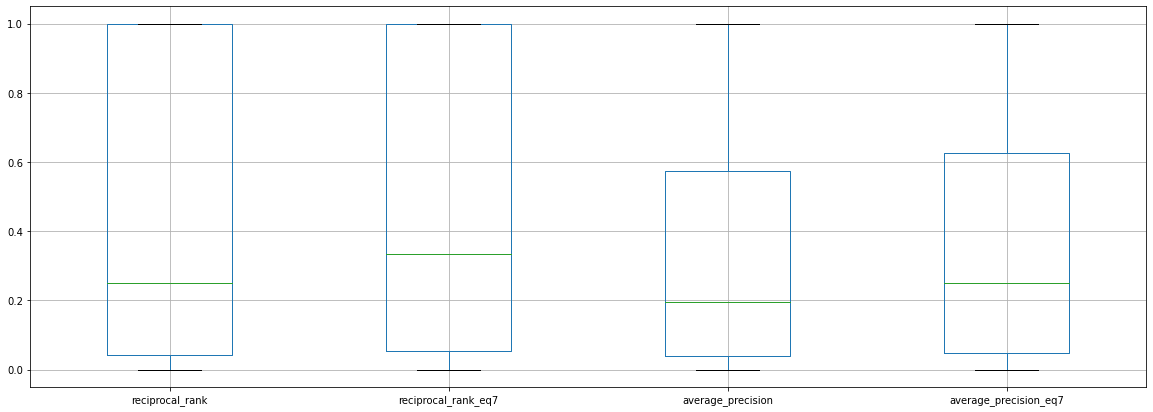

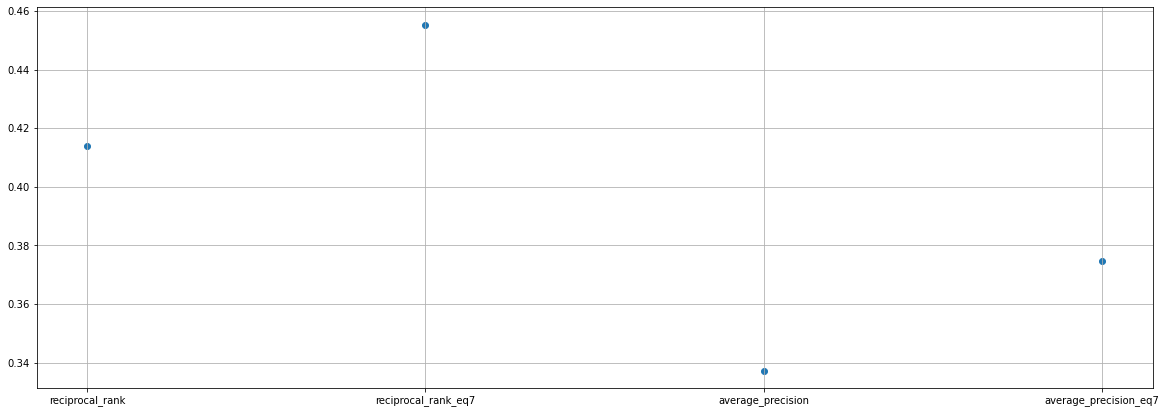

In [55]:

def generate_graphs(bugs):
    important_cols = ["reciprocal_rank","reciprocal_rank_eq7","average_precision","average_precision_eq7"]
    boxplot = bugs.boxplot(column=important_cols,figsize=(20,7))
    mean_list = list()
    for col in important_cols:
        mean_list.append(bugs[col].mean())
    fig, ax = plt.subplots(figsize=(20,7))
    ax.grid()
    ax.scatter(["reciprocal_rank","reciprocal_rank_eq7","average_precision","average_precision_eq7"],mean_list)
generate_graphs(bugs)

### Generating performance tables

In [56]:
# Creates 2 tables for performance, one for cosine similarity and one for rVSM
def performanceTable(bugs):
    data = []
    important_cols = ["reciprocal_rank","average_precision_1","average_precision_5","average_precision_10"]
    for proj in projects:
        bug_df = bugs.groupby(bugs.project).get_group(proj).copy()
        perf_list = list()
        perf_list_eq7 = list()
        
        perf_list.append(bug_df['reciprocal_rank'].mean())

        perf_list.append(bug_df['average_precision'].mean())
        

        perf_list.append(len(bug_df[(bug_df['fix_ranks'].apply(lambda x:any(i<=1 for i in x)))]))
        perf_list.append(100 * len(bug_df[(bug_df['fix_ranks'].apply(lambda x:any(i<=1 for i in x)))])/(len(bug_df)))

        perf_list.append(len(bug_df[(bug_df['fix_ranks'].apply(lambda x:any(i<=5 for i in x)))]))
        perf_list.append(100 * len(bug_df[(bug_df['fix_ranks'].apply(lambda x:any(i<=5 for i in x)))])/(len(bug_df)))

        perf_list.append(len(bug_df[(bug_df['fix_ranks'].apply(lambda x:any(i<=10 for i in x)))]))
        perf_list.append(100 * len(bug_df[(bug_df['fix_ranks'].apply(lambda x:any(i<=10 for i in x)))])/(len(bug_df)))
        
        perf_list.append(bug_df['no fix found'].sum())
        perf_list.append(bug_df['some fixes missing'].sum())
        perf_list.append(bug_df['total bug fix files'].sum())
        
        perf_list.append(len(bug_df))   
        

        data.append(perf_list)
     
    df = pd.DataFrame(data,columns=["MRR","MAP","Top 1 (Count)","Top 1 (%)","Top 5 (Count)","Top 5 (%)","Top 10 (Count)","Top 10 (%)","Bugs w/ No Fixes Found", "Bugs w/ Some Fixes Missing","Num of Bug Fix Files","Total Count"])

    df['PROJECT'] = projects
    
    df = df.set_index(['PROJECT'])
    
    return df

performance_df = performanceTable(bugs)


### Performance Per Project using rVSM (revised vector space model)

In [57]:
performance_df

,MRR,MAP,Top 1 (Count),Top 1 (%),Top 5 (Count),Top 5 (%),Top 10 (Count),Top 10 (%),Bugs w/ No Fixes Found,Bugs w/ Some Fixes Missing,Num of Bug Fix Files,Total Count
PROJECT,,,,,,,,,,,,
COLLECTIONS,0.566676,0.471407,41,44.565217,64,69.565217,68,73.913043,7,30,463,92
CONFIGURATION,0.497390,0.365789,50,37.593985,88,66.165414,104,78.195489,3,4,344,133
IO,0.536720,0.494570,42,46.153846,60,65.934066,62,68.131868,27,33,192,91
LANG,0.668825,0.617565,111,51.152074,192,88.479263,201,92.626728,6,15,433,217
DATACMNS,0.446824,0.367558,51,32.278481,98,62.025316,109,68.987342,12,24,482,158
DATAMONGO,0.311805,0.237129,53,19.557196,115,42.435424,146,53.874539,33,83,717,271
DATAREST,0.388492,0.268776,35,26.515152,67,50.757576,80,60.606061,13,26,520,132
LDAP,0.435361,0.350169,15,28.301887,35,66.037736,37,69.811321,0,3,159,53
SEC,0.359198,0.288793,134,24.768946,255,47.134935,315,58.225508,63,134,1466,541


### Fixes found in top 1%, 5% and 10% for rVSM

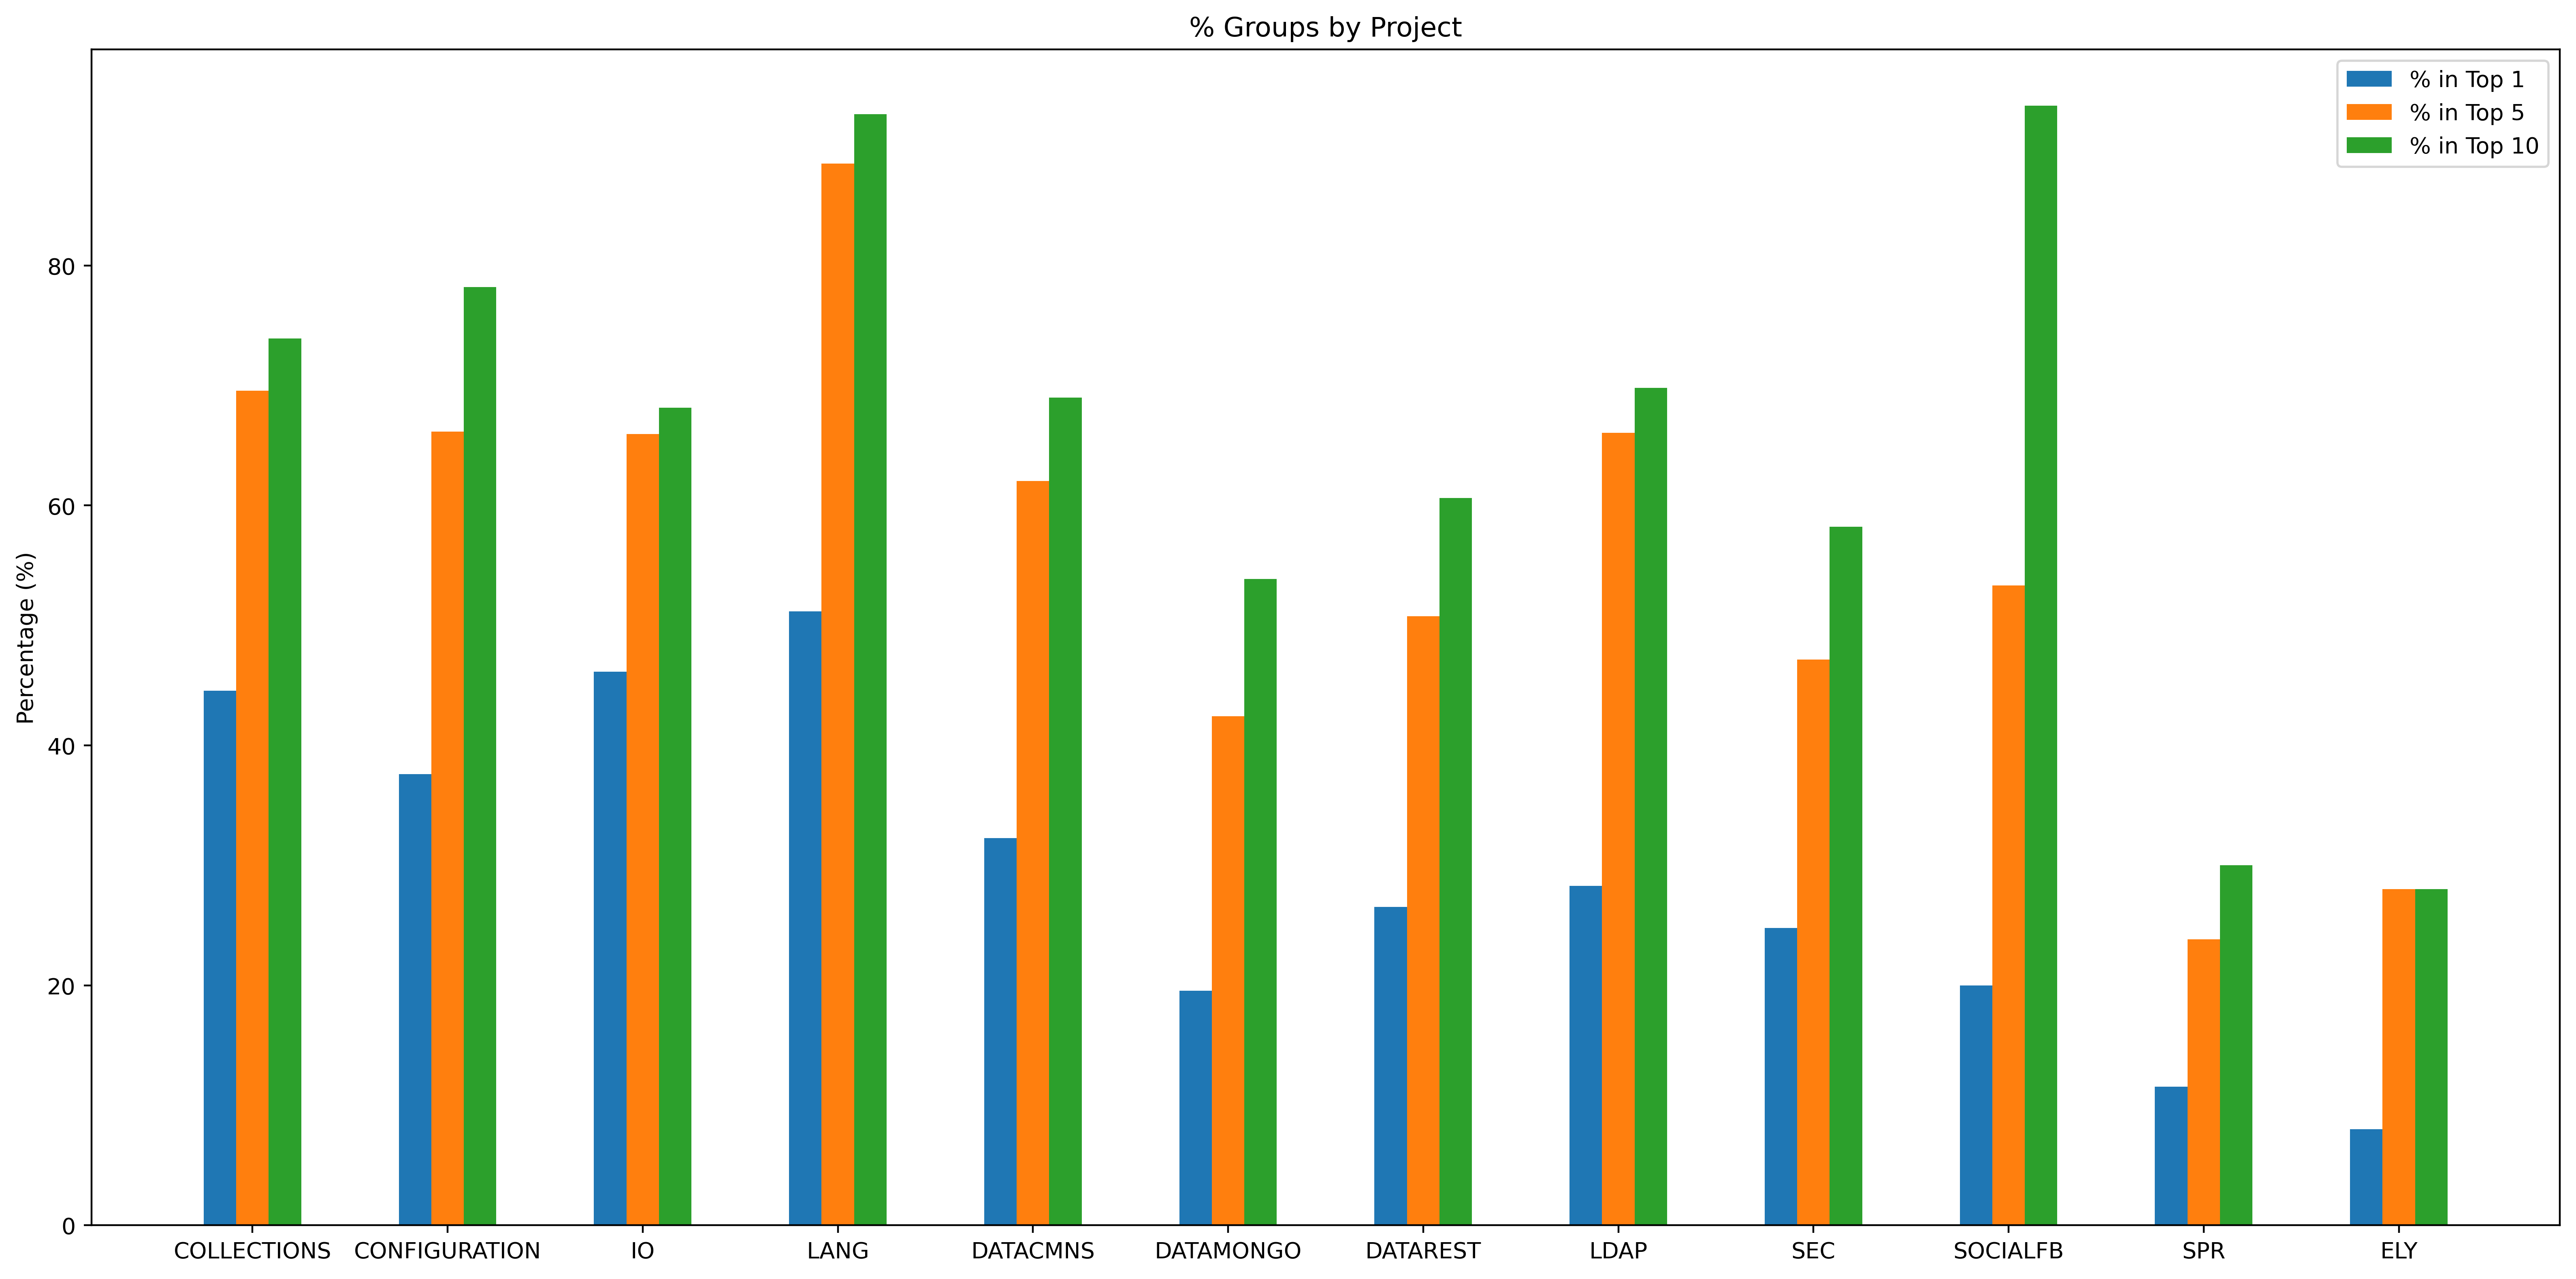

In [60]:

%matplotlib inline

def generate_bar_chart(df):
    
    bars = ["% in Top 1", "% in Top 5", "% in Top 10"]
    # projects is a list of all the projects
    
    
    width = 0.5
    x = np.arange(len(projects))
    fig, ax = plt.subplots()
    rect1 = ax.bar(x - width*1/3, df["Top 1 (%)"], width/3, label='% in Top 1')
    rect2 = ax.bar(x , df["Top 5 (%)"], width/3, label='% in Top 5')
    rect3 = ax.bar(x + width*1/3, df["Top 10 (%)"], width/3, label='% in Top 10')
    
    ax.set_ylabel("Percentage (%)")
    ax.set_title('% Groups by Project')
    ax.set_xticks(x)
    ax.set_xticklabels(projects)
    ax.legend()
    
#     autolabel(rect1, ax)
#     autolabel(rect2, ax)
#     autolabel(rect3, ax)
    fig.tight_layout()
    plt.show()
    
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 400

generate_bar_chart(performance_df)
